# Project 2: Robust Outlier Detection with GAN



Author: ZHONG, Ziyu  &emsp;&emsp; Email: zy.zhong@connect.ust.hk

# 1. Foreword

f-GAN does a great job in robust estimation [[Robust Estimate and Generative Adversarial Networks]](https://arxiv.org/abs/1810.02030), [[Generative Adversarial Nets for Robust Scatter Estimation]](https://arxiv.org/abs/1903.01944), which attracts us to explore its potential for robust outlier detection.

Anomaly detection (outlier detection) with GAN has been discussed a lot from 2016. A good survey in 2021 [[GAN-based anomaly detection: A review]](https://www.sciencedirect.com/science/article/abs/pii/S0925231221019482) clarifies the concept of anomaly detection and the development of anomaly detection with GAN. The existed papers include theories and techniques.

We extract a figure from that survey to show the history of this field:


![1](./figure/1.jpg)

It is worth mentioning that a big number of them introduce an Auto Encoder structure to learn the inverse map of the Discriminator, which is first raised by [BiGAN](https://arxiv.org/abs/1605.09782) and [ALI](https://arxiv.org/abs/1606.00704). The idea is to map the real distribution to latent space to make the features easier to be classified. However, most of them are trained only with samples with "normal" distribution , while in a real scenario it is often impossible. Some self-supervised and semi-supervised learninig methods are brought up like [[Adversarial Discriminative Attention for Robust Anomaly Detection]](https://openaccess.thecvf.com/content_WACV_2020/papers/Kimura_Adversarial_Discriminative_Attention_for_Robust_Anomaly_Detection_WACV_2020_paper.pdf). But all these methods use a general generator to learn the whole real distribution, as much as possible, whether it is corrupted. That's the reason why they usually need to be trained with clean "normal" samples. When the training set is contaminated, the results could be bad.

As far as we know, the connections between anomaly detection and Huber's $\epsilon$-contamination model using GAN are seldom discussed by far. How can we understand and solve a unsupervised anomaly (outlier) detection problem in a view of that? We propose some ideas here to open the minds. In the next chapter, we briefly summary anomaly detection, Huber's $\epsilon$-contamination model with f-GAN, and what we will do for this problem.

# 2. Introduction

We don't spend too much effort on explaining anomaly detection by just showing a nice figure extracted from the survey:

![2](./figure/2.jpg)

In the setting of Huber's $\epsilon$-contamination model, one has i.i.d observations

$$X_1,..., X_n \sim P_{\epsilon} = (1-\epsilon)P + \epsilon Q$$

$P$ refers distribution of normal samples, while $Q$ is distribution of abnormal samples. We want to learn a distribution $\tilde{P}$ which is as close to $P$ as possible.

In [[Robust Estimate and Generative Adversarial Networks]](https://arxiv.org/abs/1810.02030) and [[Generative Adversarial Nets for Robust Scatter Estimation]](https://arxiv.org/abs/1903.01944), they have good results of parameters' estimation bounds by f-GAN when $P$ is Gaussian or Elliptical distributions. In a more general setting of strong $\epsilon$-contamination model, many results still hold.

Therefore, a straightforward thought is that we have already learned a model with distribution $\tilde{P}$ which is very close to $P$, then we can judge if a point is good by whether it is from $\tilde{P}$. It is worth mentioning that a learned f-GAN model always includes two components, Discriminator and Generator. The application in anomaly detection with Discriminator has been ignored over time.

Here, we have to branch our discussions to two parts: First, $P$ is a simple distribution that we have a prior knowledge like Gaussian and Elliptical, which is often seen in financial data, etc. This make us be able to predetermine a family of distibution of Generator, which is in fact the source of robustness in parameters' estimation in those two articles.

Second, $P$ is a complex distribution that is often seen in high dimensions like image data. Most works on anomaly detection are focused at that. The bad news here is that we can not properly constraint the distibution of Generator, since it is too complex. Thus we are forced to choose a more general Generator, resulting in that the robustness of estimation can not be guaranteed. Therefore, from an unsupervised learning's view, this is hard to be done. However, in a supervised learning's view (not accurate, since we don't need abnormal data), though most works on anomaly detection are done from that point, we may implement a robust estimation in the latent space. It requests us to learn a reverse map of Generator, and hope that normal samples are mapped to the range of Gaussian (or other known distributions) but abnormal samples are mapped out the range of Gaussian (Contrastive learning?). The Generator here does not have to be the network structure in GAN, models like Diffusion may work too.

In this project, we only focus on the first part, since the second part has a lot of problems to be done and is computation-consuming.

# 3. Methodology of Detecting Outliers by GAN

Assume we have prior knowledge of normal samples' distribution $P$, for example, Gaussian. And we have learned a Gaussian $\tilde{P}$ by f-GAN. We have three directions to detect the outliers: *1. Generator* *2. Discriminator* *3. Combinations of Generator and Discriminator*. 

We explain them one by one:

1.**Generator**.

From a view of Generator, it is the most straightforward. As to restrict the family of distributions, Generator $G(z)$ is usually just simple linear combinations of $z \sim \mathcal{N}(0,1)$. It is easy to restore $\tilde{P}$ and then use parametric statistics methods to get confidence intervals, detecting the outliers out of that.

2.**Discriminator**.

Discriminator is often ignored since the ambiguity in its meaning. Especially in a robust setting where $\tilde{P}$ can not be very close to $P_{\epsilon}$, we need to handle it more carefully. We try to understand Discriminator by checking the lower bound on the $f$-divergence, i.e. the objective function of $f$-GAN:

$$D_f(P \| Q) \geqslant \sup_{T\in\mathcal{T}}(\mathbb{E}_{x\sim P} [T(X)] - \mathbb{E}_{x\sim Q} [f^*(T(X))])$$

(Here $P$ refers to $P_{\epsilon}$, $Q$ refers to $\tilde{P}$.) We set the Discriminator $D(X) = T(X)$. And we know the optimal $T^*(x) = f'(\dfrac{p(x)}{q(x)})$. Assume that }the Disciminator has attained optimal, we can then use $\dfrac{p(x)}{q(x)} = f'^{-1}(T^*(x))$ to figurer out the densities ratio between real distribution and learned distribution. With this information, we can somehow judge whether a point is outlier. $f'^{-1}$ here always exists since the convexity of $f$. But what range of $\dfrac{p(x)}{q(x)}$ should be regarded as an outlier? It seems that $\dfrac{p(x)}{q(x)}$ around $1-\epsilon$ is good, too large or too small $\dfrac{p(x)}{q(x)}$ are more possible to be outliers. Thus we can set two thresholds $\Delta_{l}$ and $\Delta_{u}$ to exclude outliers in $\{\Delta_{l} \leqslant\dfrac{p(x)}{q(x)}\leqslant \Delta_{u}\}$.The level of the thresholds depends on how convincing $P$ and $Q$ are and what distributions they are. It is very tricky to analysis this problem, since in a real scenario, the supports of distributions are often seen as finite, which may cause almost non-smooth changes in solved $\dfrac{p(x)}{q(x)}$ given by Discriminator. For different scenario, we need to design thresholds differently. But the good thing is, in the sample space where supports of $P$ and $Q$ not overlapped, the $\dfrac{p(x)}{q(x)}$ will be significantly high or low, which can be regareded as outliers.

3.**Combinations of Generator and Discriminator**.

In some scenario, the Discriminator may fail. Think about the real density $p(x)=(1-\epsilon)\mu(x) + \epsilon\nu(x)$, where $\mu$ is the distribution of normal data, $\nu$ is the distribution of abnormal data. We assume they do not share any support. Now assume we learned a distribution $q(x) = \mu(x)$, then $\dfrac{p(x)}{q(x)}$ becomes $(1-\epsilon) + \epsilon\dfrac{\nu(x)}{\mu(x)}$. On the support of $\nu$, $\dfrac{p(x)}{q(x)}=+\infty$, which can be found to be outliers. On the support of $\mu$, $\dfrac{p(x)}{q(x)} = 1-\epsilon$, which gives no information to classify. In some sense, we do a quite right thing to totally seperate samples from $\mu$ and $\nu$ by Discriminator. But in another sense, we take every point on the support of $\mu$ the same, which is anti-intuition. In fact, in a real situation, where supports are finite, it is hard to predict the value of Discriminator of the points with very low density, since we don't have enough information around the point. Thus a constant $\dfrac{p(x)}{q(x)}$ for every point is unrealistic. It is also a reason of why the Discriminator is not that reliable. 

In some scenario, the Generator may fail too, which happens when the distribution of normal samples is not fitting our prior assumption, or the distribution of normal samples and abnormal samples are overlapped.

A more reliable process could be: First filter the data by confident interval of Generator's distribution, then filter the data by level of solved $\dfrac{p(x)}{q(x)}$.

In the next chapter, we will do some numerical experiments to verify the capability of robust outlier detection with f-GAN.

# 4. Numerical Experiments

## 4.1 Experiment One

We generate data under Huber Contamination model:
$$ x_i \sim 0.8 {\mathcal{N}}(0,I_p) + 0.2 {\mathcal{N}}(5*1_p, 2*I_p),$$
with $N=50000$ samples and dimension $p=2$.

We select JS-GAN to fit the samples, the estimator is defined by:

$$\hat{\theta} = \arg\!\inf_{\eta \in \mathbb{R}^p, \Sigma\succeq 0} \sup_{D\in \mathcal{D}}\left[\dfrac{1}{n}\sum_{i=1}^{n}\log D(X_i) + \mathbf{E}_{{\mathcal{N}}(\eta,\Sigma)}\log (1-D(X_i))\right] + \log 4$$

Here $D(x) = e^{T(x)}$.

In [1]:
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

import numpy as np
import pandas as pd
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal
import warnings
warnings.filterwarnings("ignore")

from fgan import fgan

# Assume that we are on a CUDA machine, then this should print a CUDA device:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)


cuda


In [2]:
## initialize data 80% Gaussian(0_p, I_p) and 20% Gaussian(5*1_p, 2*I_p)
## where dimension p=50, sample size N=50000
XReal = np.random.normal(loc=0., scale=1., size=(40000, 2))
XCont = np.random.normal(loc=5., scale=2., size=(10000, 2))
XData = np.concatenate( (XReal, XCont), axis=0 )
print(XData.shape)

(50000, 2)


Epoch:25, LossD/G:1.2579/-0.6200


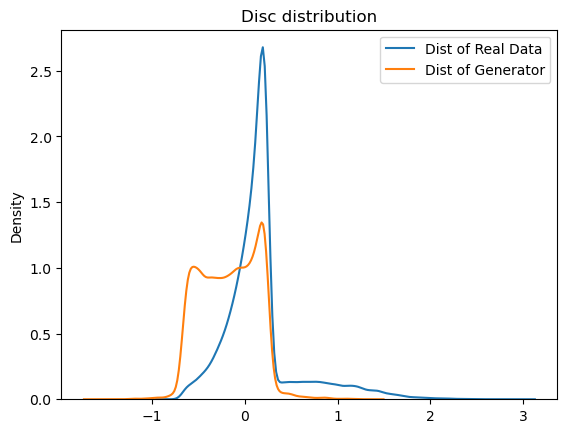

Epoch:50, LossD/G:1.2900/-0.6324


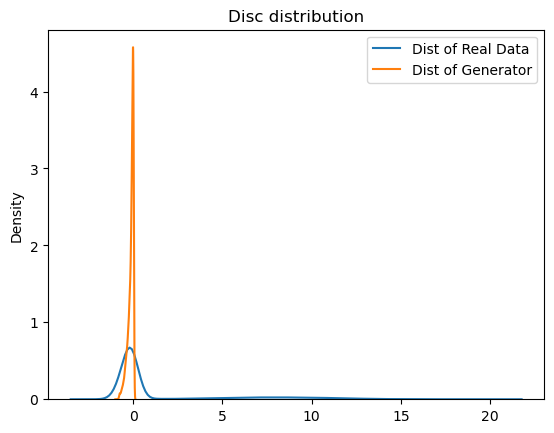

Epoch:75, LossD/G:1.2193/-0.5830


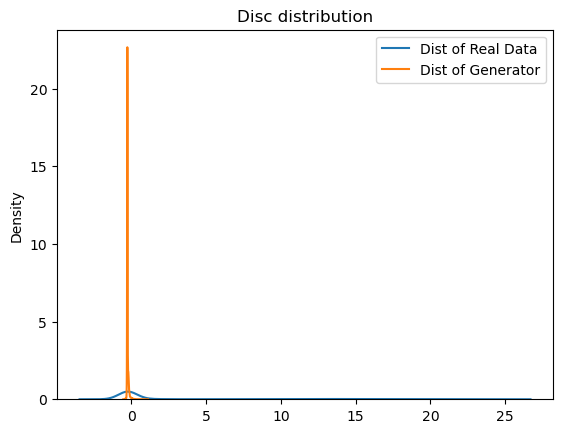

Epoch:100, LossD/G:1.2439/-0.5970


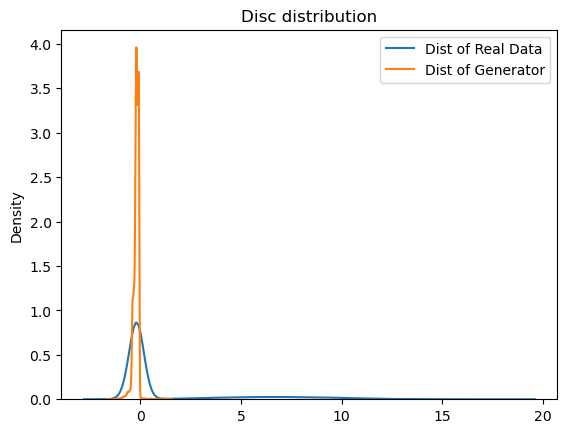

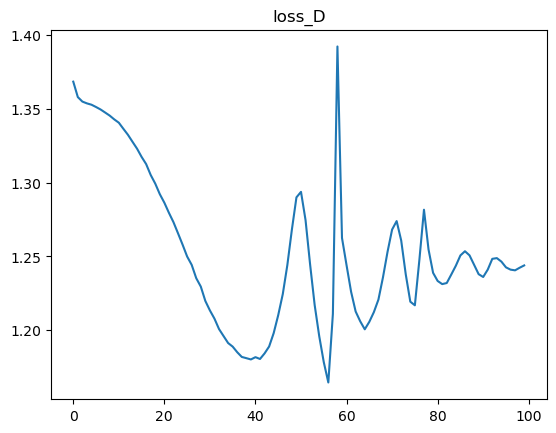

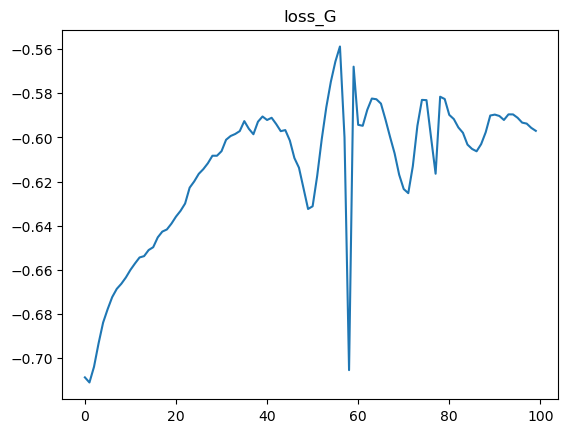

Time for running this cell: 198.85s


In [3]:
s0 = time.time()
f0 = fgan(2, 0.0, device, epsilon=1e-5)
f0.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f0.data_init(batch_size = 100, 
             data = torch.from_numpy( XData[np.random.shuffle(np.arange(50000))].squeeze() ).float() )
f0.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f0.optimizer_init(lr_d=0.001, lr_g=0.01, d_steps=3, g_steps=1)
f0.fit(floss='js', epochs=100, avg_epochs=20,
       verbose=25, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Generator $G(z) = W^T z + b,\ z\sim \mathcal{N}(0,I_p)$, we show $W$ and $b$ estimated here and calculate covariance $\Sigma = W^TW$:

In [44]:
W = f0.netG.weight.detach().cpu().numpy()
print(W)

[[-0.72461754 -0.7351029 ]
 [-0.63332117  0.6385896 ]]


In [45]:
b = f0.netG.bias.detach().cpu().numpy()
print(b)

[0.01707499 0.00417302]


In [46]:
print(W.T @ W)

[[0.9261663  0.12823614]
 [0.12823614 0.9481729 ]]


We can see the estimation is quite good, where $b$ is close to $0$ and $\Sigma$ is close to $I_p$.

Now we implement the outlier detection in above ways. We start with the view of Generator, using statistical method. We roughly use $\| (x-b)^TW^{-1}\|_2 > 3.5$ as the standard of classifying outliers.

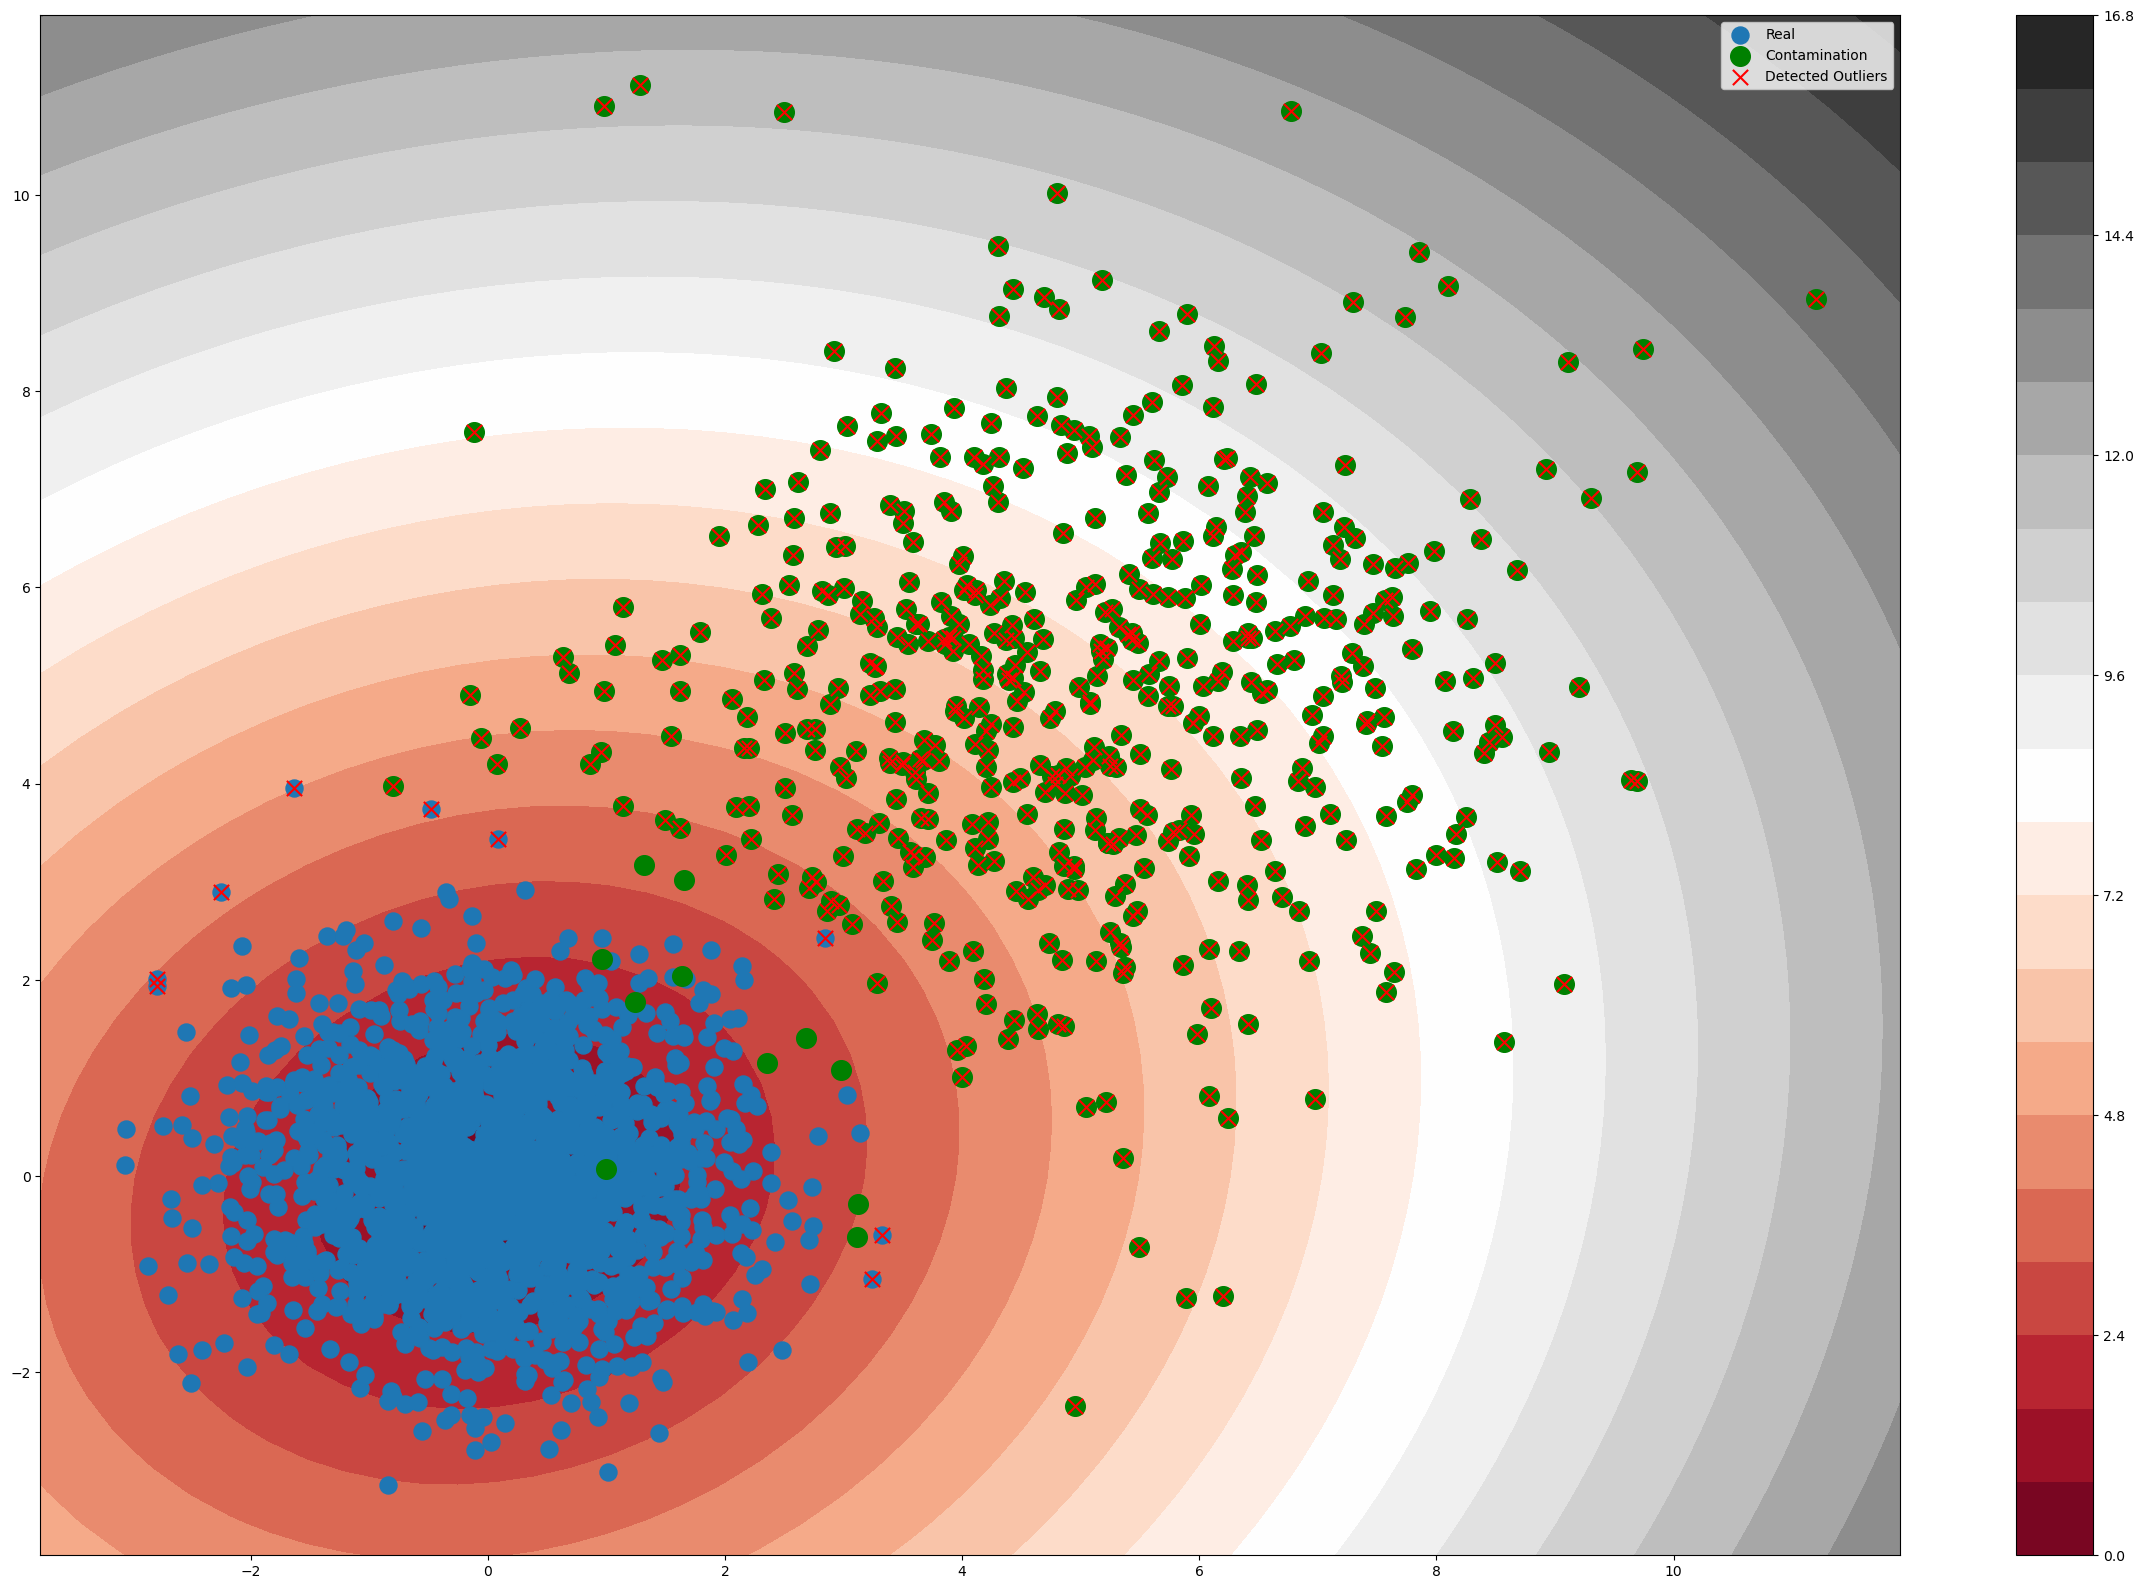

In [134]:
## Confident interval
W_inv = np.linalg.inv(W)
XTest = np.concatenate( (XReal[:2000], XCont[:500]), axis=0 )
## Statistical score for generator samples
statscore = np.linalg.norm((XTest-b) @ W_inv, axis=1)
outlierIndex = (statscore > 3.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = np.linalg.norm((np.array([x, y])-b) @ W_inv)
plt.contourf(X, Y, Z, 20, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:2000], XCont[:500]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

Next, we take a view of Discriminator. It should be known that the Discriminator network of JS-GAN in `fgan.py` retrun a value corresponding to $\log \dfrac{p(x)}{q(x)}$ in our analysis. We set $\log \dfrac{p(x)}{q(x)} < -2$ or $\log \dfrac{p(x)}{q(x)} > 0.5$ to be outliers.

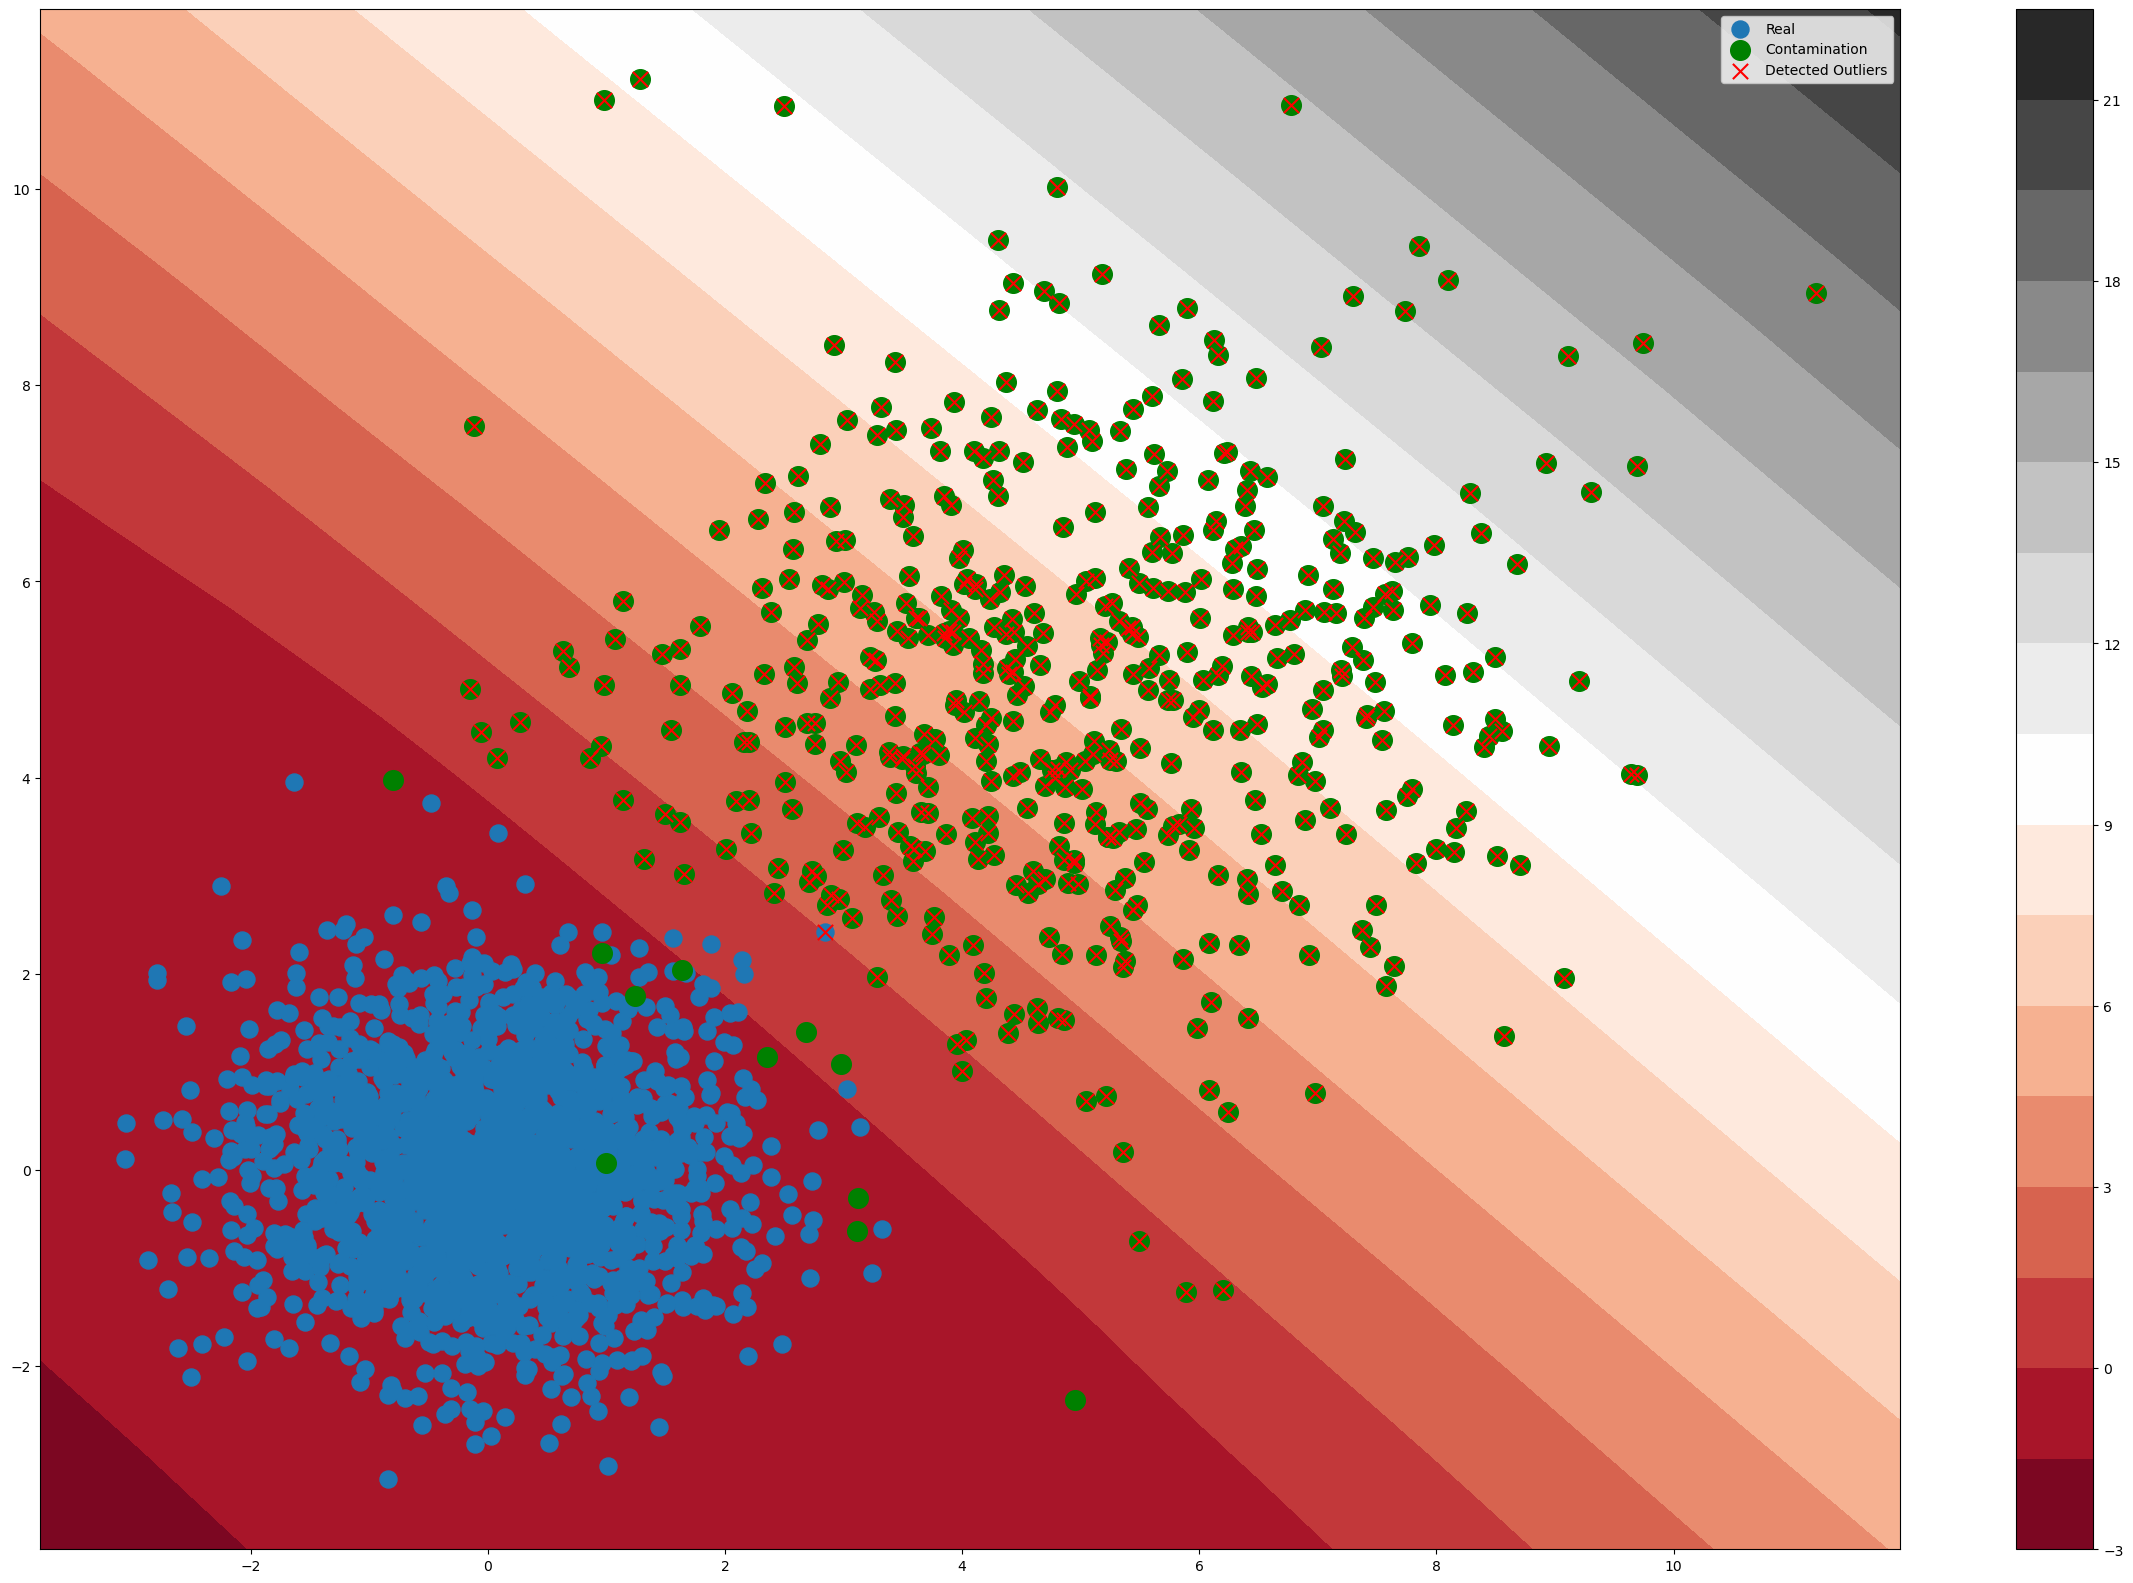

In [133]:
## G-score for 
XTest = torch.from_numpy( np.concatenate( (XReal[:2000], XCont[:500]), axis=0 ) ).float()
## Discriminator score for generator samples
Dscore = f0.netD(XTest.to(device))[1].detach().cpu().numpy()
outlierIndex = (Dscore < -2) | (Dscore > 0.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = f0.netD(torch.tensor([x, y]).to(device).float())[1].detach().cpu().numpy()
plt.contourf(X, Y, Z, 20, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:2000], XCont[:500]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

The figures above show that the generator captures the normal distribution of samples and the discriminator identifies outliers (green points) together with a few normal samples (blue points). The contours in each figure means the level of $\| (x-b)^TW^{-1}\|_2$ and the level of Discriminator $D(x)$. In this setting, both Generator and Discriminator do a good job to detect outliers, but in different philosiphies. Both have their advantanges and shortcomings.

## 4.2 Experiment Two

By obervations from experiment one, we are interested in what if the separation is more complicated.

We generate data under Huber Contamination model:
$$ x_i \sim 0.8 {\mathcal{N}}(0,I_p) + 0.1 {\mathcal{N}}(5*1_p, 2*I_p) + 0.05 {\mathcal{N}}(-5*1_p, 2*I_p) + 0.05 {\mathcal{N}}((-5,5)^T, 2*I_p),$$
with $N=50000$ samples and dimension $p=2$.

We still select JS-GAN to fit the samples, the estimator is defined by:

$$\hat{\theta} = \arg\!\inf_{\eta \in \mathbb{R}^p, \Sigma\succeq 0} \sup_{D\in \mathcal{D}}\left[\dfrac{1}{n}\sum_{i=1}^{n}\log D(X_i) + \mathbf{E}_{{\mathcal{N}}(\eta,\Sigma)}\log (1-D(X_i))\right] + \log 4$$

Here $D(x) = e^{T(x)}$.

In [142]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

XReal = np.random.normal(loc=0., scale=1., size=(40000, 2))
XCont1 = np.random.normal(loc=5., scale=2., size=(5000, 2))
XCont2 = np.random.normal(loc=-5., scale=2., size=(2500, 2))
XCont3 = np.concatenate([np.random.normal(loc=5., scale=2., size=(2500, 1)), np.random.normal(loc=-5., scale=2., size=(2500, 1))], axis=1)
XCont = np.concatenate( (XCont1, XCont2, XCont3), axis=0 )
XData = np.concatenate( (XReal, XCont), axis=0 )
print(XData.shape)

(50000, 2)


Epoch:25, LossD/G:1.3445/-0.6693


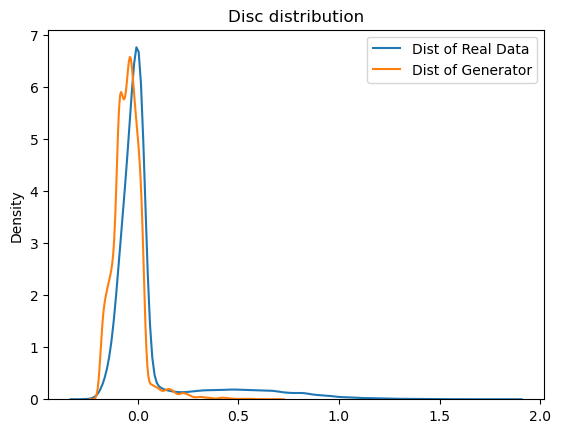

Epoch:50, LossD/G:1.2719/-0.6417


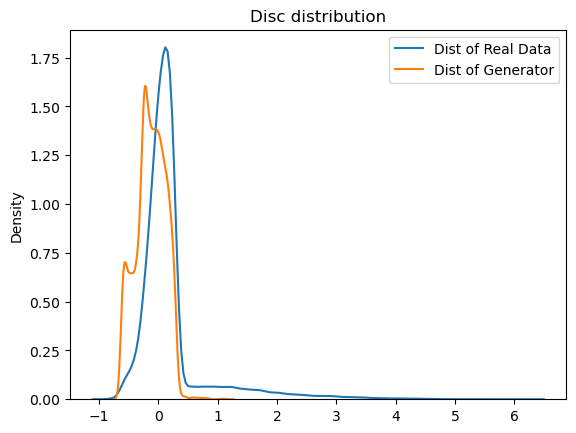

Epoch:75, LossD/G:1.2519/-0.6026


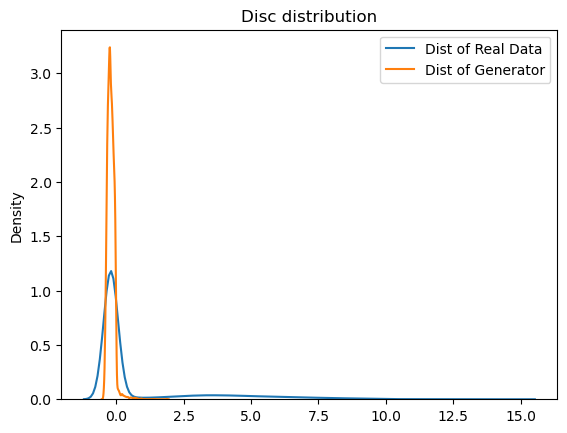

Epoch:100, LossD/G:1.2479/-0.6012


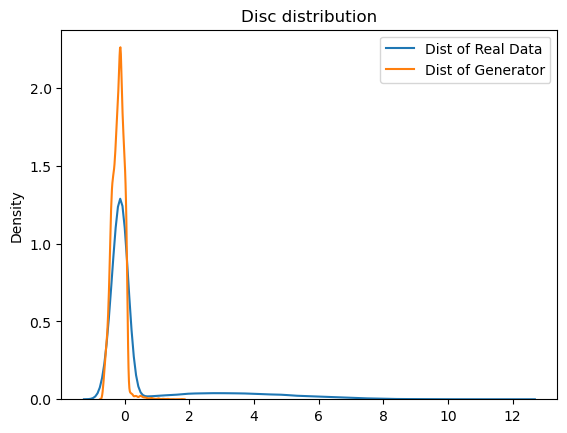

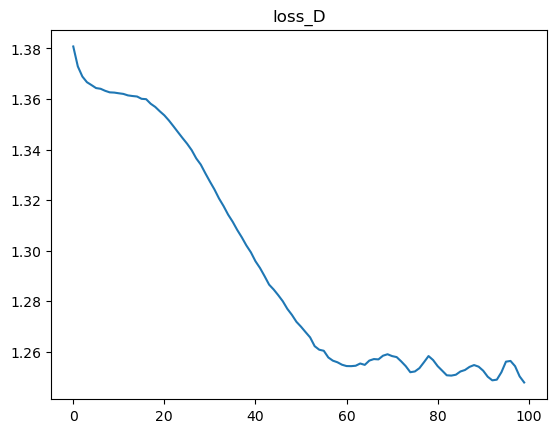

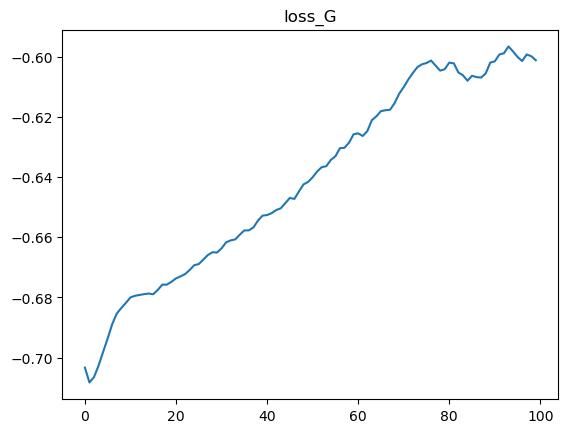

Time for running this cell: 204.28s


In [143]:
s0 = time.time()
f0 = fgan(2, 0.0, device, epsilon=1e-5)
f0.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f0.data_init(batch_size = 100, 
             data = torch.from_numpy( XData[np.random.shuffle(np.arange(50000))].squeeze() ).float() )
f0.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f0.optimizer_init(lr_d=0.001, lr_g=0.01, d_steps=3, g_steps=1)
f0.fit(floss='js', epochs=100, avg_epochs=20,
       verbose=25, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Generator $G(z) = W^T z + b,\ z\sim \mathcal{N}(0,I_p)$, we show $W$ and $b$ estimated here and calculate covariance $\Sigma = W^TW$:

In [144]:
W = f0.netG.weight.detach().cpu().numpy()
print(W)

[[-0.9933077  -0.9330471 ]
 [-0.7668588   0.82508916]]


In [145]:
b = f0.netG.bias.detach().cpu().numpy()
print(b)

[ 0.01340723 -0.02392223]


In [146]:
print(W.T @ W)

[[1.5747327  0.29407597]
 [0.29407597 1.551349  ]]


We can see the estimation of mean is still good, but $\Sigma$ is affected much.

Now we implement the outlier detection. We start with the view of Generator, using statistical method. We roughly use $\| (x-b)^TW^{-1}\|_2 > 3.5$ as the standard of classifying outliers.

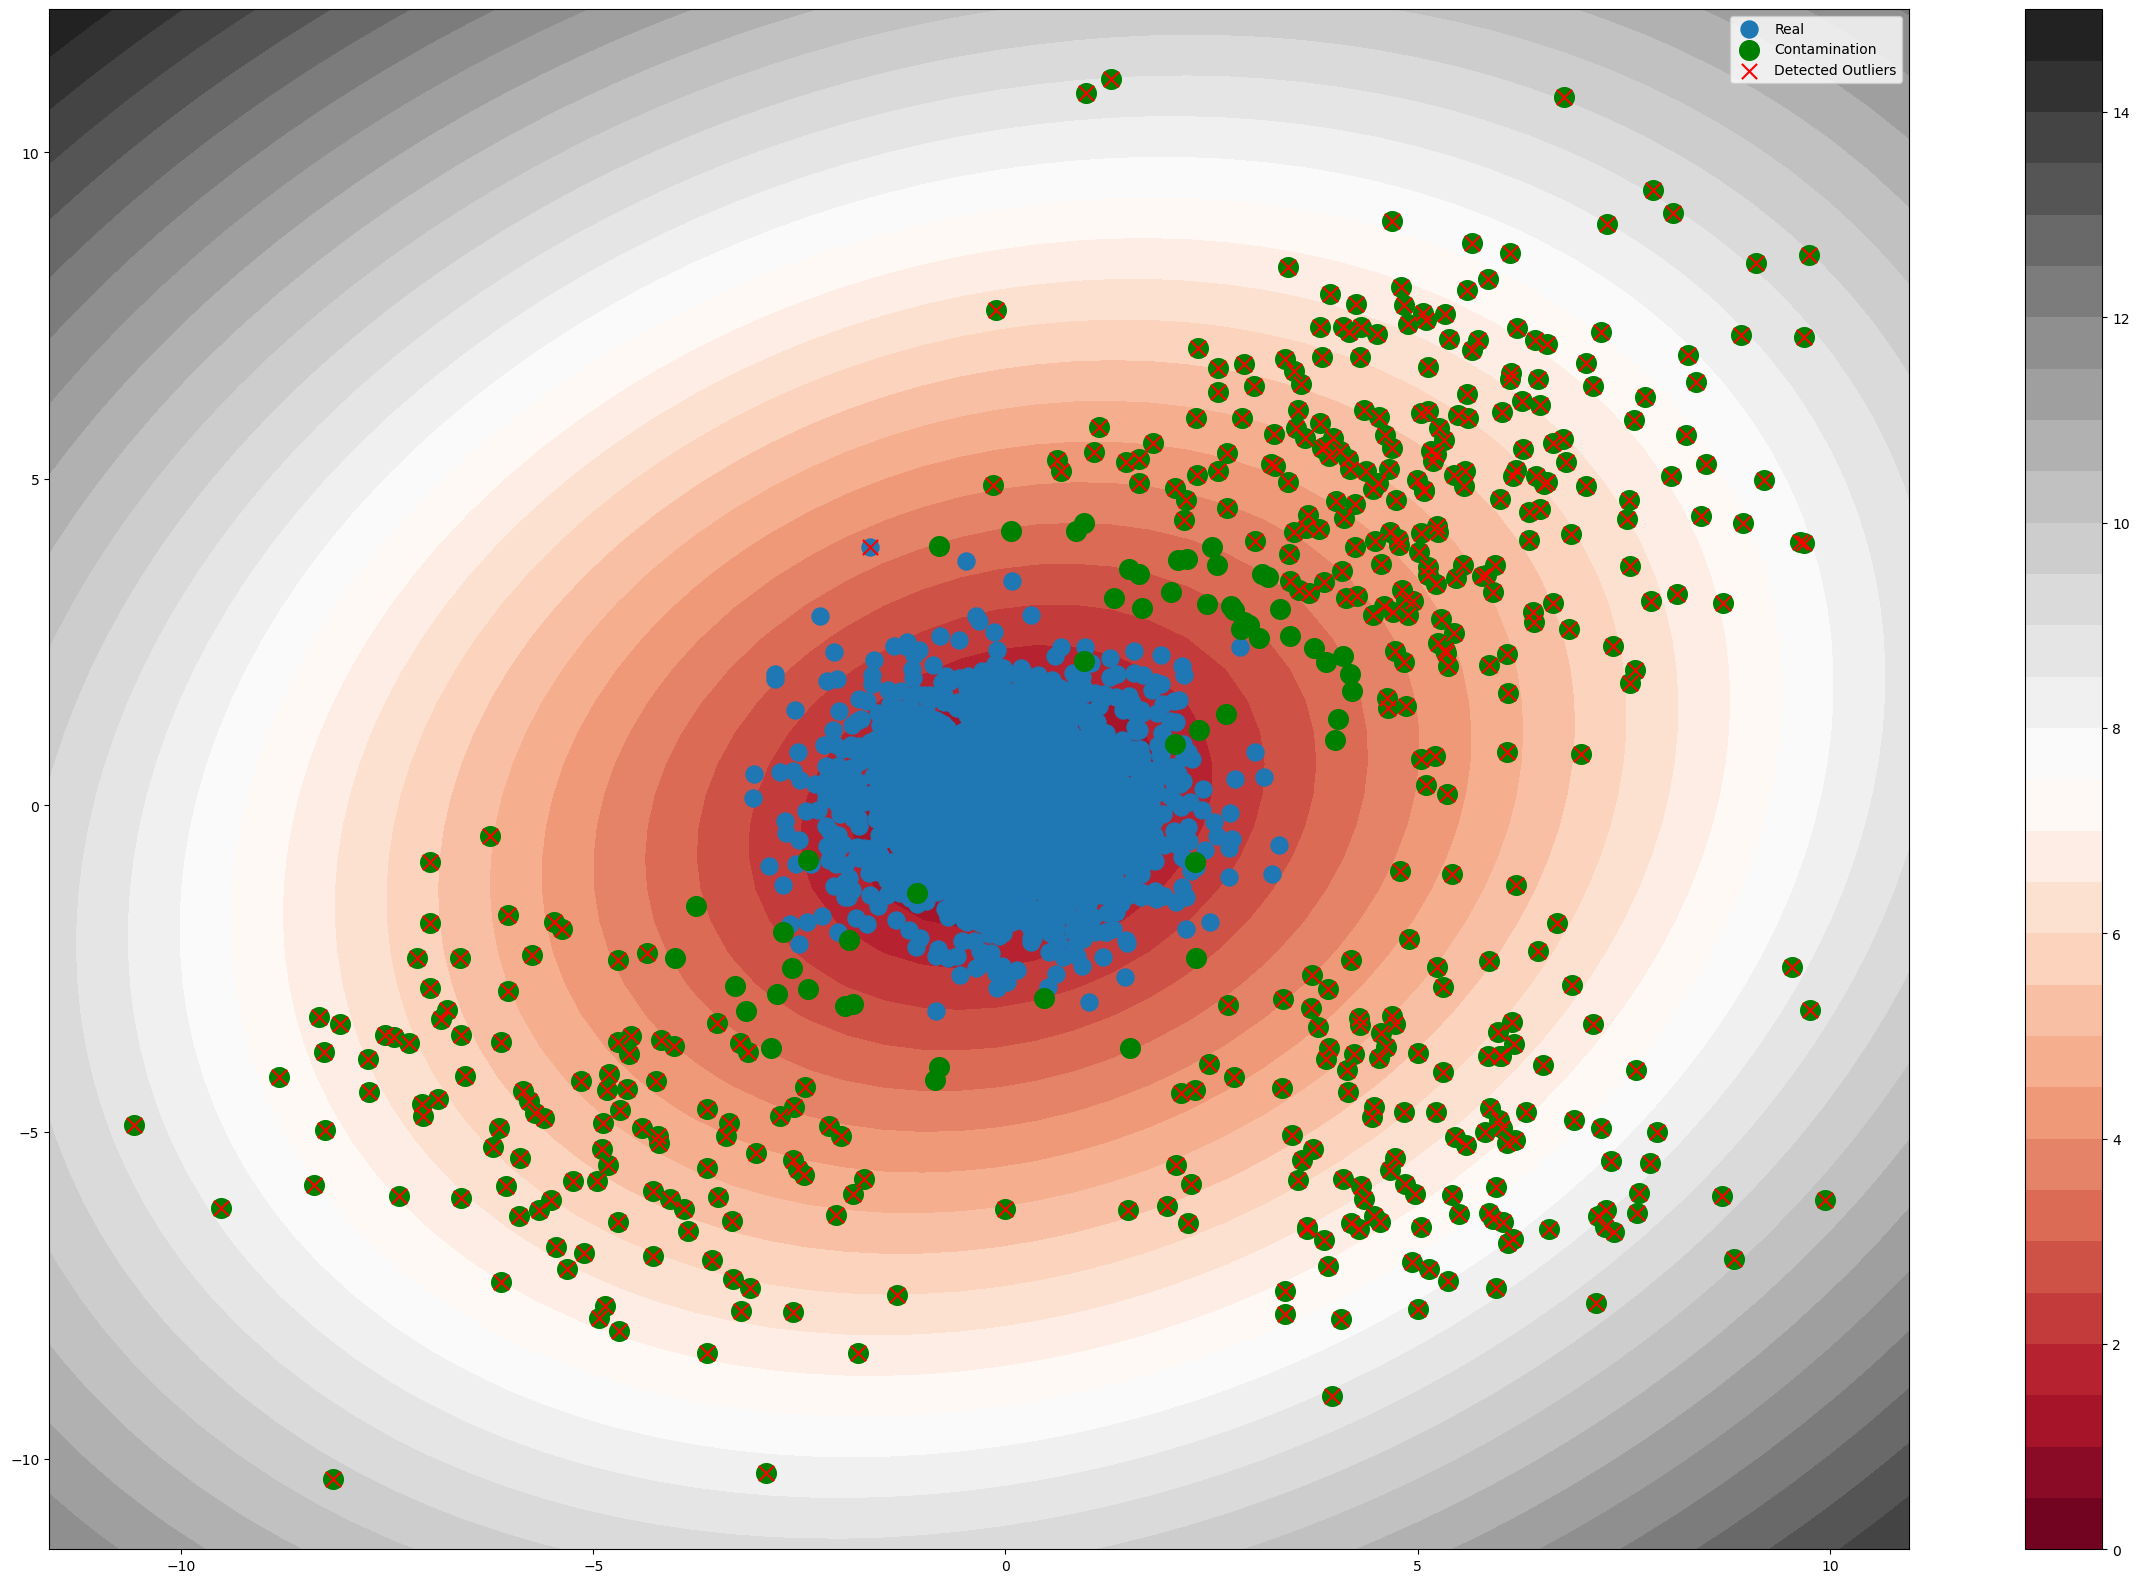

In [162]:
## Confident interval
W_inv = np.linalg.inv(W)
XTest = np.concatenate( (XReal[:2000], XCont1[:250], XCont2[:125], XCont3[:125]), axis=0 )
## Statistical score for generator samples
statscore = np.linalg.norm((XTest-b) @ W_inv, axis=1)
outlierIndex = (statscore > 3.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XTest[-500:, 0], XTest[-500:, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = np.linalg.norm((np.array([x, y])-b) @ W_inv)
plt.contourf(X, Y, Z, 30, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XTest[-500:, 0], XTest[-500:, 1], s=200, c="g", label="Contamination")
outliers = XTest[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

It can be seen that the over-estimation of variance let the detection be more tolerent with samples from the abnormal distribution.

Next, we take the view of Discriminator. Again, We set $\log \dfrac{p(x)}{q(x)} < -2$ or $\log \dfrac{p(x)}{q(x)} > 0.5$ to be outliers.

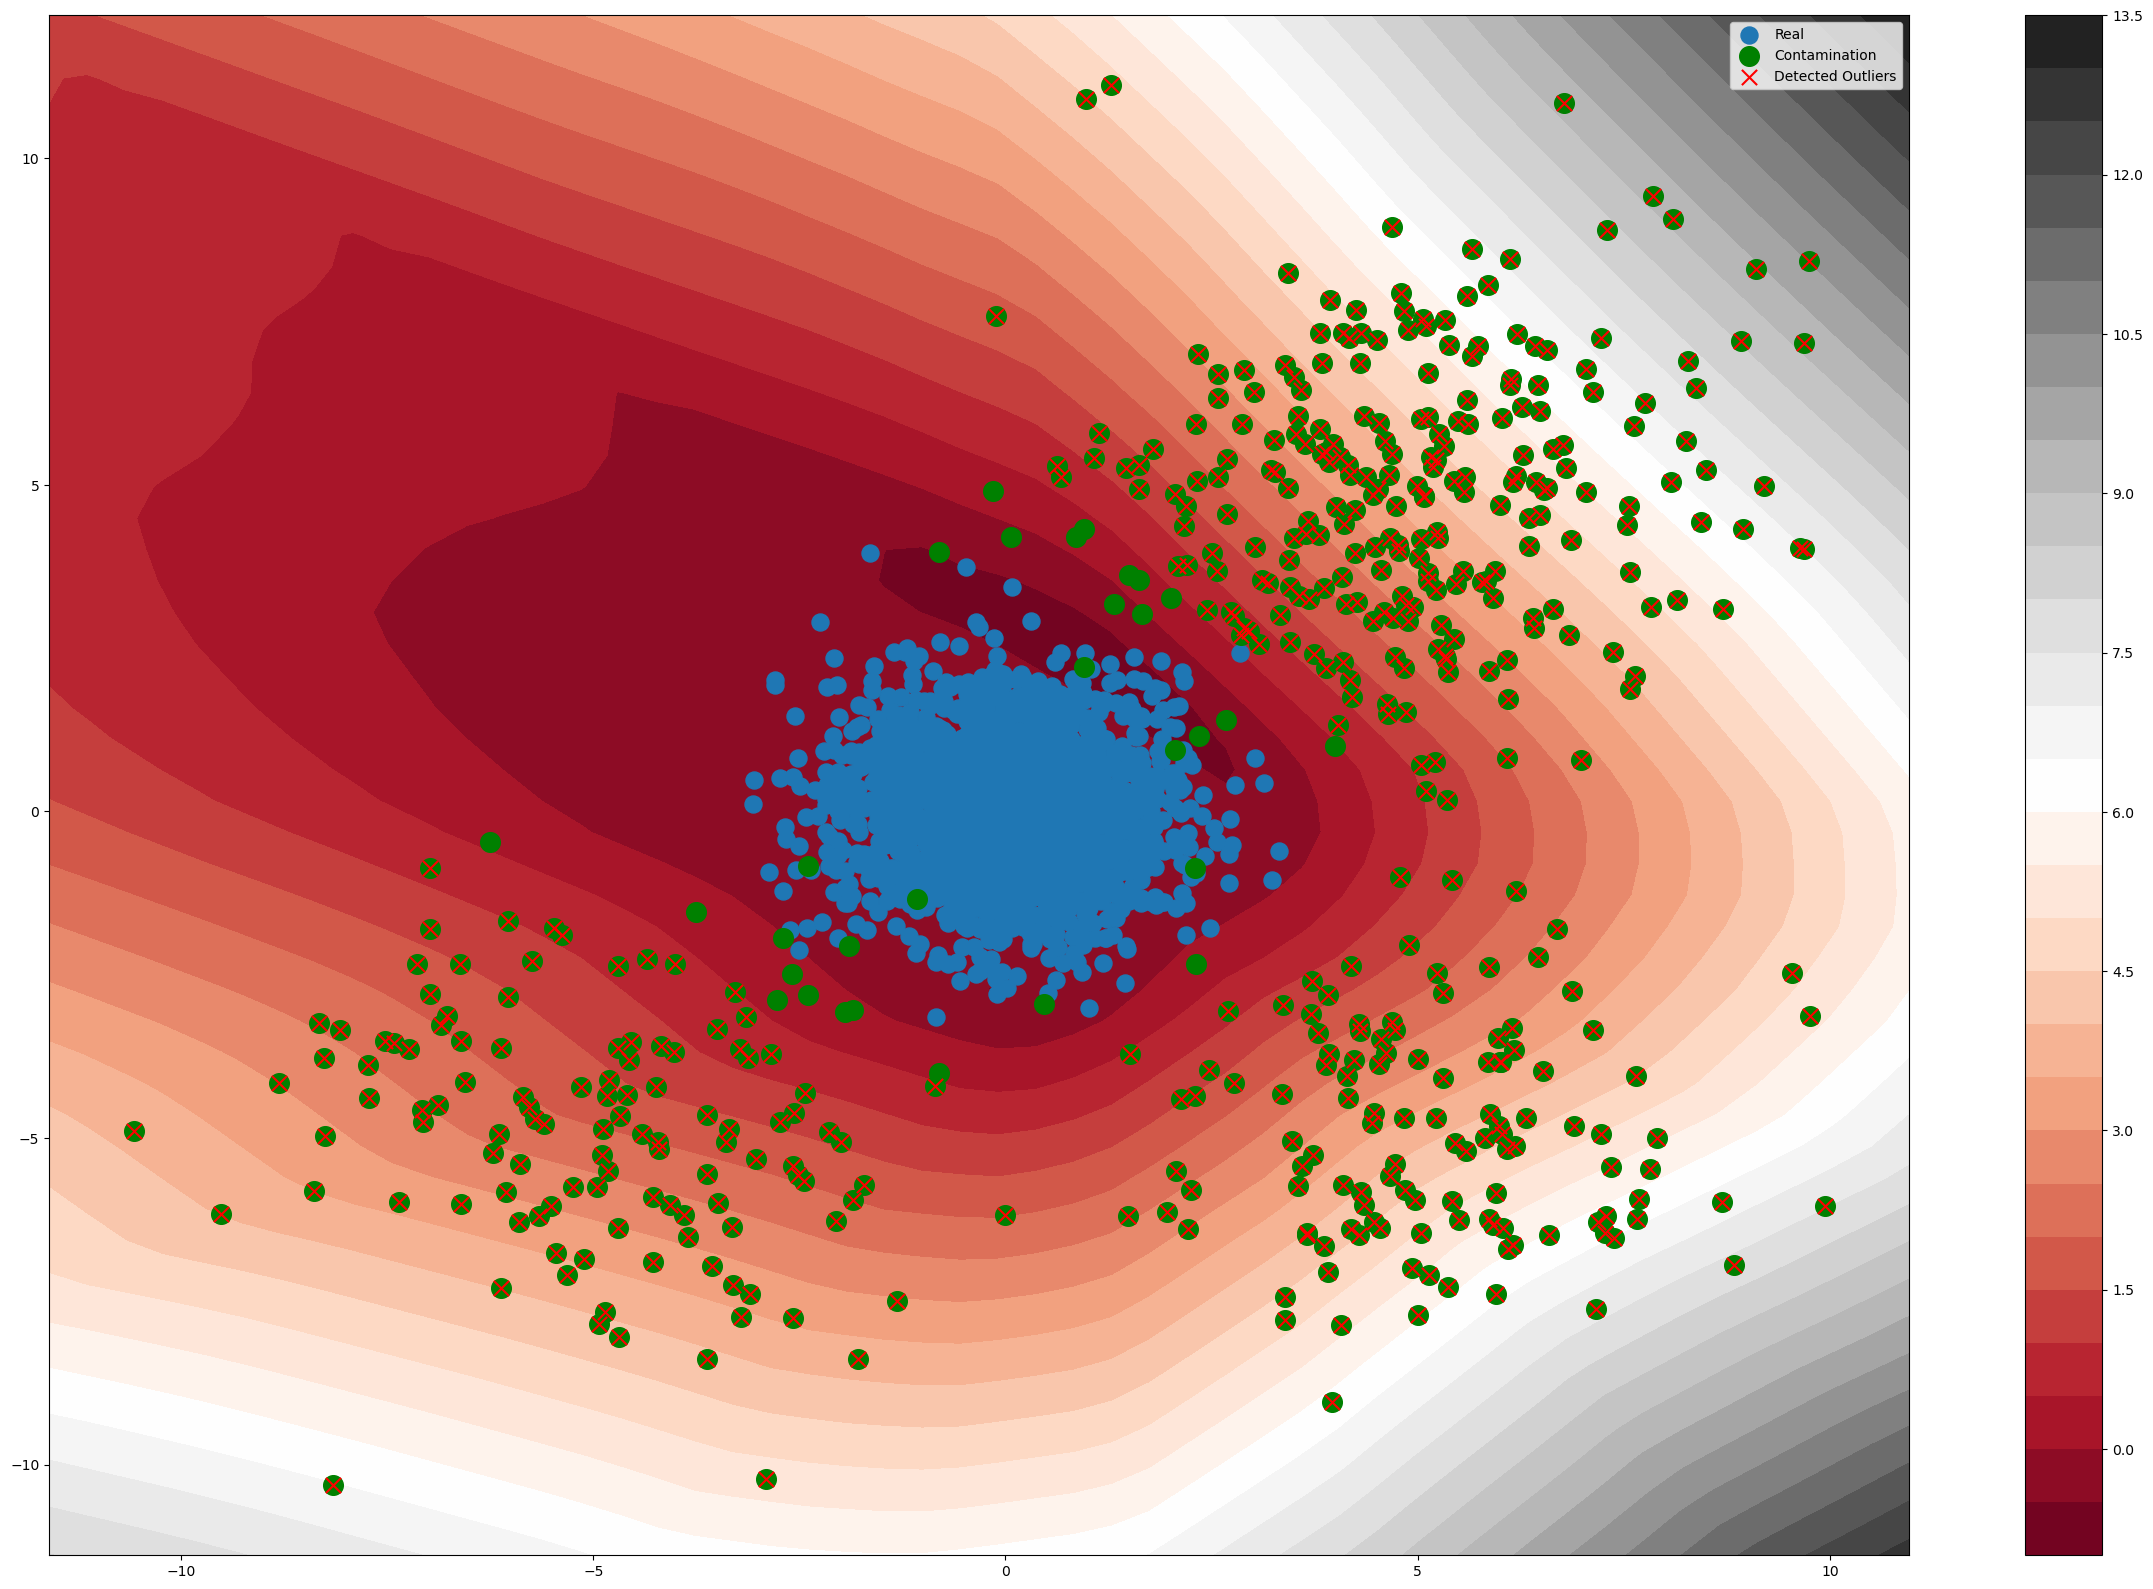

In [165]:
## G-score for 
XTest = torch.from_numpy( np.concatenate( (XReal[:2000], XCont1[:250], XCont2[:125], XCont3[:125]), axis=0 ) ).float()
## Discriminator score for generator samples
Dscore = f0.netD(XTest.to(device))[1].detach().cpu().numpy()
outlierIndex = (Dscore < -2) | (Dscore > 0.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XTest[-500:, 0], XTest[-500:, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = f0.netD(torch.tensor([x, y]).to(device).float())[1].detach().cpu().numpy()
plt.contourf(X, Y, Z, 30, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XTest[-500:, 0], XTest[-500:, 1], s=200, c="g", label="Contamination")
outliers = XTest[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

It can be seen that, compared with the method from Generator, the method from Discriminator preserves more information from the abnormal samples, which may contribute to its outperformance than that of Generator. The threshold of $\dfrac{p(x)}{q(x)}$ seems to be robust from experiment one to two, which is very inspiring.

## 4.3 Experiment Three

We go further to see the performance on non-separable case.

We generate data under Huber Contamination model:
$$ x_i \sim 0.8 {\mathcal{N}}(0,I_p) + 0.2 {\mathcal{N}}(2*1_p, 0.09*I_p),$$
with $N=50000$ samples and dimension $p=2$.

We select JS-GAN to fit the samples, the estimator is defined by:

$$\hat{\theta} = \arg\!\inf_{\eta \in \mathbb{R}^p, \Sigma\succeq 0} \sup_{D\in \mathcal{D}}\left[\dfrac{1}{n}\sum_{i=1}^{n}\log D(X_i) + \mathbf{E}_{{\mathcal{N}}(\eta,\Sigma)}\log (1-D(X_i))\right] + \log 4$$

Here $D(x) = e^{T(x)}$.

In [195]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

XReal = np.random.normal(loc=0., scale=1., size=(40000, 2))
XCont = np.random.normal(loc=2., scale=0.3, size=(10000, 2))
XData = np.concatenate( (XReal, XCont), axis=0 )
print(XData.shape)

(50000, 2)


Epoch:25, LossD/G:1.3070/-0.6552


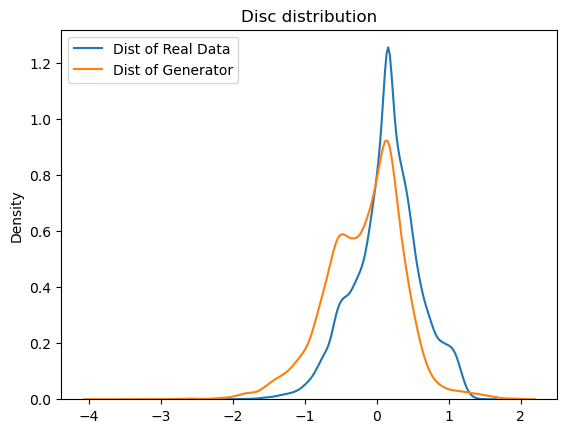

Epoch:50, LossD/G:1.2918/-0.6446


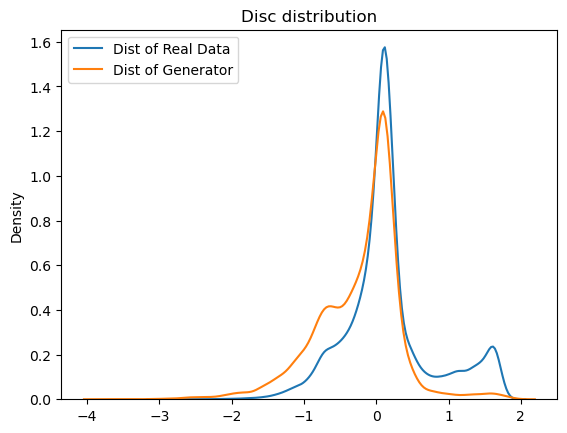

Epoch:75, LossD/G:1.2815/-0.6393


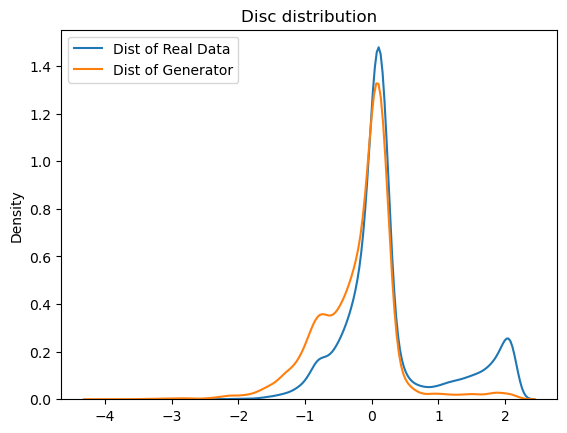

Epoch:100, LossD/G:1.2788/-0.6288


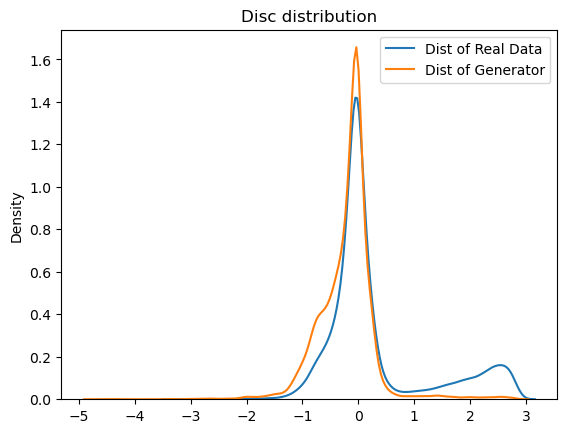

Epoch:125, LossD/G:1.2760/-0.6288


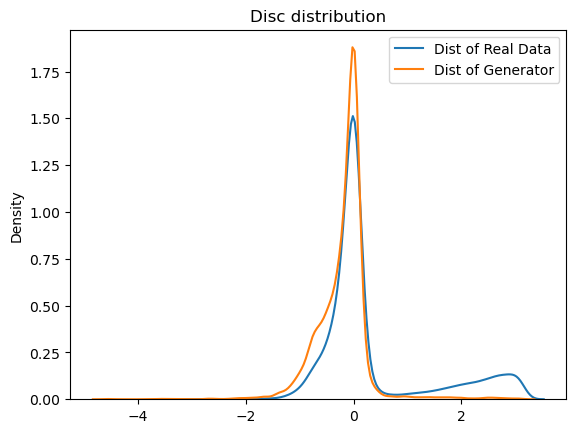

Epoch:150, LossD/G:1.2764/-0.6269


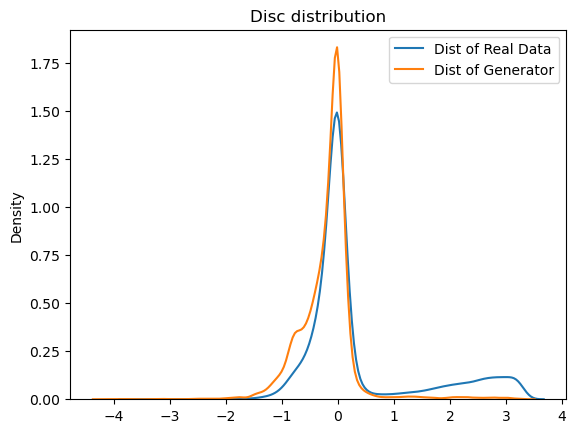

Epoch:175, LossD/G:1.2779/-0.6205


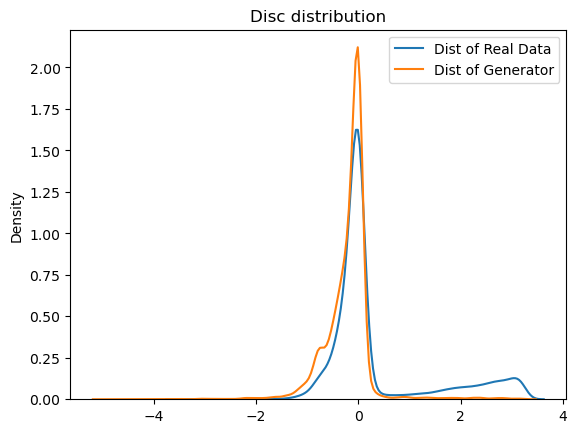

Epoch:200, LossD/G:1.2753/-0.6237


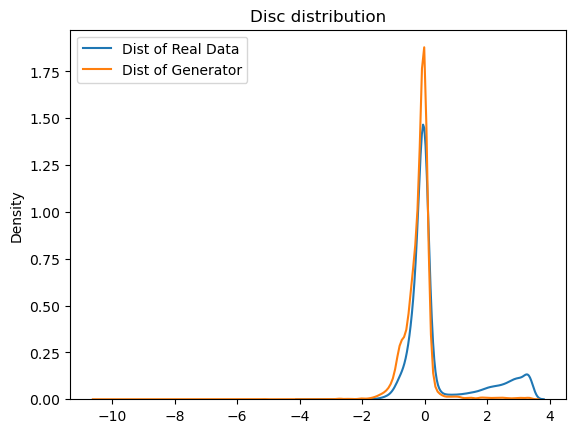

Epoch:225, LossD/G:1.2732/-0.6289


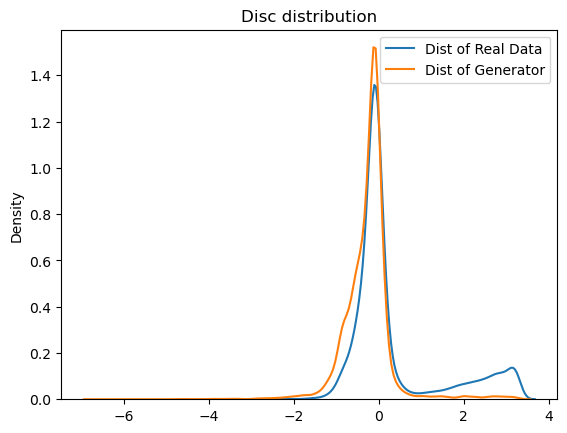

Epoch:250, LossD/G:1.2744/-0.6252


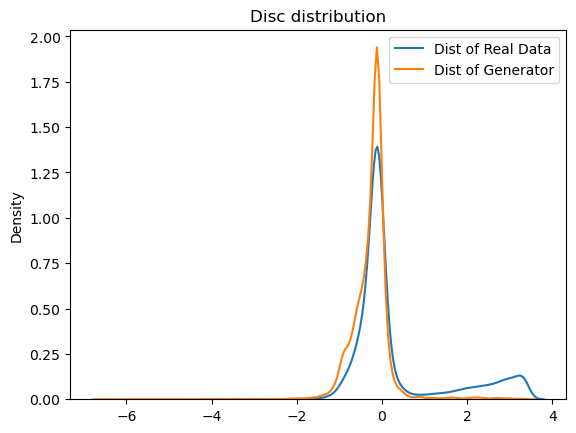

Epoch:275, LossD/G:1.2757/-0.6255


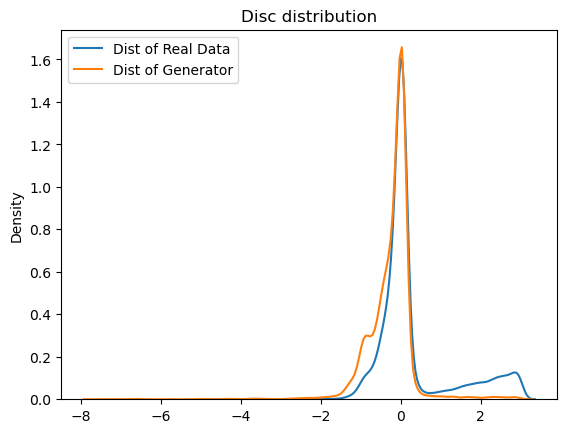

Epoch:300, LossD/G:1.2745/-0.6218


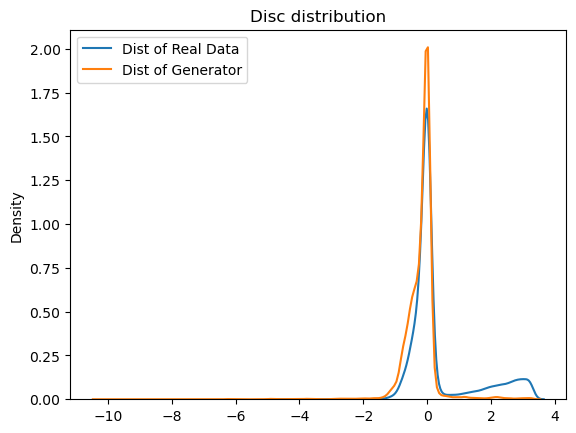

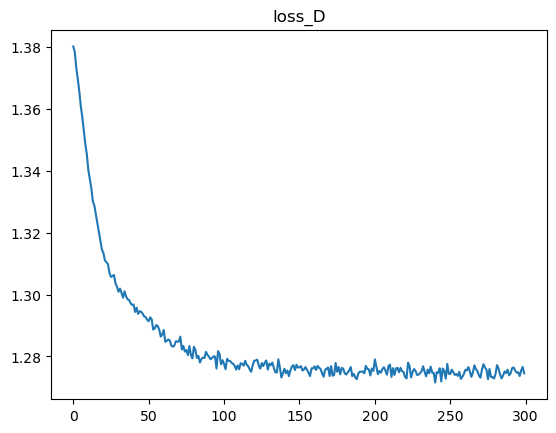

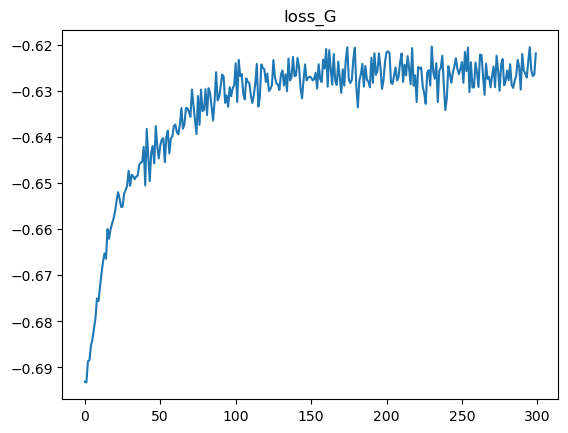

Time for running this cell: 595.93s


In [208]:
s0 = time.time()
f0 = fgan(2, 0.0, device, epsilon=1e-5)
f0.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f0.data_init(batch_size = 100, 
             data = torch.from_numpy( XData[np.random.shuffle(np.arange(50000))].squeeze() ).float() )
f0.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f0.optimizer_init(lr_d=0.01, lr_g=0.1, d_steps=3, g_steps=1)
f0.fit(floss='js', epochs=300, avg_epochs=20,
       verbose=25, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Generator $G(z) = W^T z + b,\ z\sim \mathcal{N}(0,I_p)$, we show $W$ and $b$ estimated here and calculate covariance $\Sigma = W^TW$:

In [209]:
W = f0.netG.weight.detach().cpu().numpy()
print(W)

[[ 1.058357   -0.00948619]
 [-0.35472116 -1.1561215 ]]


In [210]:
b = f0.netG.bias.detach().cpu().numpy()
print(b)

[0.1395536  0.14170226]


In [211]:
print(W.T @ W)

[[1.2459466  0.40006098]
 [0.40006098 1.3367069 ]]


We can see the estimation of the mean and $\Sigma$ is affected in some degree.

Now we implement the outlier detection. We start with the view of Generator, using statistical method. We roughly use $\| (x-b)^TW^{-1}\|_2 > 3.5$ as the standard of classifying outliers.

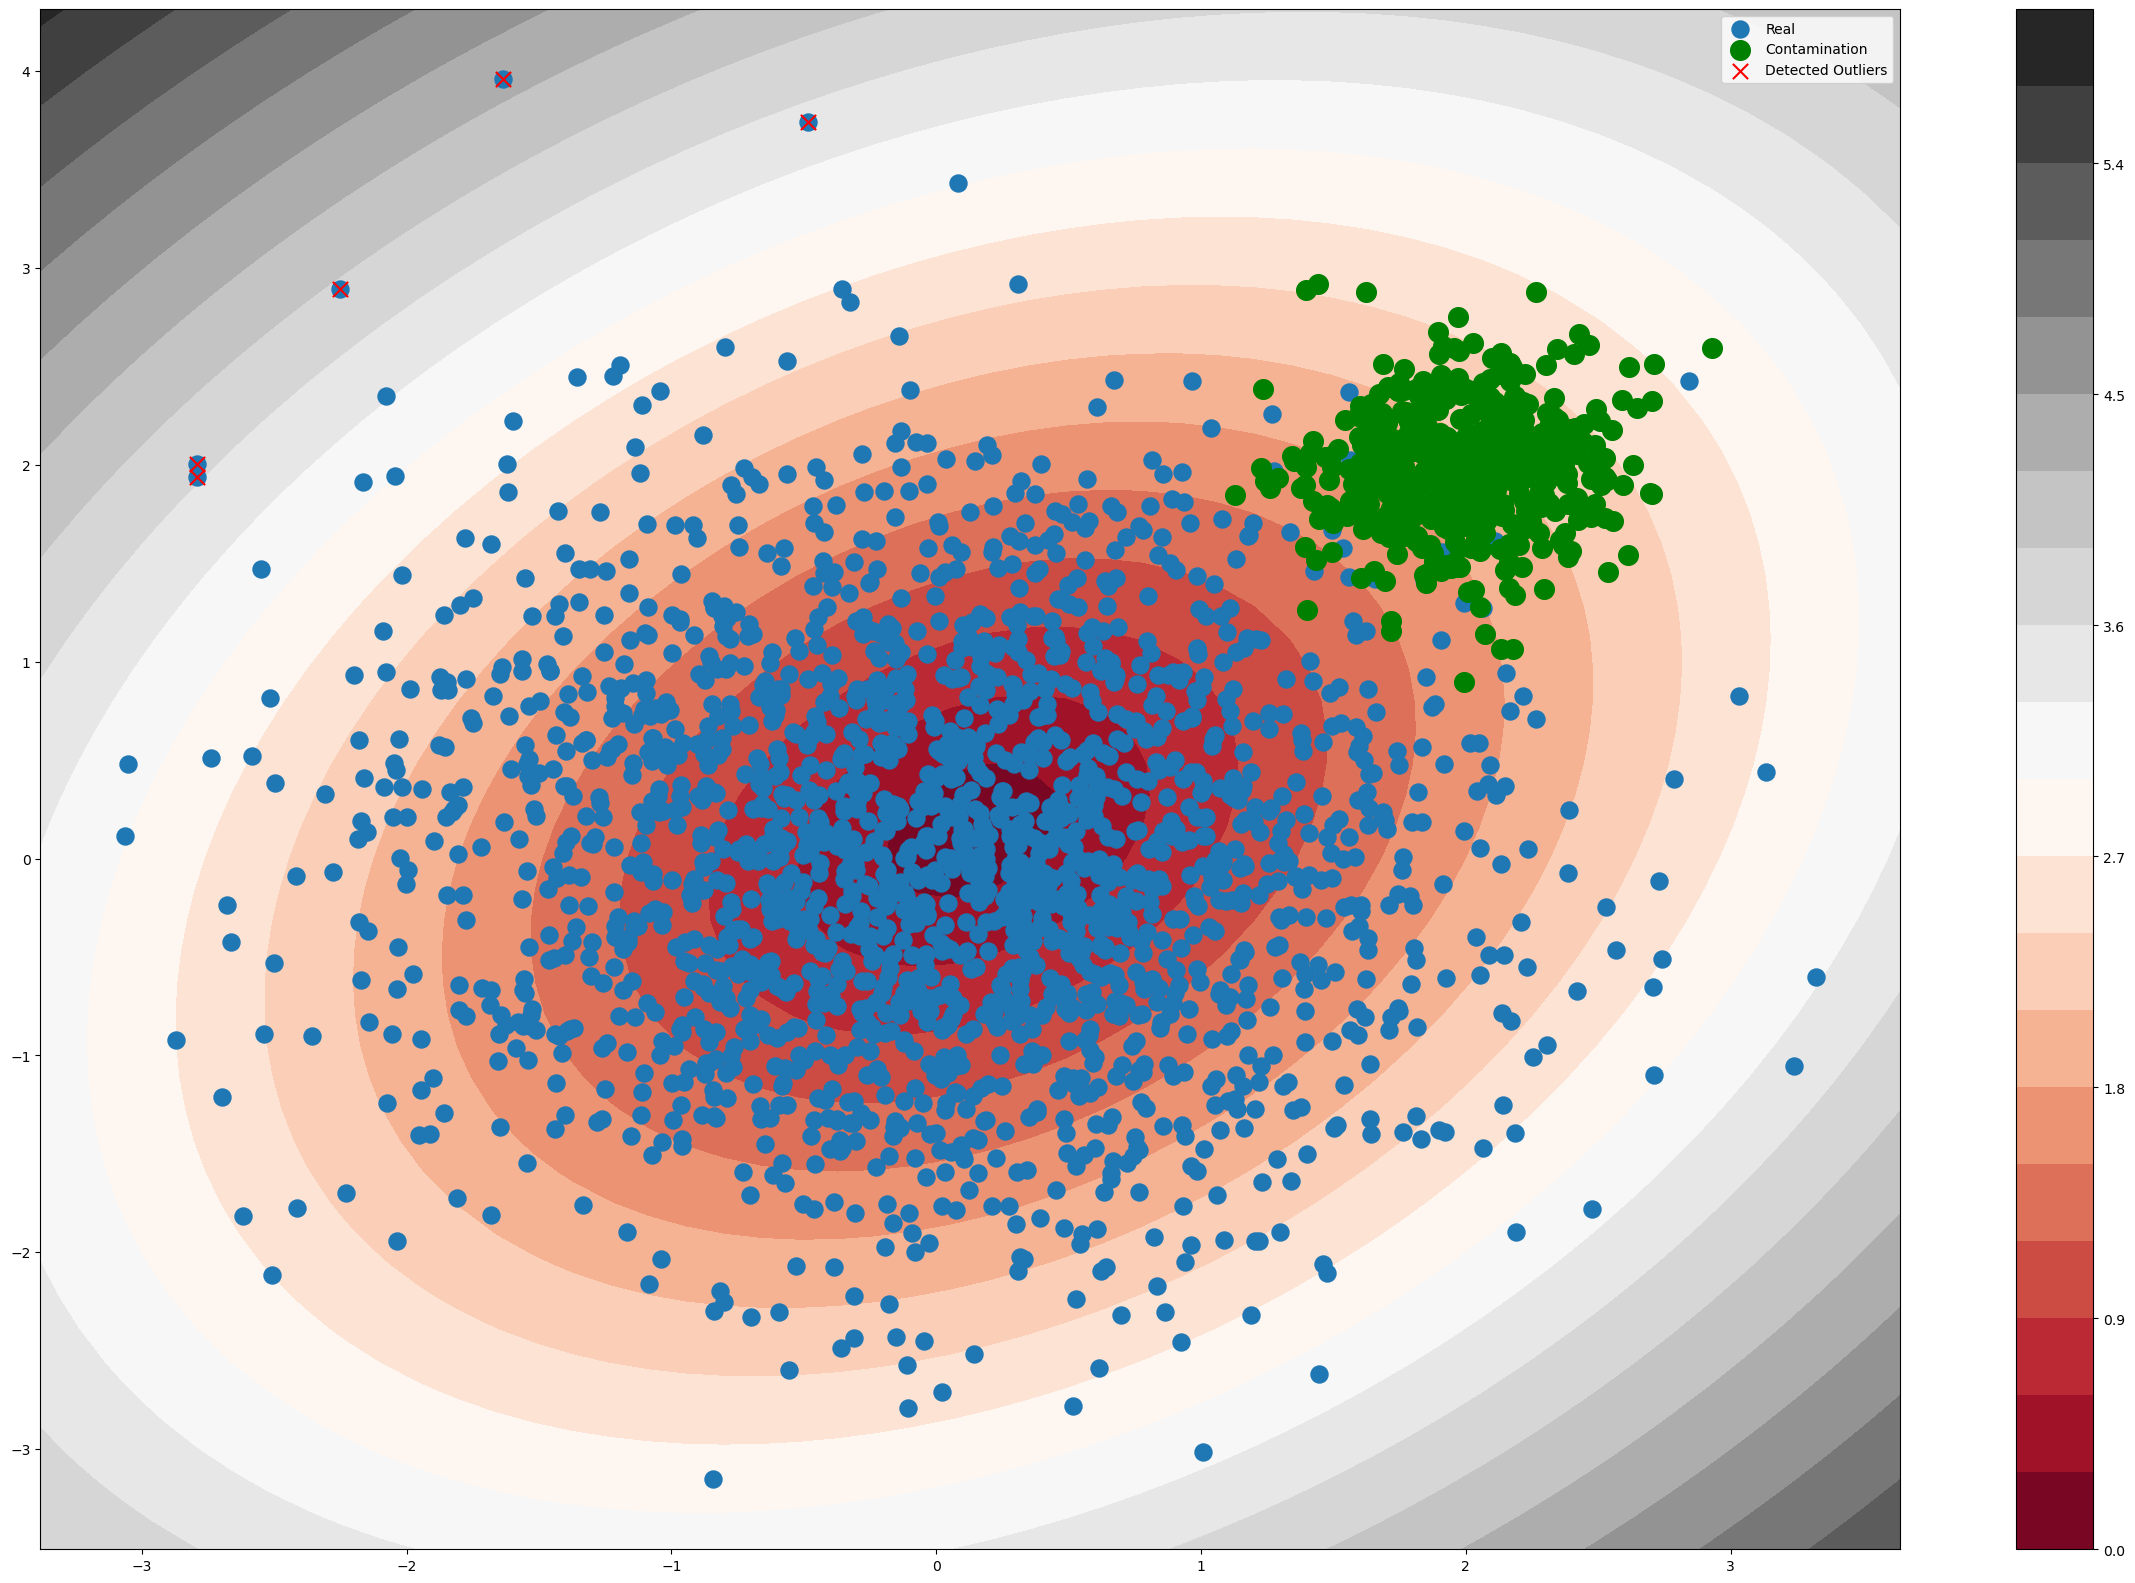

In [212]:
## Confident interval
W_inv = np.linalg.inv(W)
XTest = np.concatenate( (XReal[:2000], XCont[:500]), axis=0 )
## Statistical score for generator samples
statscore = np.linalg.norm((XTest-b) @ W_inv, axis=1)
outlierIndex = (statscore > 3.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = np.linalg.norm((np.array([x, y])-b) @ W_inv)
plt.contourf(X, Y, Z, 20, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:2000], XCont[:500]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

For the method of Generator, it fails in this case. The inference based on prior knowledge of distribution just can not handle non-seperable well.

Next, we take the view of Discriminator. Again, We set $\log \dfrac{p(x)}{q(x)} < -2$ or $\log \dfrac{p(x)}{q(x)} > 0.5$ to be outliers.

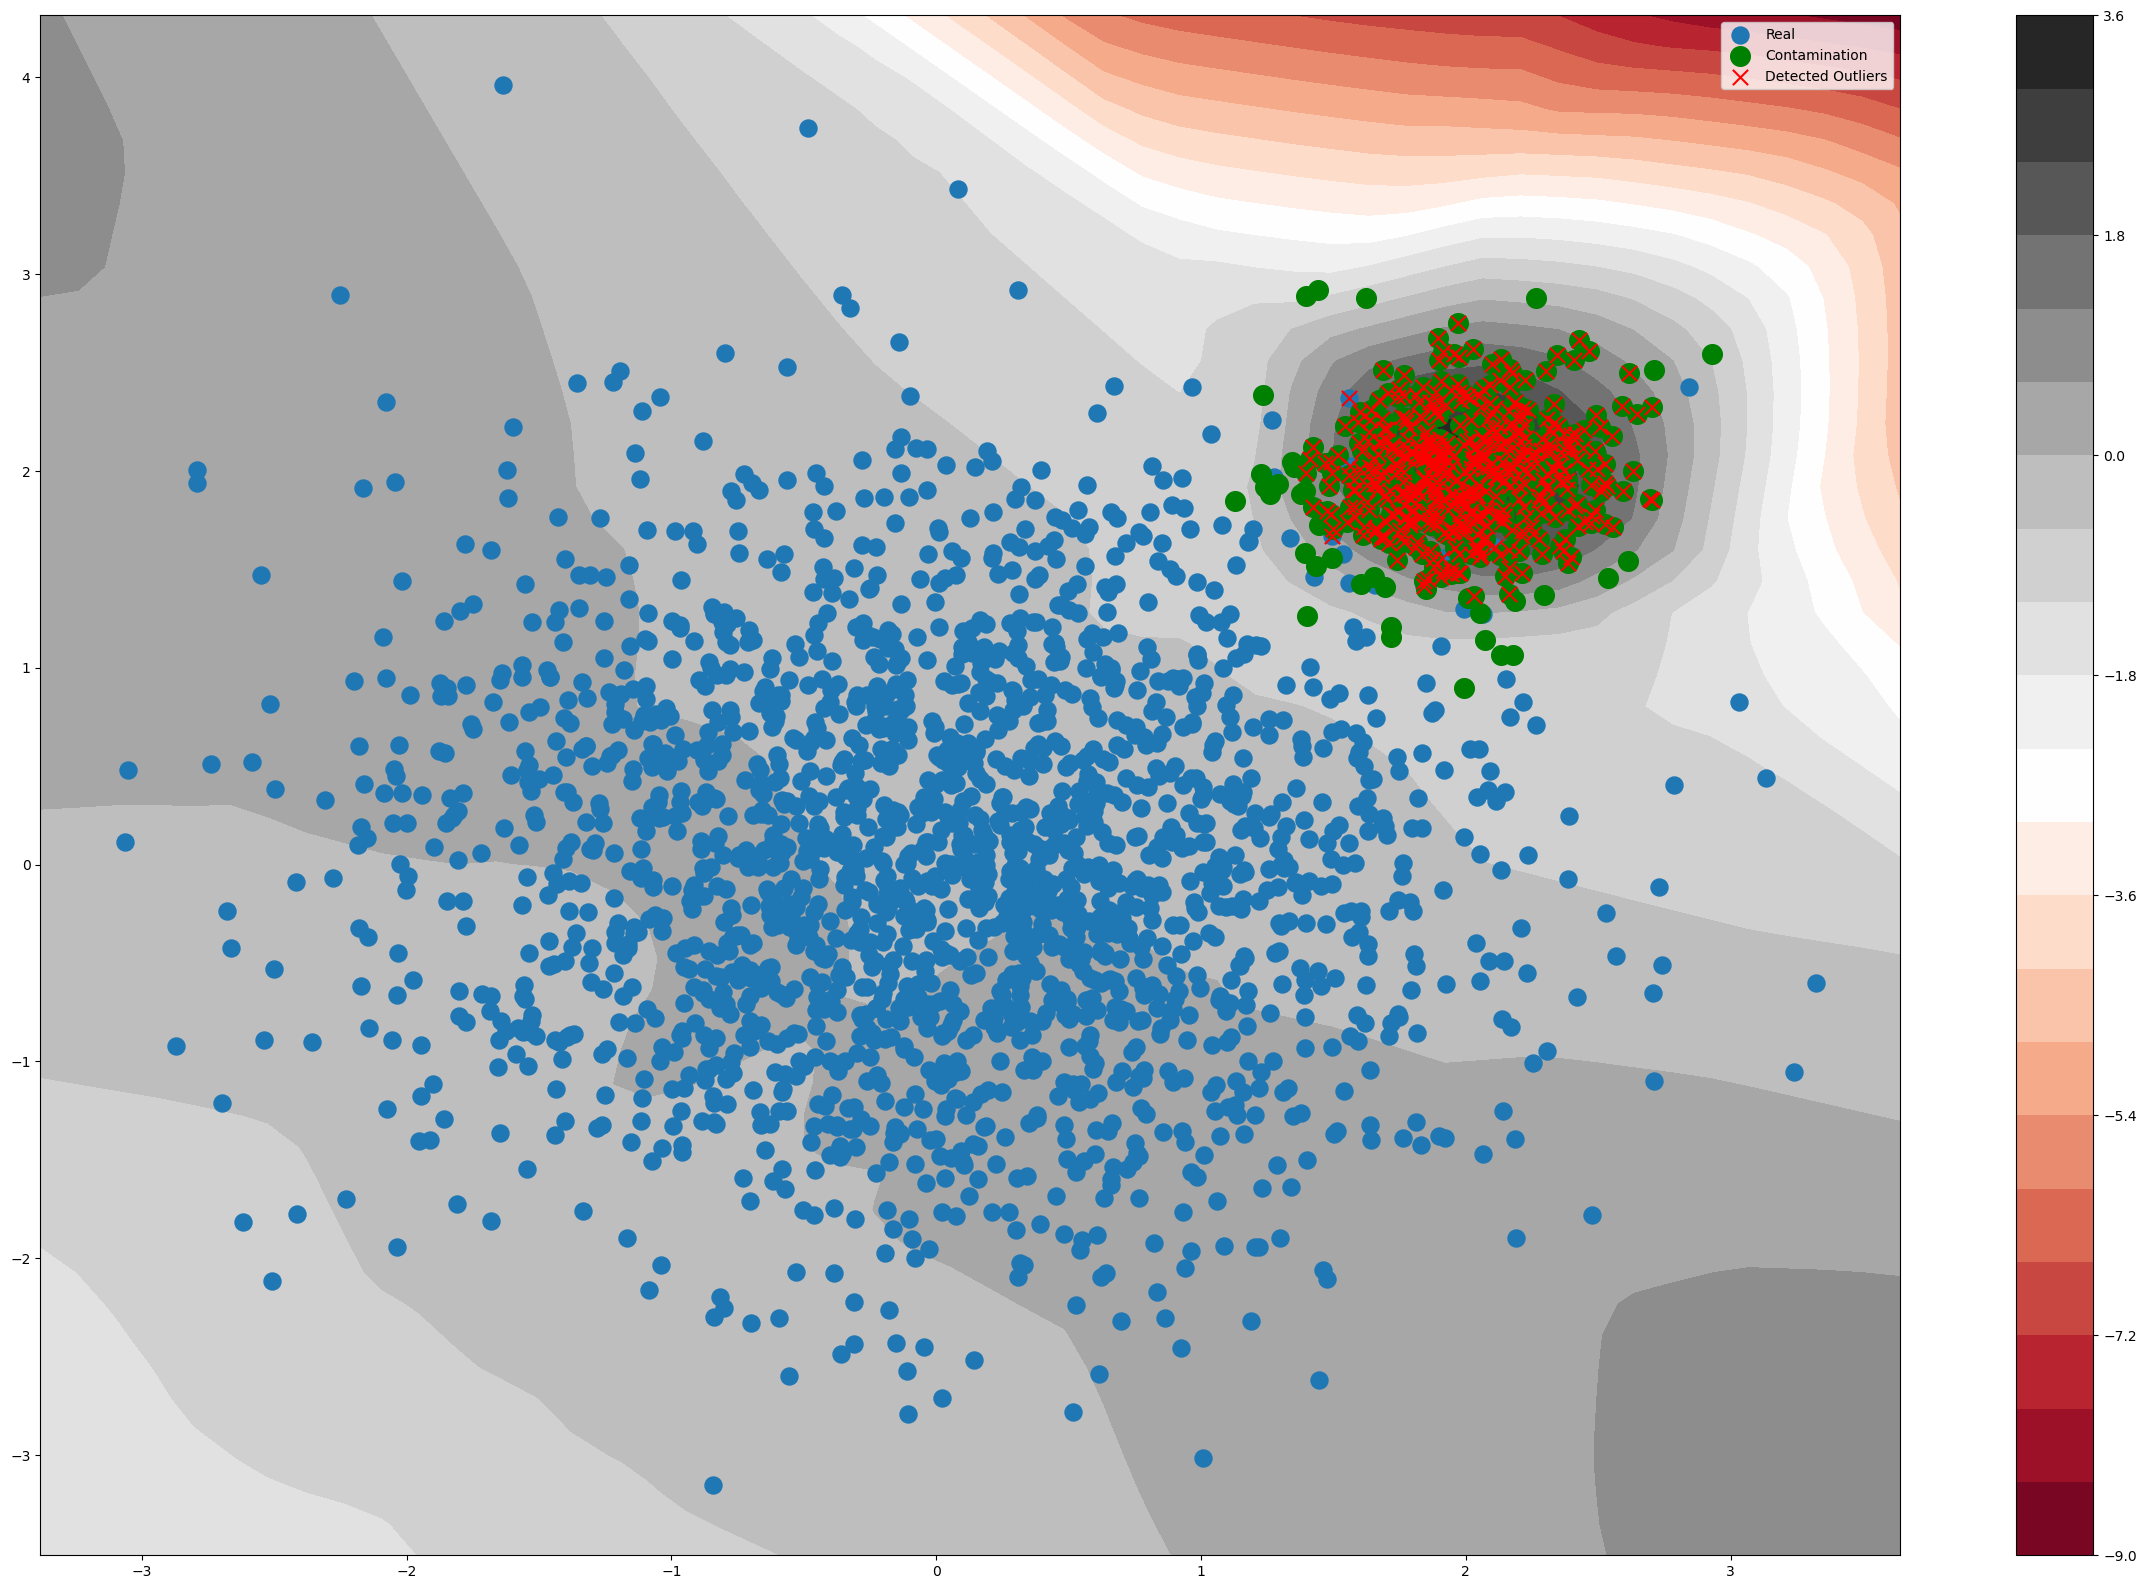

In [213]:
## G-score for 
XTest = torch.from_numpy( np.concatenate( (XReal[:2000], XCont[:500]), axis=0 ) ).float()
## Discriminator score for generator samples
Dscore = f0.netD(XTest.to(device))[1].detach().cpu().numpy()
outlierIndex = (Dscore < -2) | (Dscore > 0.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = f0.netD(torch.tensor([x, y]).to(device).float())[1].detach().cpu().numpy()
plt.contourf(X, Y, Z, 20, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:2000], XCont[:500]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

It is just gorgeous! The detection by Discriminator keeps stable even in this case. We guess apart from contamination ratio, other factors do not influence a lot on the best thresholds of Discriminator.

In [227]:
# a small test to rationalize stability of D(x) which claimed by us to be like log p(x)/q(x)
Gsamples = f0.netG( torch.randn(100000, f0.p).to(device) )
DGscore = f0.netD(Gsamples)[1].detach().cpu().numpy()
# E_Q[p(X)/q(X)] = 1, the value should be close to 1.
np.mean(np.exp(DGscore))

1.0054243

## 4.4 Experiment Four

Test for prior knowledge of true distribution is wrong.

We generate data under Huber Contamination model:
$$ x_i \sim 0.8\ t_3(0) + 0.2 {\mathcal{N}}(5*1_p, 2*I_p)$$
with $N=50000$ samples and dimension $p=2$.

We still select JS-GAN to fit the samples, the estimator is defined by:

$$\hat{\theta} = \arg\!\inf_{\eta \in \mathbb{R}^p, \Sigma\succeq 0} \sup_{D\in \mathcal{D}}\left[\dfrac{1}{n}\sum_{i=1}^{n}\log D(X_i) + \mathbf{E}_{{\mathcal{N}}(\eta,\Sigma)}\log (1-D(X_i))\right] + \log 4$$

Here $D(x) = e^{T(x)}$.

In [265]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

XReal = np.random.standard_t(df=3, size=(40000, 2))
XCont = np.random.normal(loc=5., scale=2., size=(10000, 2))
XData = np.concatenate( (XReal, XCont), axis=0 )
print(XData.shape)

(50000, 2)


Epoch:25, LossD/G:1.2100/-0.5776


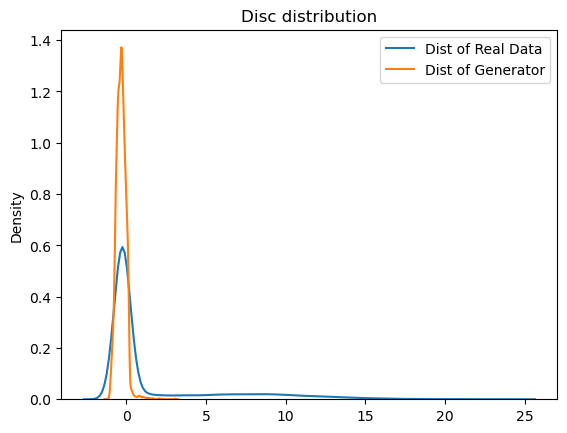

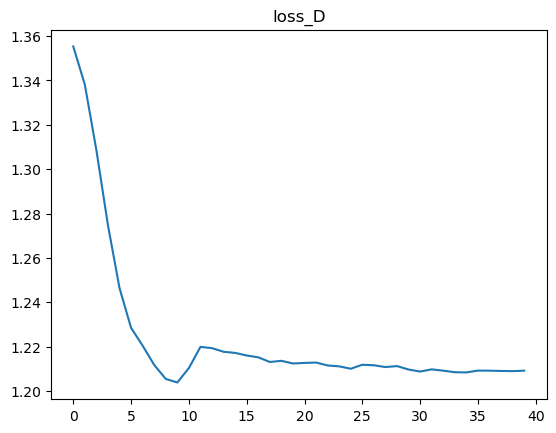

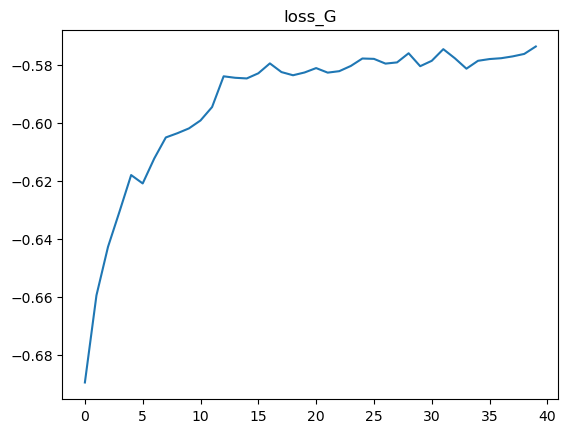

Time for running this cell: 80.41s


In [266]:
s0 = time.time()
f0 = fgan(2, 0.0, device, epsilon=1e-5)
f0.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f0.data_init(batch_size = 100, 
             data = torch.from_numpy( XData[np.random.shuffle(np.arange(50000))].squeeze() ).float() )
f0.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f0.optimizer_init(lr_d=0.01, lr_g=0.1, d_steps=3, g_steps=1)
f0.fit(floss='js', epochs=40, avg_epochs=20,
       verbose=25, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Generator $G(z) = W^T z + b,\ z\sim \mathcal{N}(0,I_p)$, we show $W$ and $b$ estimated here and calculate covariance $\Sigma = W^TW$:

In [267]:
W = f0.netG.weight.detach().cpu().numpy()
print(W)

[[-1.0058182 -1.0783272]
 [-1.0025709  0.93044  ]]


In [268]:
b = f0.netG.bias.detach().cpu().numpy()
print(b)

[0.06555559 0.06198055]


In [269]:
print(W.T @ W)

[[2.0168188  0.15176912]
 [0.15176912 2.0285082 ]]


We can see the estimation of mean and $\Sigma$ are quite good.

Now we implement the outlier detection in above three ways. We start with the view of Generator, using statistical method. We roughly use $\| (x-b)^TW^{-1}\|_2 > 3.5$ as the standard of classifying outliers.

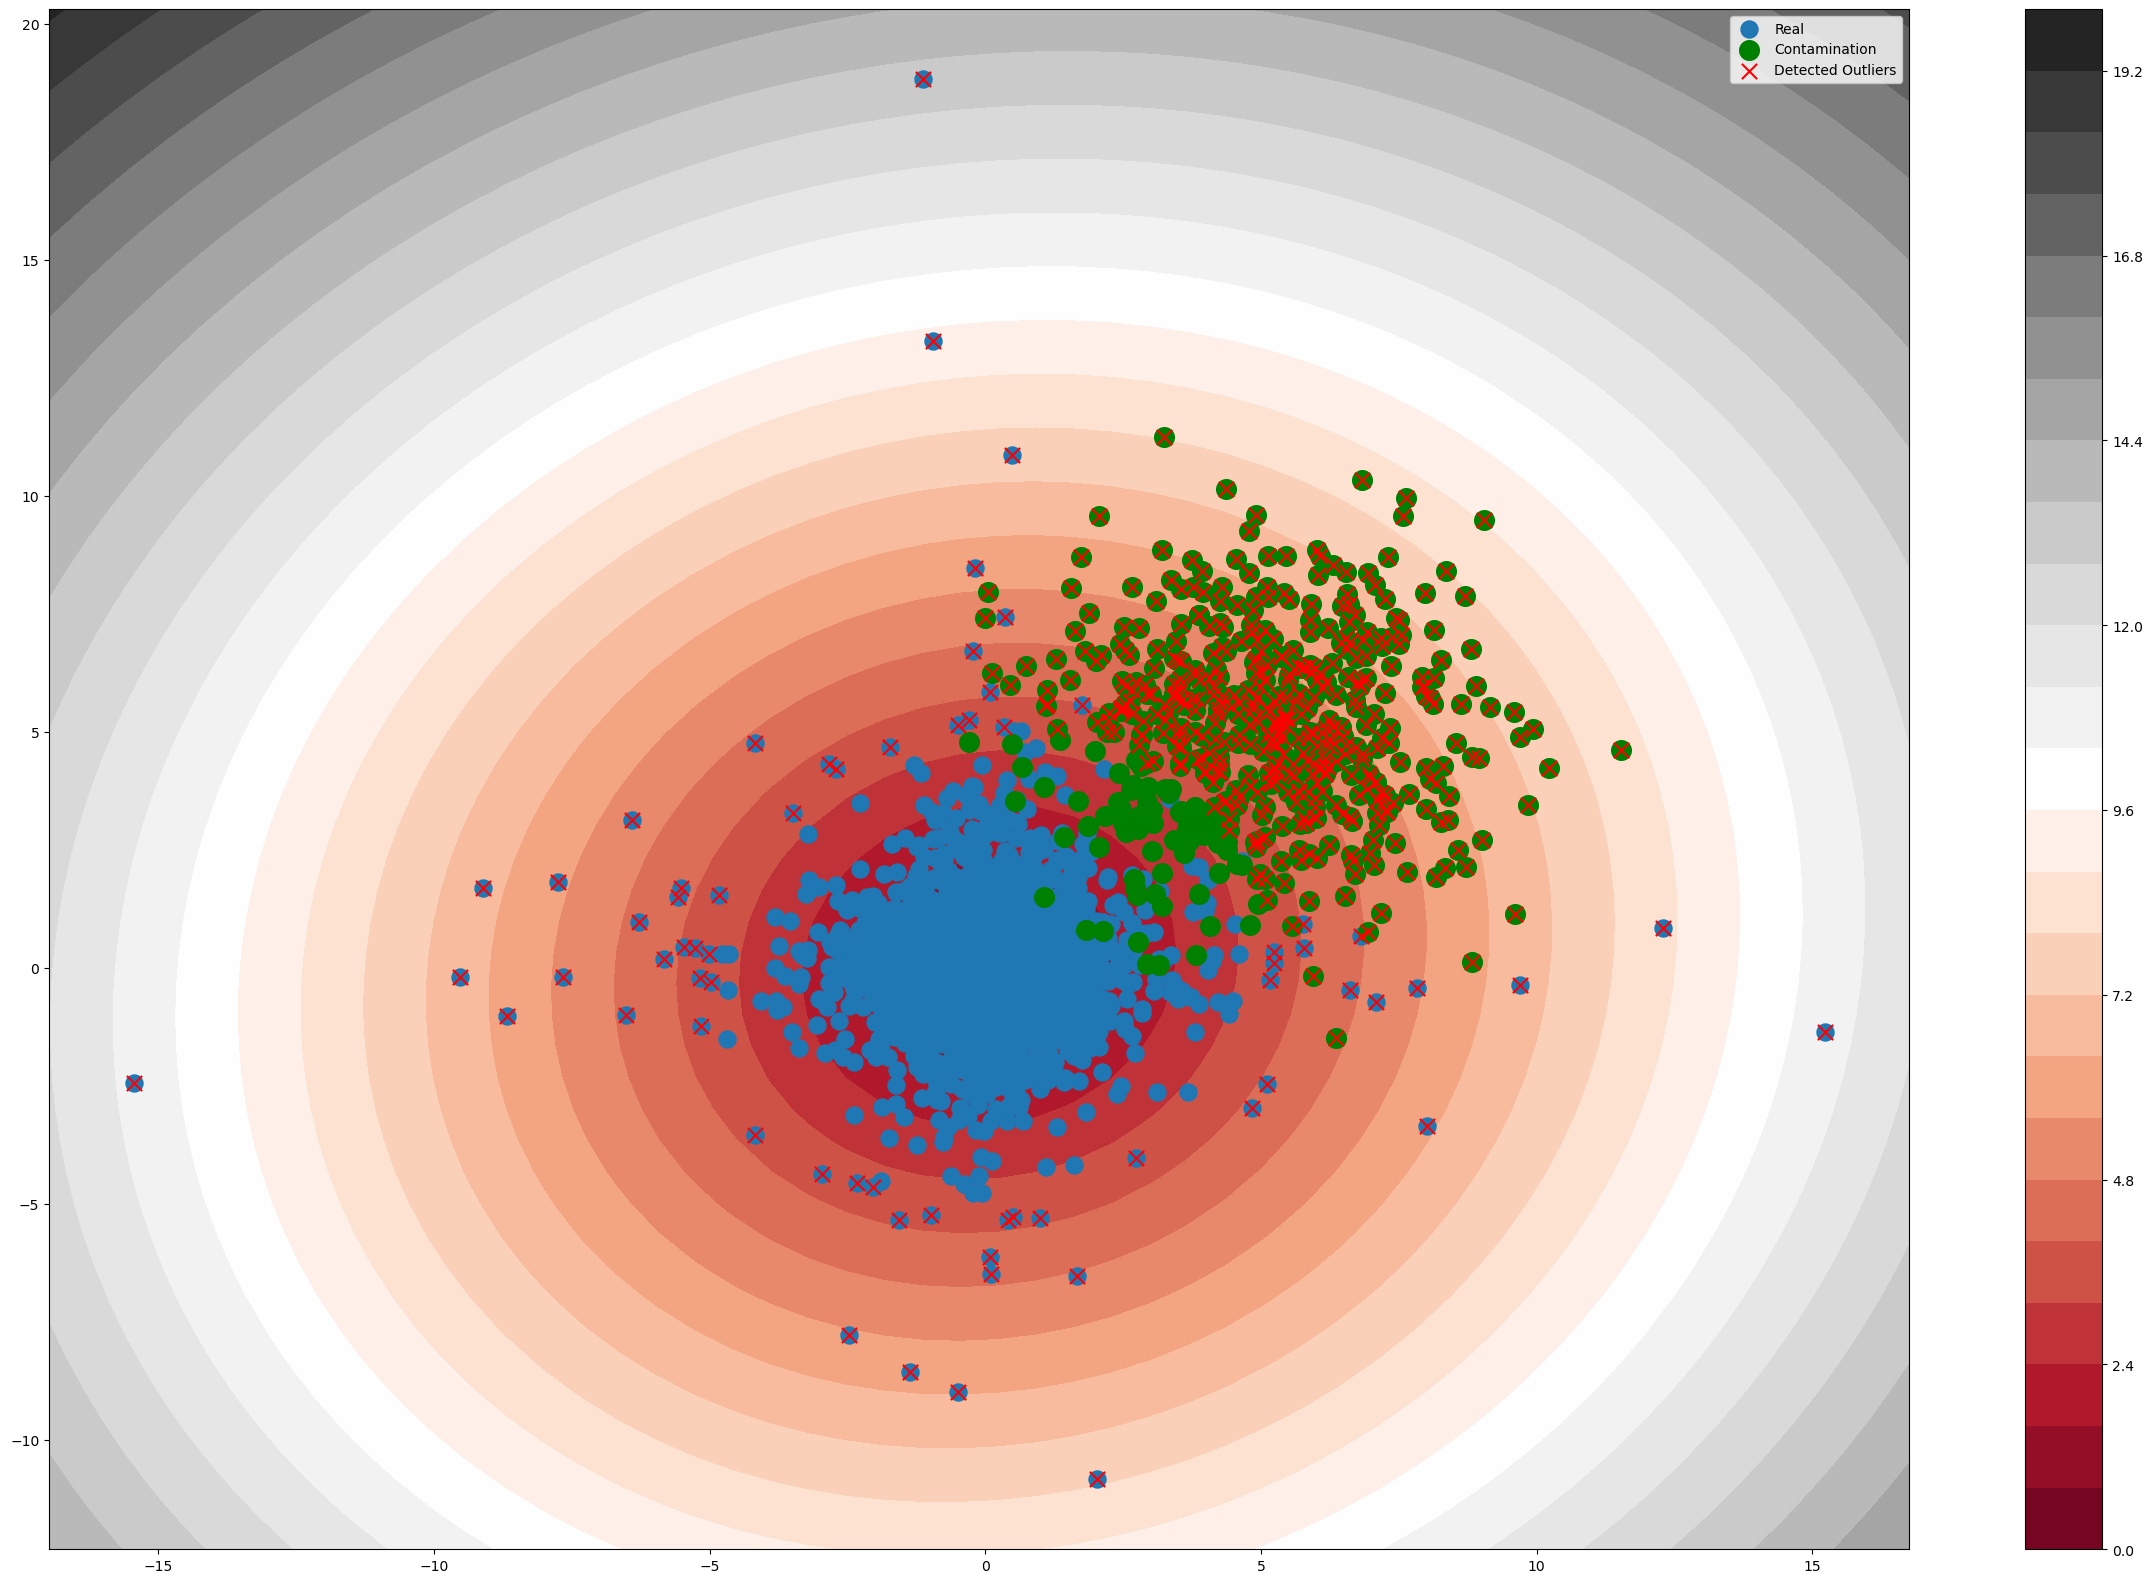

In [270]:
## Confident interval
W_inv = np.linalg.inv(W)
XTest = np.concatenate( (XReal[:2000], XCont[:500]), axis=0 )
## Statistical score for generator samples
statscore = np.linalg.norm((XTest-b) @ W_inv, axis=1)
outlierIndex = (statscore > 3.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = np.linalg.norm((np.array([x, y])-b) @ W_inv)
plt.contourf(X, Y, Z, 30, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:2000], XCont[:500]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

It is an OK job.

Next, we take the view of Discriminator. Again, We set $\log \dfrac{p(x)}{q(x)} < -2$ or $\log \dfrac{p(x)}{q(x)} > 0.5$ to be outliers.

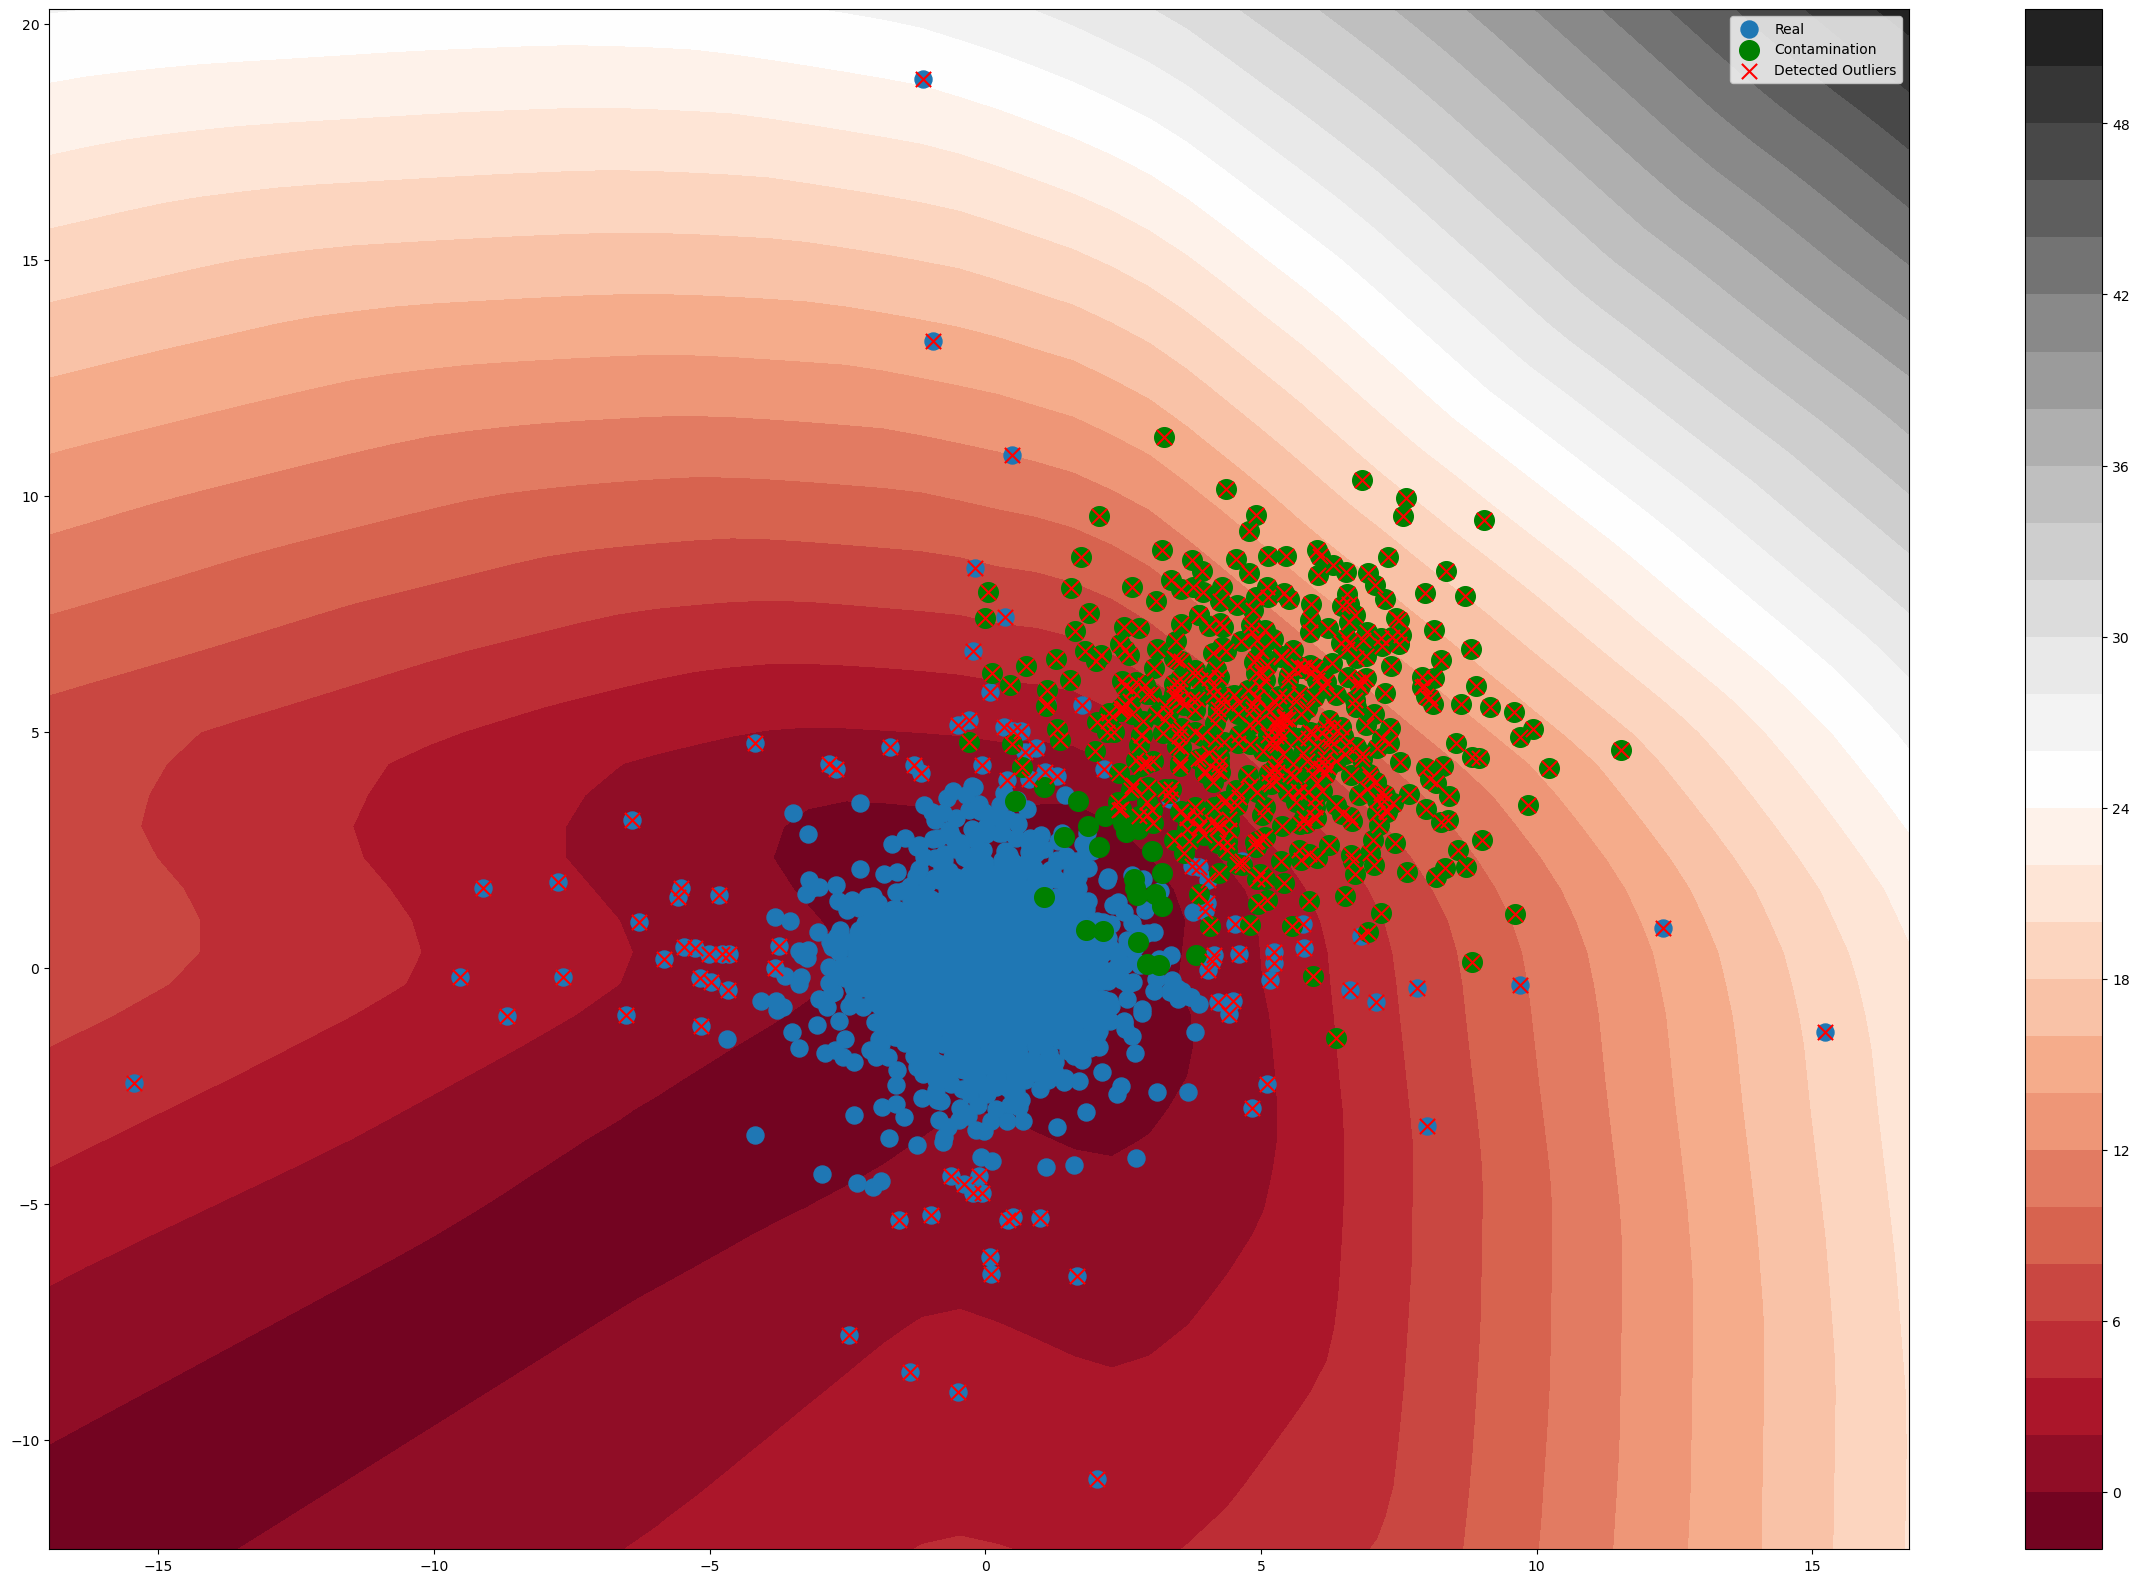

In [271]:
## G-score for 
XTest = torch.from_numpy( np.concatenate( (XReal[:2000], XCont[:500]), axis=0 ) ).float()
## Discriminator score for generator samples
Dscore = f0.netD(XTest.to(device))[1].detach().cpu().numpy()
outlierIndex = (Dscore < -2) | (Dscore > 0.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = f0.netD(torch.tensor([x, y]).to(device).float())[1].detach().cpu().numpy()
plt.contourf(X, Y, Z, 30, cmap='RdGy')

ax.scatter( XReal[:2000, 0], XReal[:2000, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:500, 0], XCont[:500, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:2000], XCont[:500]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

Again, it is better than Generator in accruracy. It can be seen that since our assumption on real distribution is false, we take many normal data as outliers. This is the price we pay for the bad prior knowledge.

## 4.5 Experiment Five

Test for different contamination rate.

We generate data under Huber Contamination model:
$$ x_i \sim 0.75 {\mathcal{N}}(0,I_p) + 0.25 {\mathcal{N}}(5*1_p, 2*I_p),$$
with $N=50000$ samples and dimension $p=2$.

We select JS-GAN to fit the samples, the estimator is defined by:

$$\hat{\theta} = \arg\!\inf_{\eta \in \mathbb{R}^p, \Sigma\succeq 0} \sup_{D\in \mathcal{D}}\left[\dfrac{1}{n}\sum_{i=1}^{n}\log D(X_i) + \mathbf{E}_{{\mathcal{N}}(\eta,\Sigma)}\log (1-D(X_i))\right] + \log 4$$

Here $D(x) = e^{T(x)}$.

In [285]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

XReal = np.random.normal(loc=0., scale=1., size=(37500, 2))
XCont = np.random.normal(loc=5., scale=2., size=(12500, 2))
XData = np.concatenate( (XReal, XCont), axis=0 )
print(XData.shape)

(50000, 2)


Epoch:25, LossD/G:1.1046/-0.5596


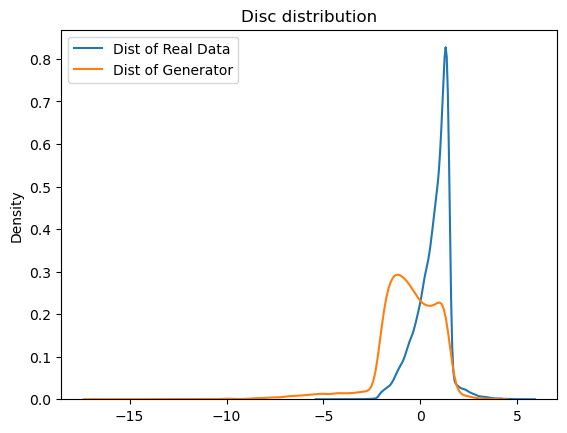

Epoch:50, LossD/G:1.0974/-0.5627


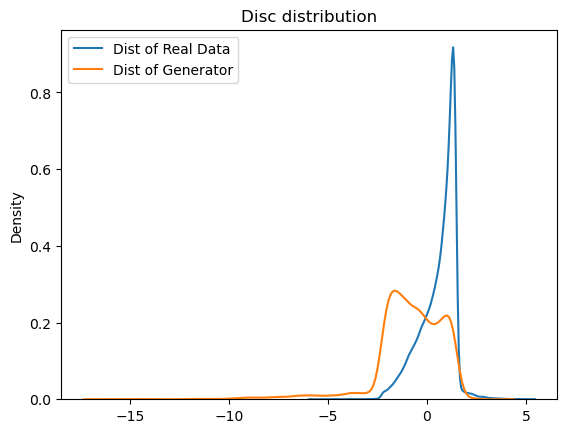

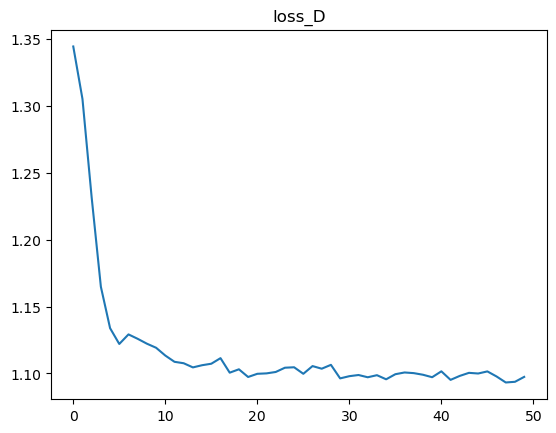

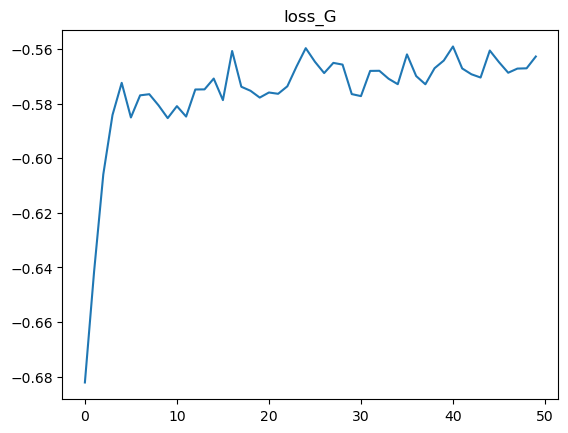

Time for running this cell: 100.78s


In [286]:
s0 = time.time()
f0 = fgan(2, 0.0, device, epsilon=1e-5)
f0.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f0.data_init(batch_size = 100, 
             data = torch.from_numpy( XData[np.random.shuffle(np.arange(50000))].squeeze() ).float() )
f0.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f0.optimizer_init(lr_d=0.01, lr_g=0.1, d_steps=3, g_steps=1)
f0.fit(floss='js', epochs=50, avg_epochs=20,
       verbose=25, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Generator $G(z) = W^T z + b,\ z\sim \mathcal{N}(0,I_p)$, we show $W$ and $b$ estimated here and calculate covariance $\Sigma = W^TW$:

In [287]:
W = f0.netG.weight.detach().cpu().numpy()
print(W)

[[-2.4520328  -2.5817544 ]
 [-1.0735772   0.68330795]]


In [288]:
b = f0.netG.bias.detach().cpu().numpy()
print(b)

[1.5700322 1.568784 ]


In [289]:
print(W.T @ W)

[[7.165033  5.5969625]
 [5.5969625 7.1323657]]


We can see the estimation is very bad.

Now we implement the outlier detection in above three ways. We start with the view of Generator, using statistical method. We roughly use $\| (x-b)^TW^{-1}\|_2 > 3.5$ as the standard of classifying outliers.

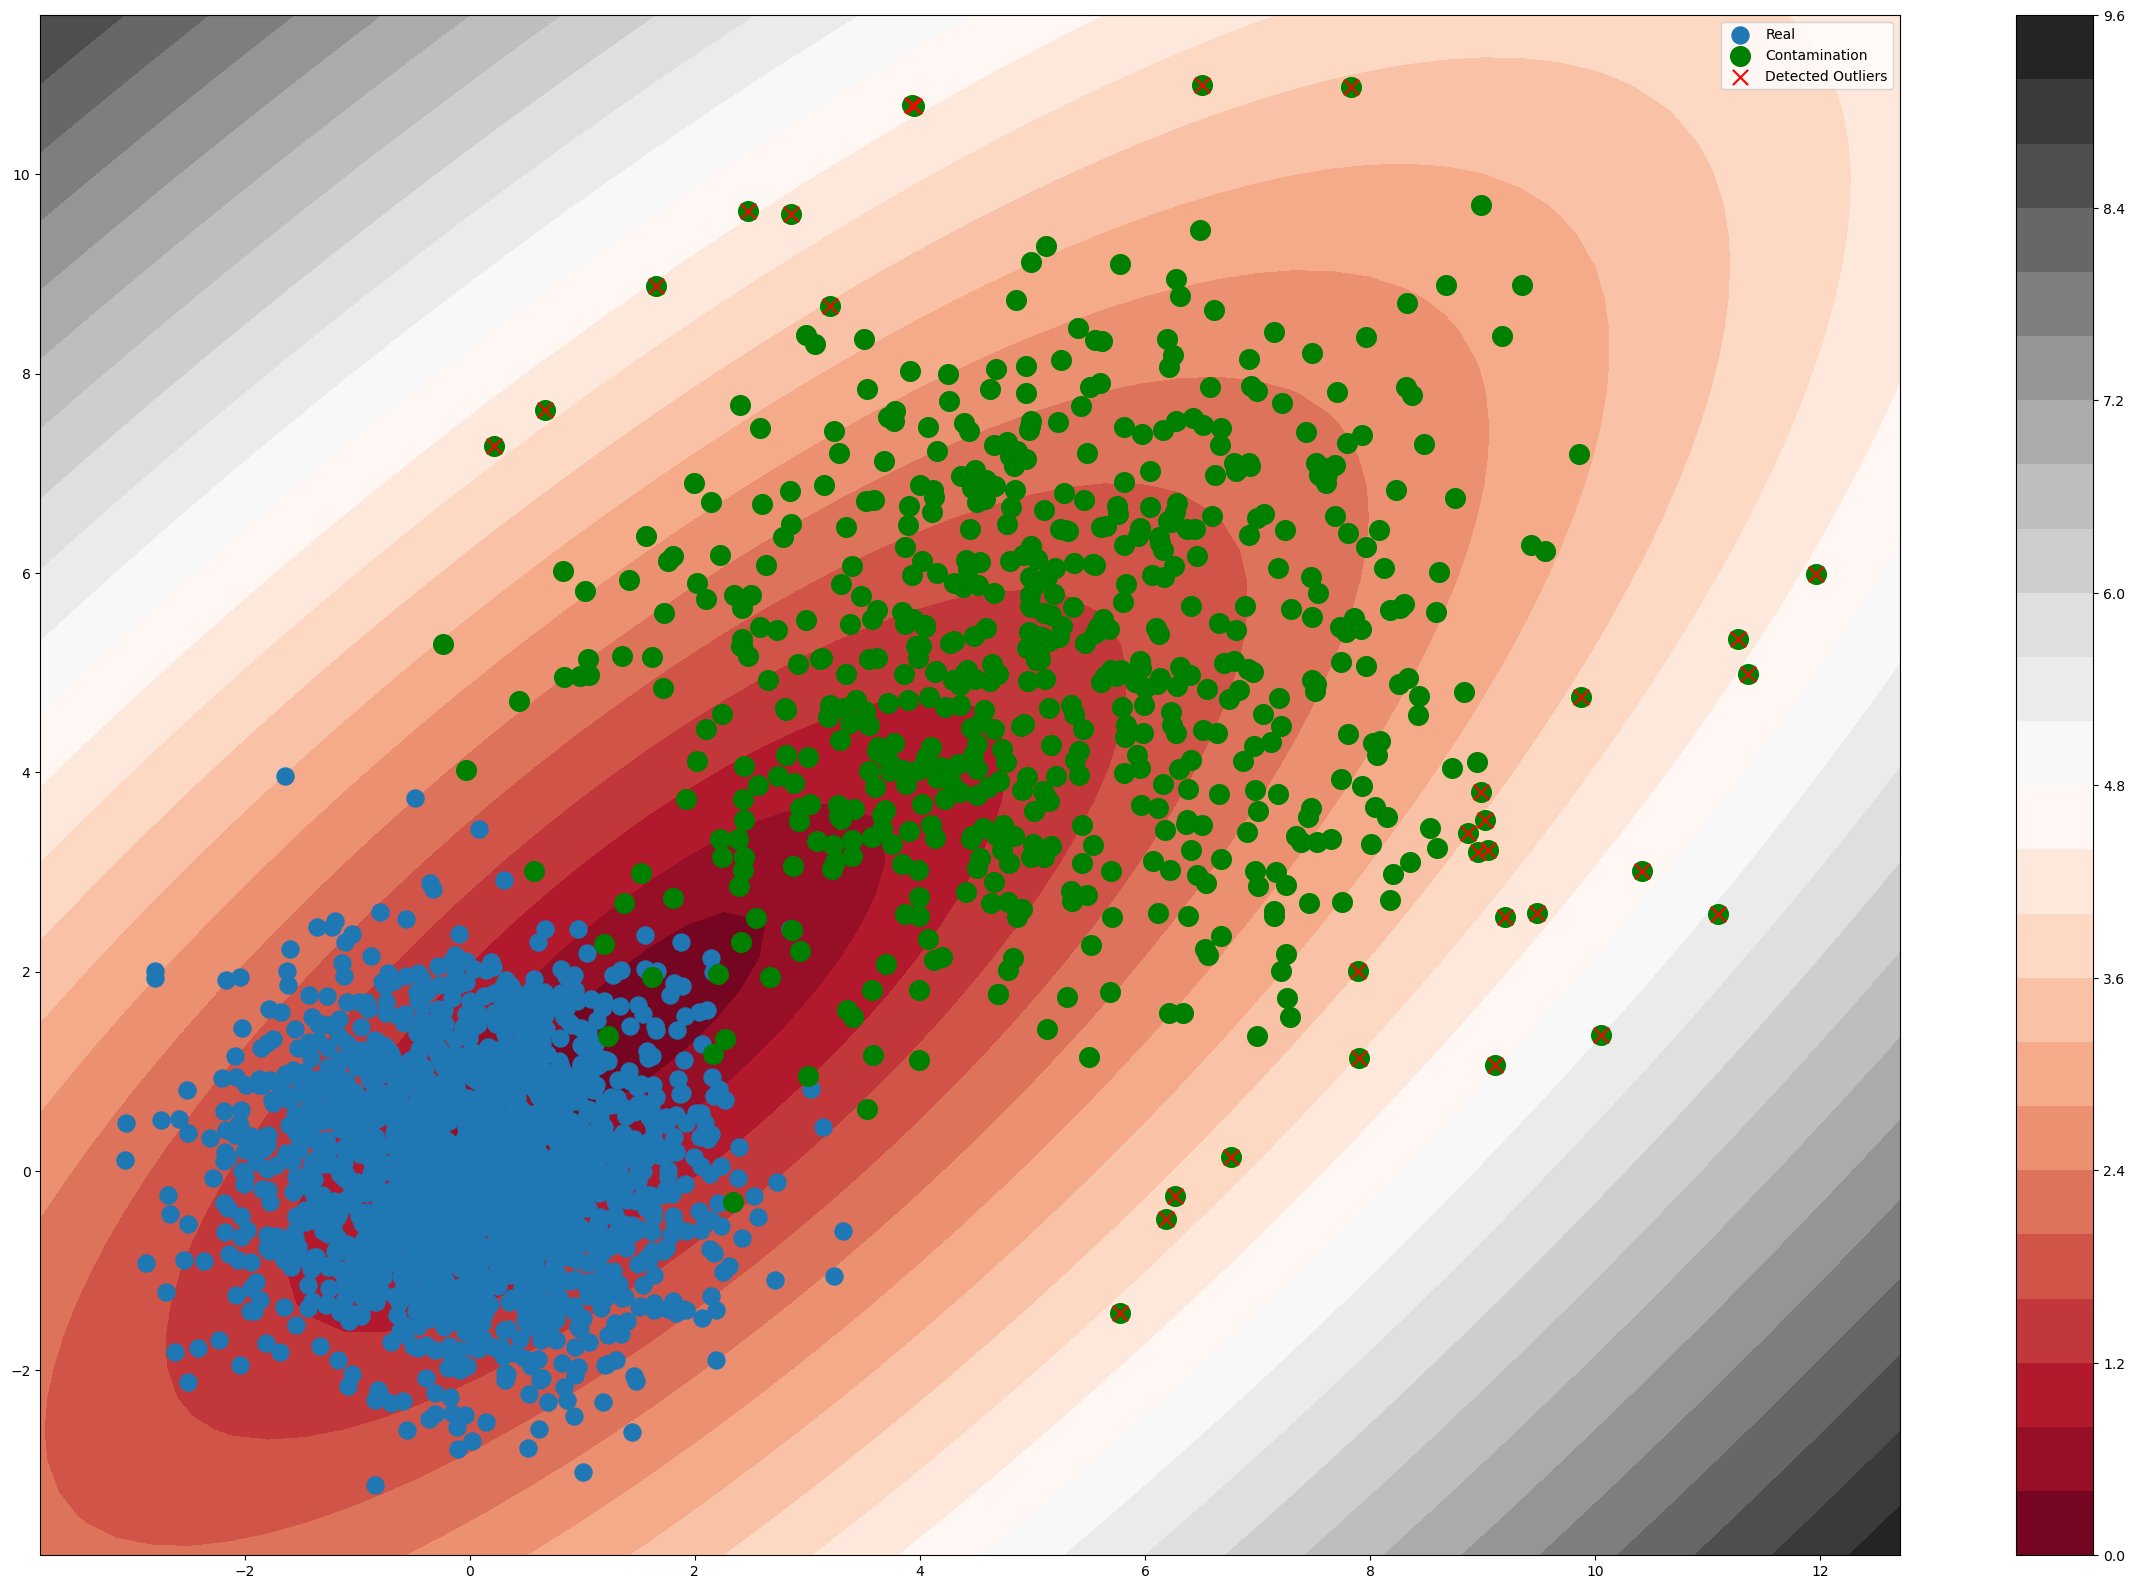

In [290]:
## Confident interval
W_inv = np.linalg.inv(W)
XTest = np.concatenate( (XReal[:1875], XCont[:625]), axis=0 )
## Statistical score for generator samples
statscore = np.linalg.norm((XTest-b) @ W_inv, axis=1)
outlierIndex = (statscore > 3.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:1875, 0], XReal[:1875, 1], s=150, c="C0")
ax.scatter( XCont[:625, 0], XCont[:625, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = np.linalg.norm((np.array([x, y])-b) @ W_inv)
plt.contourf(X, Y, Z, 30, cmap='RdGy')

ax.scatter( XReal[:1875, 0], XReal[:1875, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:625, 0], XCont[:625, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:1875], XCont[:625]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

Next, we take a view of Discriminator. We set $\log \dfrac{p(x)}{q(x)} < -2$ or $\log \dfrac{p(x)}{q(x)} > 0.5$ to be outliers.

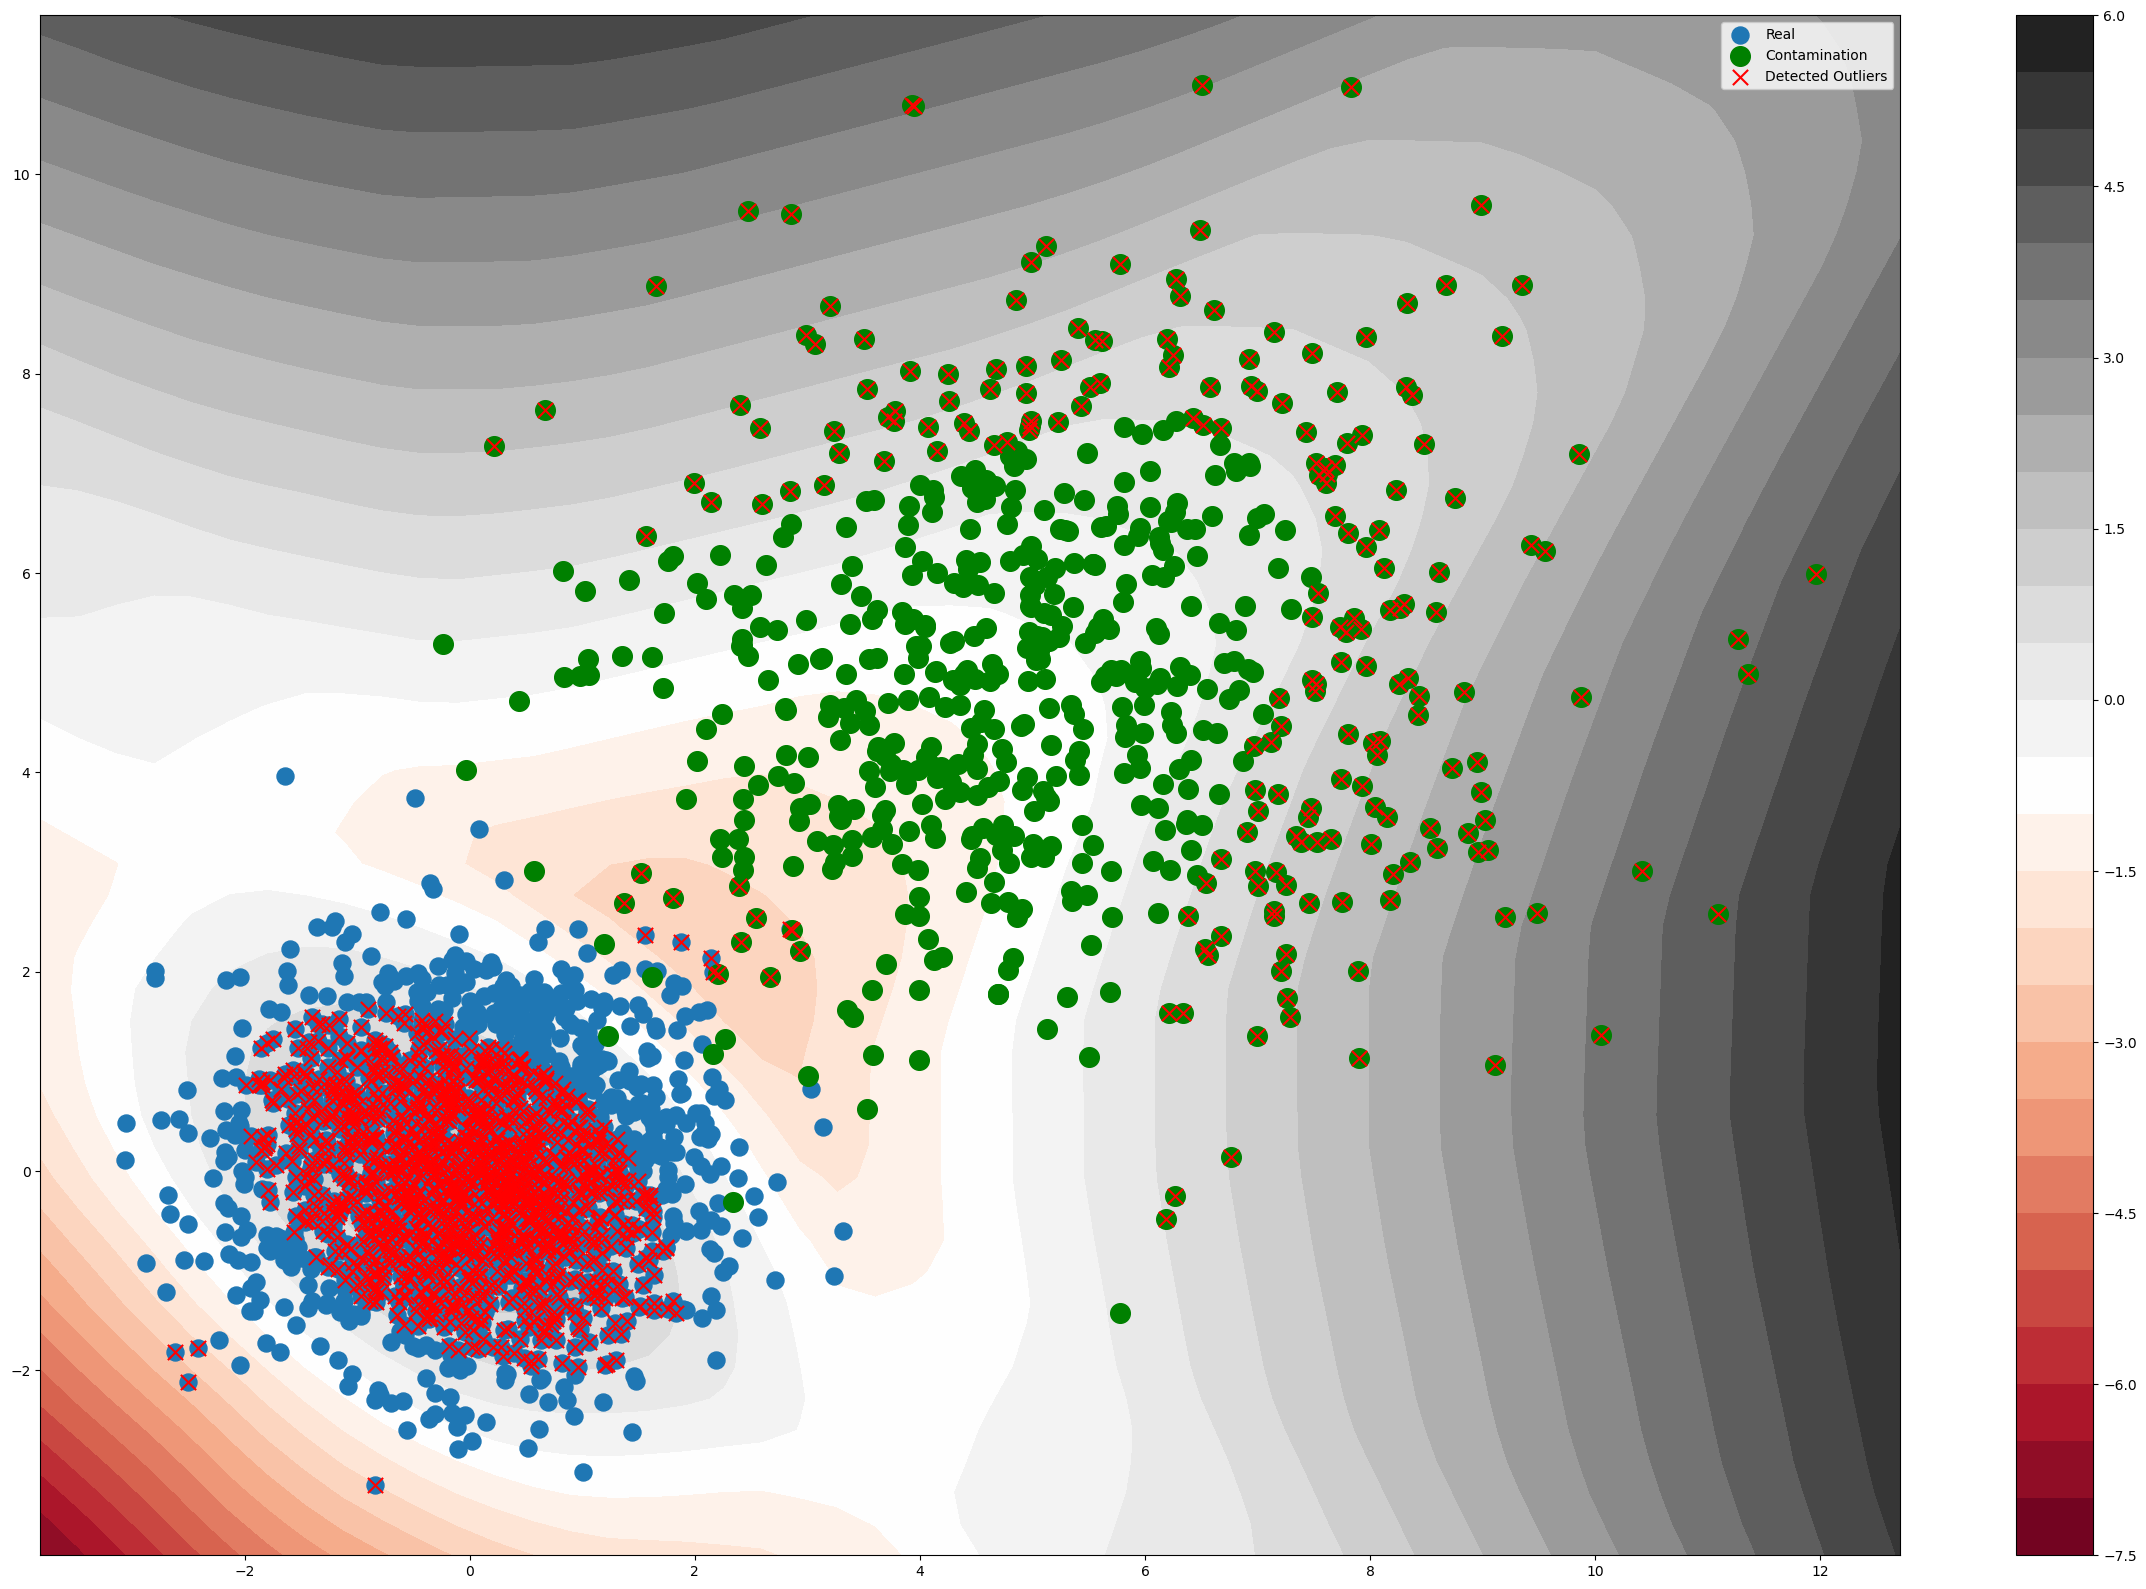

In [292]:
## G-score for 
XTest = torch.from_numpy( np.concatenate( (XReal[:1875], XCont[:625]), axis=0 ) ).float()
## Discriminator score for generator samples
Dscore = f0.netD(XTest.to(device))[1].detach().cpu().numpy()
outlierIndex = (Dscore < -2) | (Dscore > 0.5)
## visualize
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter( XReal[:1875, 0], XReal[:1875, 1], s=150, c="C0")
ax.scatter( XCont[:625, 0], XCont[:625, 1], s=200, c="g")
xleft, xright = plt.xlim()
yleft, yright = plt.ylim()
X = np.linspace(xleft, xright, 50)
Y = np.linspace(yleft, yright, 50)
Z = np.zeros((50,50))
for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        Z[iy, ix] = f0.netD(torch.tensor([x, y]).to(device).float())[1].detach().cpu().numpy()
plt.contourf(X, Y, Z, 30, cmap='RdGy')

ax.scatter( XReal[:1875, 0], XReal[:1875, 1], s=150, c="C0", label="Real")
ax.scatter( XCont[:625, 0], XCont[:625, 1], s=200, c="g", label="Contamination")
outliers = np.concatenate( (XReal[:1875], XCont[:625]) )[outlierIndex]
ax.scatter( outliers[:,0], outliers[:,1], marker="x", s=120, c="r", label="Detected Outliers" )
ax.legend()
plt.colorbar()
plt.show()

The Discriminator also crashed when we raise the contamination ratio to some level. There may exist a phase transition as contamination ratio changes. We should be more careful to implement this method in a highly corrupted dataset.

# 5. APPLICATION: Outlier Detection & Robust Cov Estimation in Stock Markets

We select 50 stocks during the period between 2015-01-01 and 2023-05-01 from Yahoo! Finance. 

In [296]:
corps_dict = {
         "Industrial":["LMT", "HON", "UNP", "BA", "MMM", "UPS"],
         "ConsDiscr":["AMZN", "HD", "MCD", "NKE", "SBUX", "LOW"],
         "ConsStaples":["WMT", "PG", "KO", "PEP", "COST", "PM"],
         "Energy":["XOM", "CVX", "COP", "KMI", "PSX", "EOG"],
         "HealthCare":["JNJ", "UNH", "MRK", "PFE", "ABT", "LLY"],
         "Financial":["JPM", "BAC", "WFC", "C", "AXP", "BLK"],
         "InfoTech":["MSFT", "AAPL", "V", "MA", "INTC", "CSCO"],
         "Material":["LIN", "ECL", "APD", "NEM", "SHW", "DD"],
         "Utility":["NEE", "D", "DUK", "SO", "AEP", "SRE"],
         "CommSevs": ["GOOG", "META", "VZ", "T", "DIS", "NFLX"]
            }

corps = []; sects = [] ## list of corporations and their corresponding sectors
for k, v in corps_dict.items():
    corps += v[:5]
    sects += [k] * 5

tks = yf.Tickers( " ".join(corps) )

START = "2015-01-01"; END = "2023-05-01"
df_price = tks.history(start=START, end=END)["Close"]
df_price = df_price[corps]

[*********************100%***********************]  50 of 50 completed


### Visualizing the return of stocks selected from different sectors

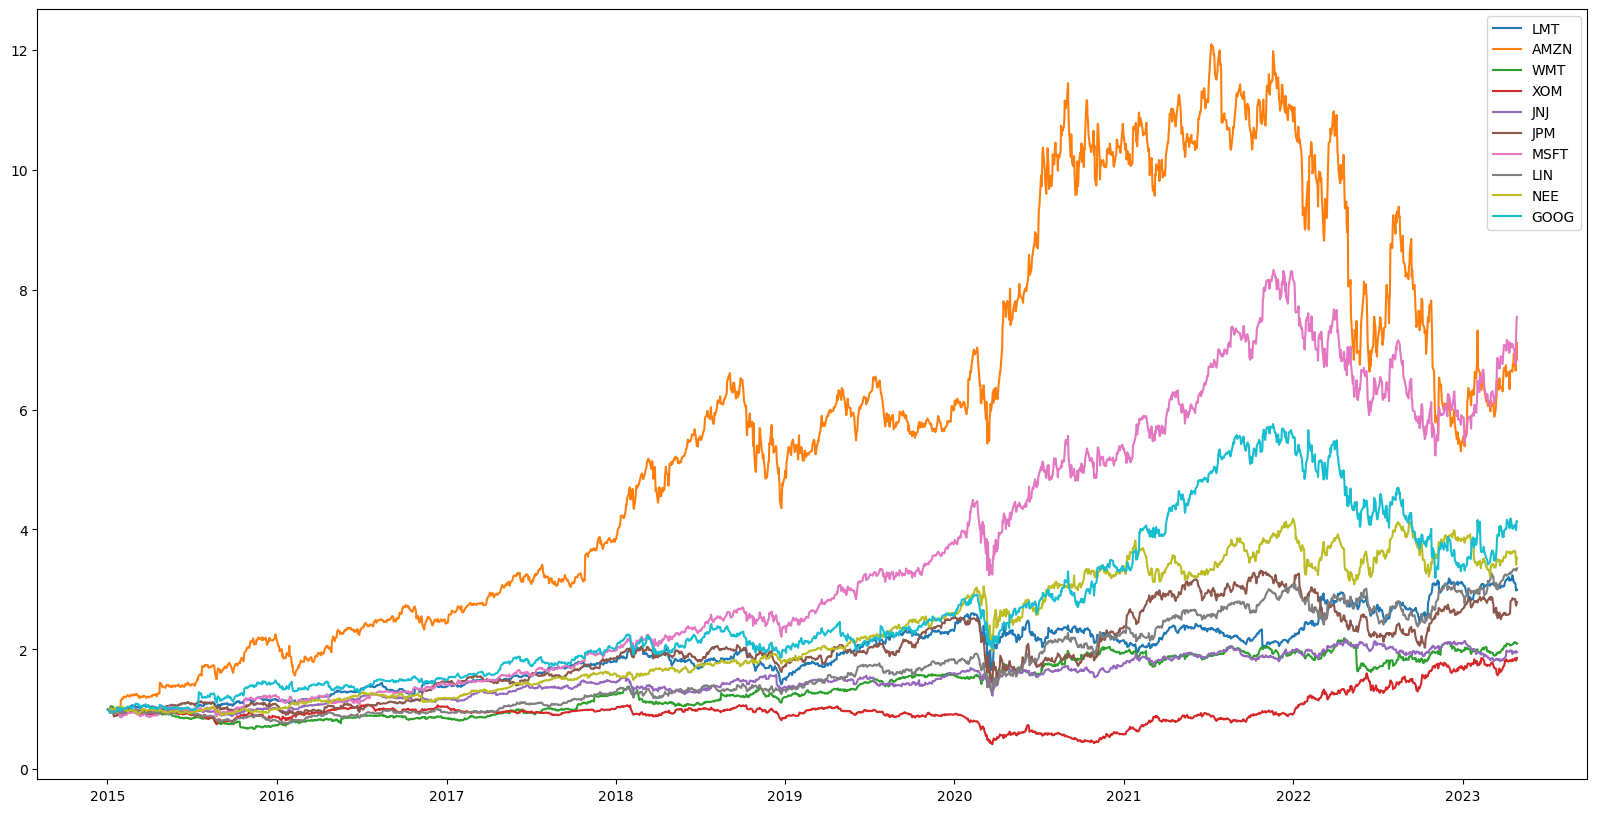

In [297]:
fig, ax = plt.subplots(figsize=(20,10))

for sym in list(zip(*corps_dict.values()))[0]:
    ax.plot(df_price[sym]/df_price[sym].iloc[0], label=sym)
ax.legend()
plt.show()

In [298]:
df_ret = df_price/df_price.shift(1) # daily return
dropIdx = df_ret["AAPL"].index[ df_ret["AAPL"].apply( np.isnan ) ]
df_ret = df_ret.drop( dropIdx )
logret = np.log( df_ret.to_numpy() ) # daily log-return
logret = logret / logret.std() # re-scale
logret_tensor = torch.from_numpy( logret ).float()

Epoch:250, LossD/G:1.3714/-0.6815


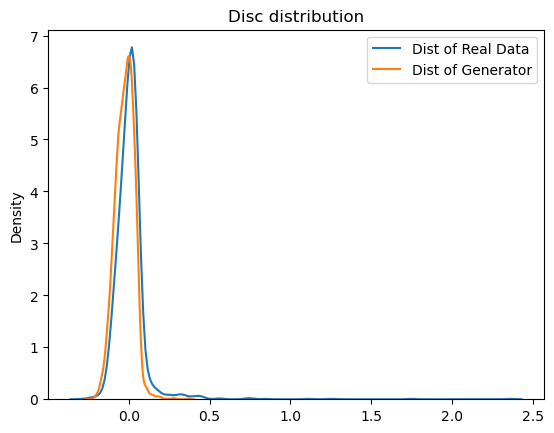

Epoch:500, LossD/G:1.3515/-0.6711


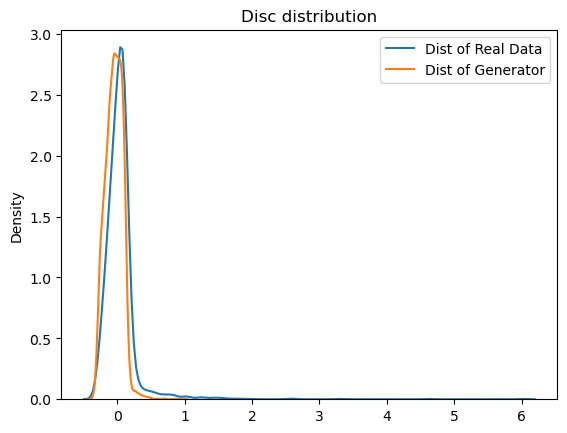

Epoch:750, LossD/G:1.3114/-0.6511


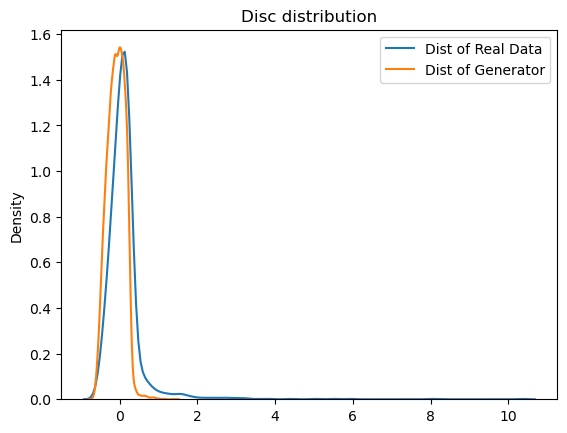

Epoch:1000, LossD/G:1.2760/-0.6436


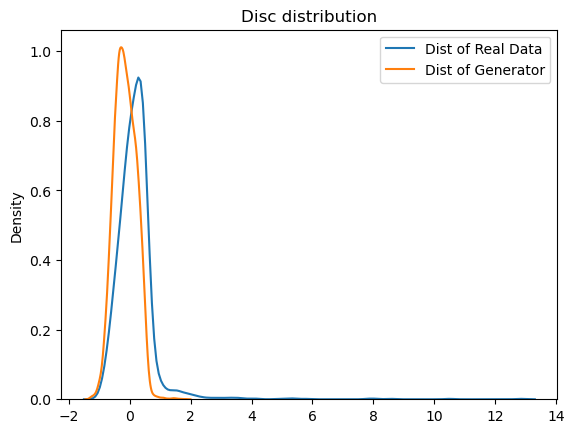

Epoch:1250, LossD/G:1.2760/-0.6406


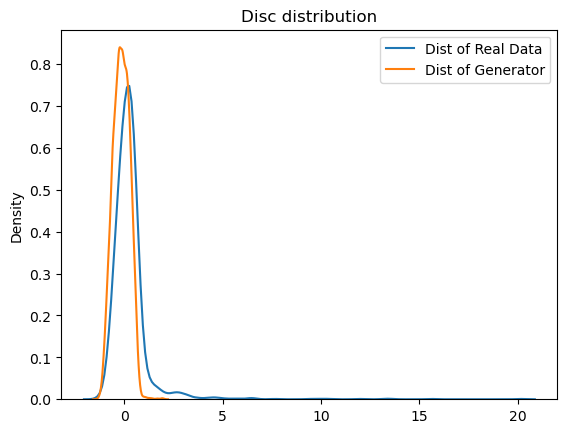

Epoch:1500, LossD/G:1.2003/-0.6350


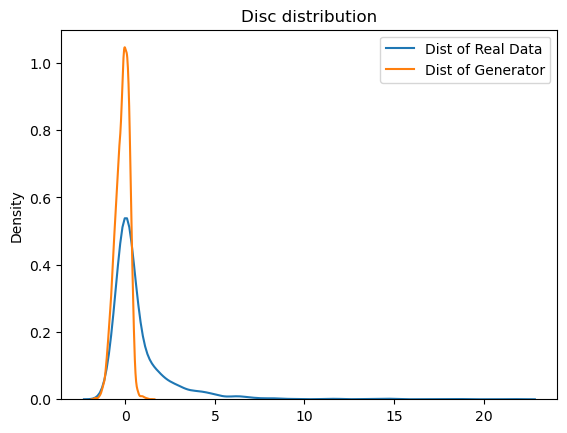

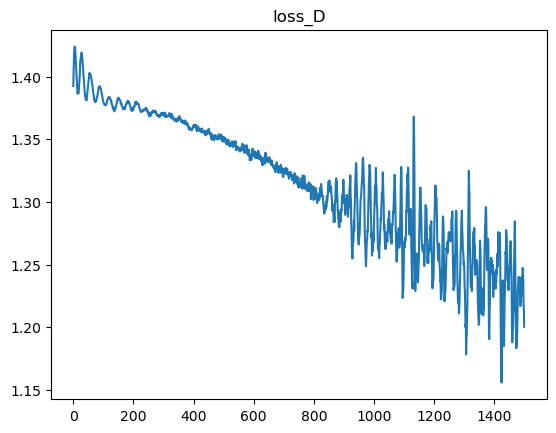

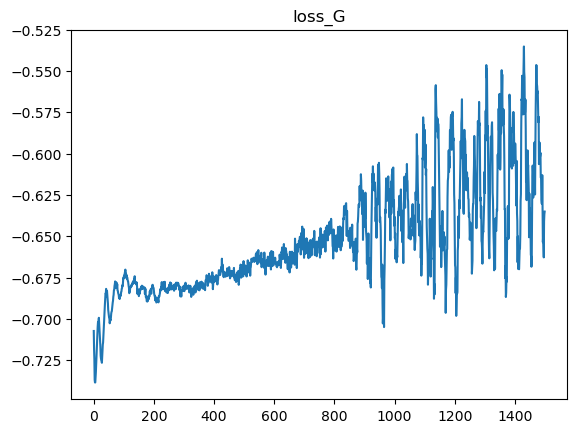

Time for running this cell: 479.86s


In [313]:
## Fitted by Gaussian
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

s0 = time.time()
f1 = fgan(50, 0.0, device, epsilon=1e-5)
f1.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f1.data_init(batch_size=25, data=logret_tensor)
f1.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f1.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f1.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Gaussian fits the distribution not quite well. The Generator tends to diverge from the distribution of real data, it may be caused by the tolerence of Discriminator for skewed and heavy-tail data is not high. We can consider more large families to sacrifice some robustness to get more accurate estimation, thus can then benefit stability of the training and make a sharp Discriminator, which can then benifit robustness.

Epoch:250, LossD/G:1.3865/-0.7012


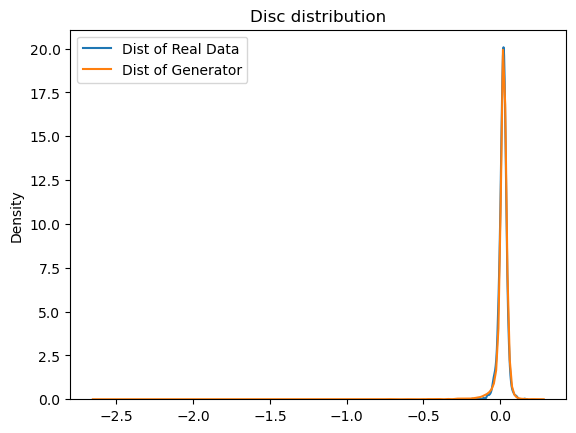

Epoch:500, LossD/G:1.3794/-0.6962


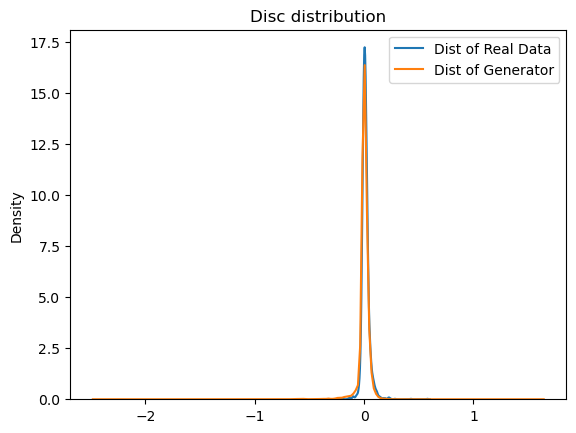

Epoch:750, LossD/G:1.3738/-0.6938


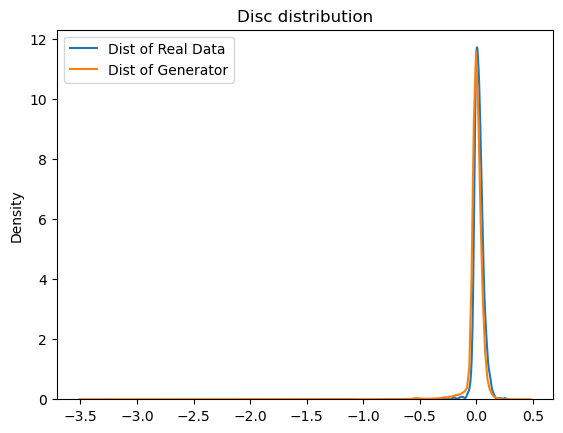

Epoch:1000, LossD/G:1.3667/-0.6847


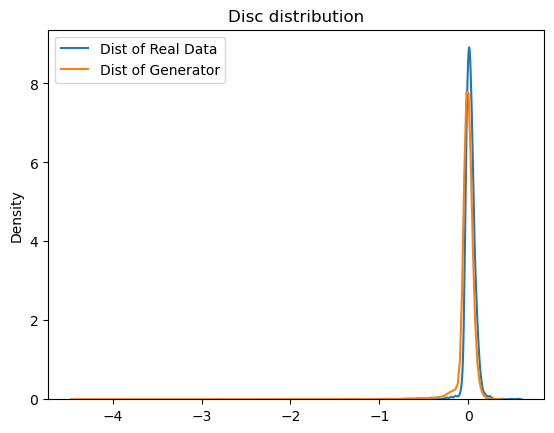

Epoch:1250, LossD/G:1.3520/-0.6793


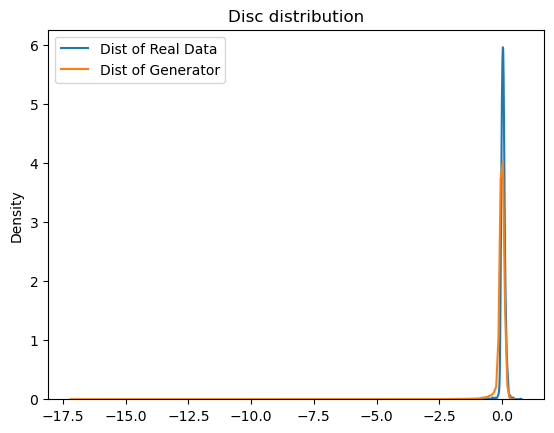

Epoch:1500, LossD/G:1.3419/-0.6642


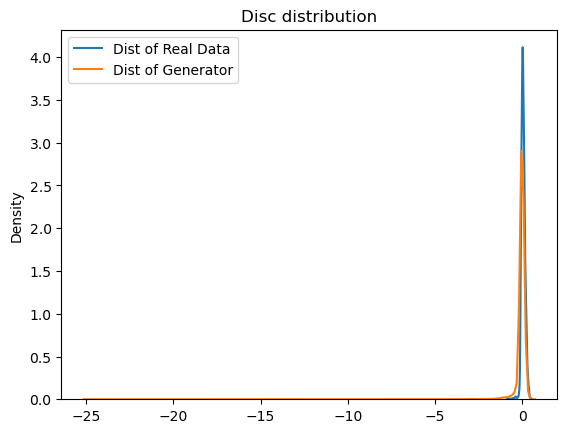

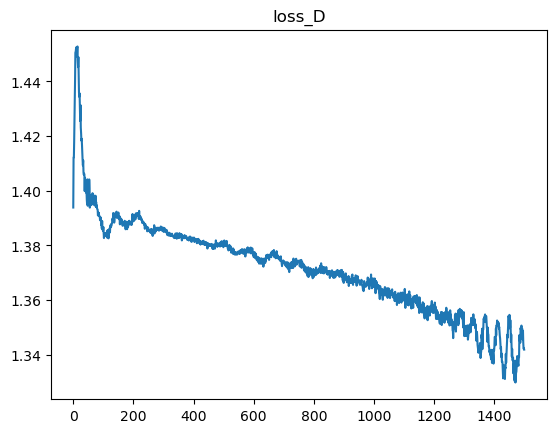

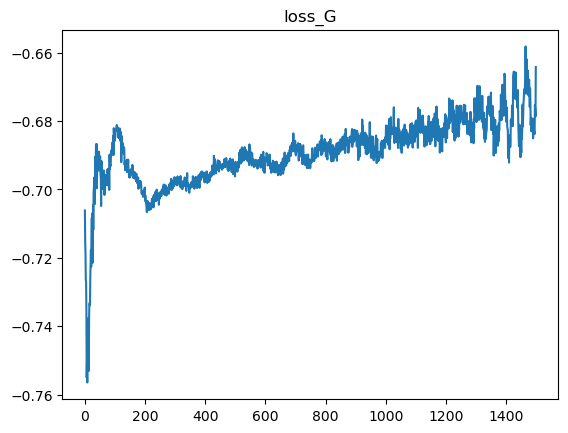

Time for running this cell: 255.11s


In [305]:
## Fitted by Student-t
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

s0 = time.time()
f2 = fgan(50, 0.0, device, epsilon=1e-5)
f2.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f2.data_init(batch_size=50, data=logret_tensor)
f2.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f2.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f2.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Student-$t$ seems a better fit than Gaussian, though with oscillations too. 

Epoch:250, LossD/G:1.3876/-0.6962


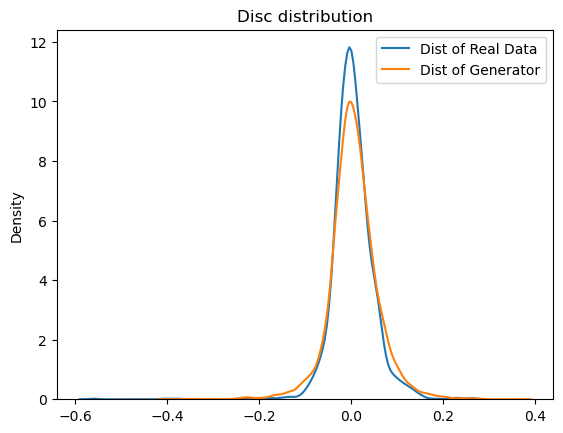

Epoch:500, LossD/G:1.3827/-0.6971


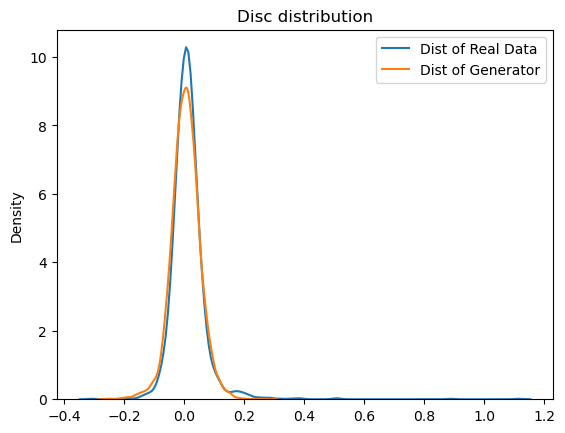

Epoch:750, LossD/G:1.3769/-0.6921


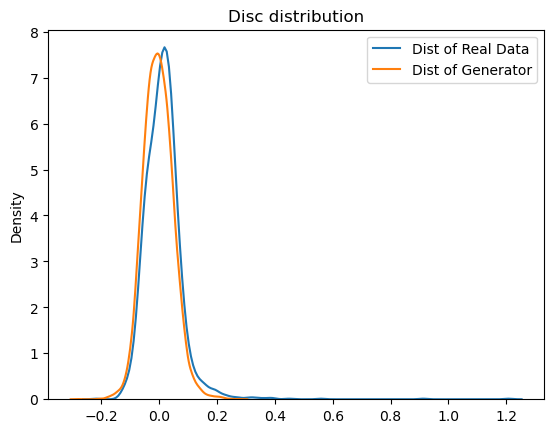

Epoch:1000, LossD/G:1.3753/-0.6893


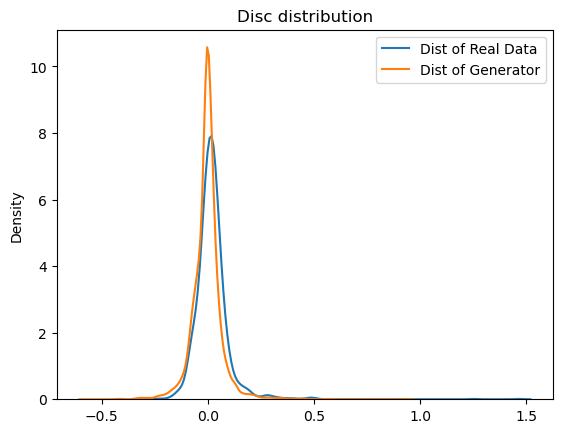

Epoch:1250, LossD/G:1.3720/-0.6880


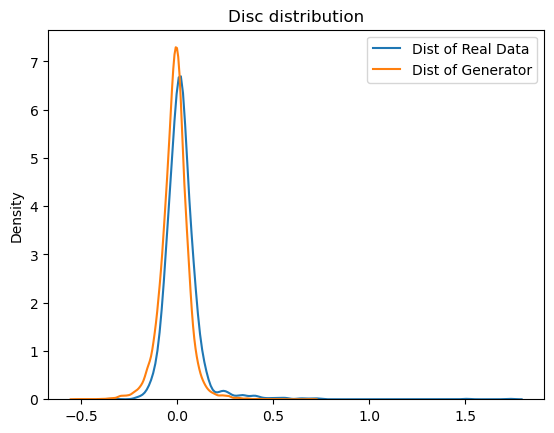

Epoch:1500, LossD/G:1.3680/-0.6816


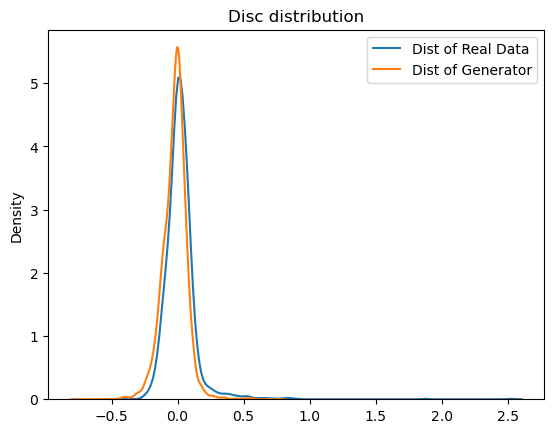

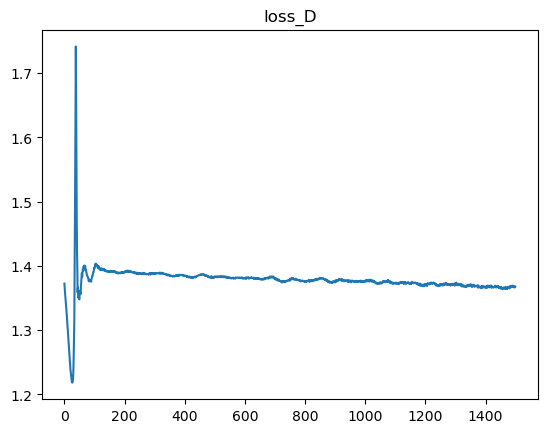

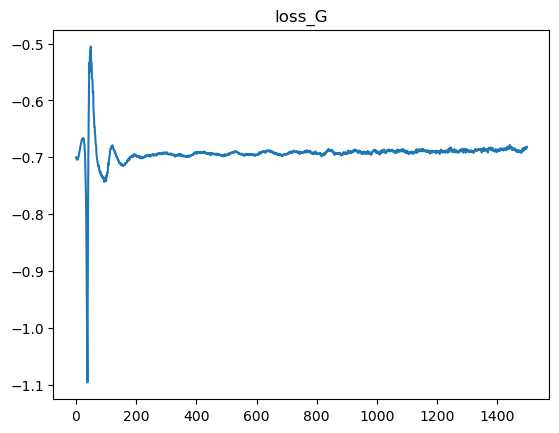

Time for running this cell: 298.49s


In [306]:
## Fitted by Elliptical
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

s0 = time.time()
f3 = fgan(50, 0.0, device, epsilon=1e-5)
f3.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f3.data_init(batch_size=50, data=logret_tensor)
f3.net_init(hidden_units=[100, 25], hidden_units_G=[25, 10], input_dim_G=10, use_bias=True,
            elliptical=True, init_D='xavier', init_D1=0.025, init_G='kendall',
            activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f3.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f3.fit(floss='js', epochs=1500, avg_epochs=50, inverse_gaussian=False,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

So general elliptical distribution seems with better fitting performance here than Gaussian and Student-$t$. 

### Outlier detection by Discriminator

Outlier is defined as samples whose discriminator values larger or smaller than $0.3$ or $-2$.

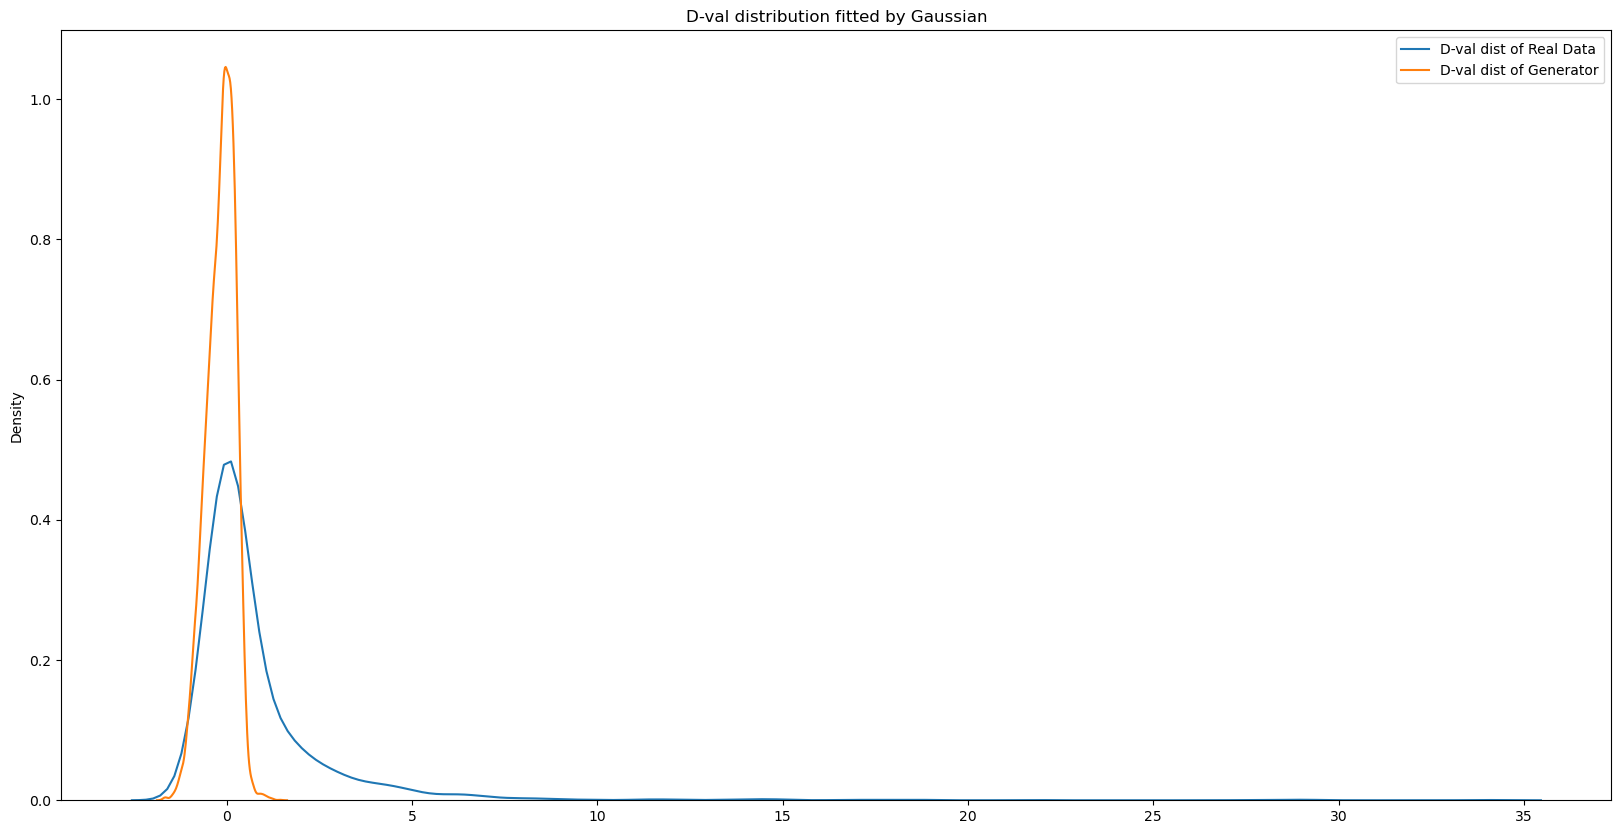

841 outliers are detected by Gaussian fit


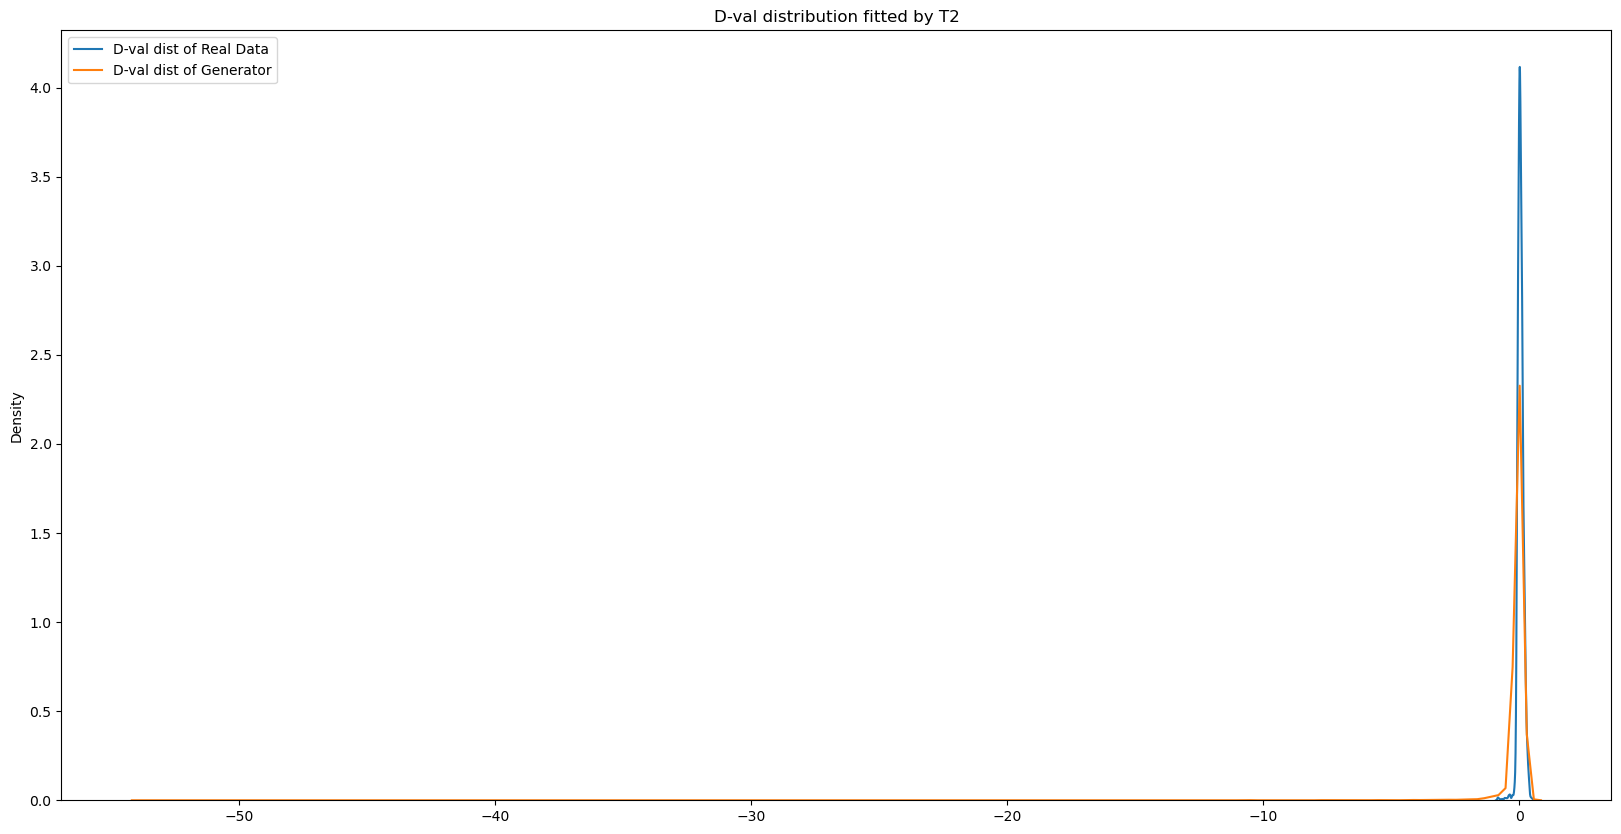

45 outliers are detected by T2 fit


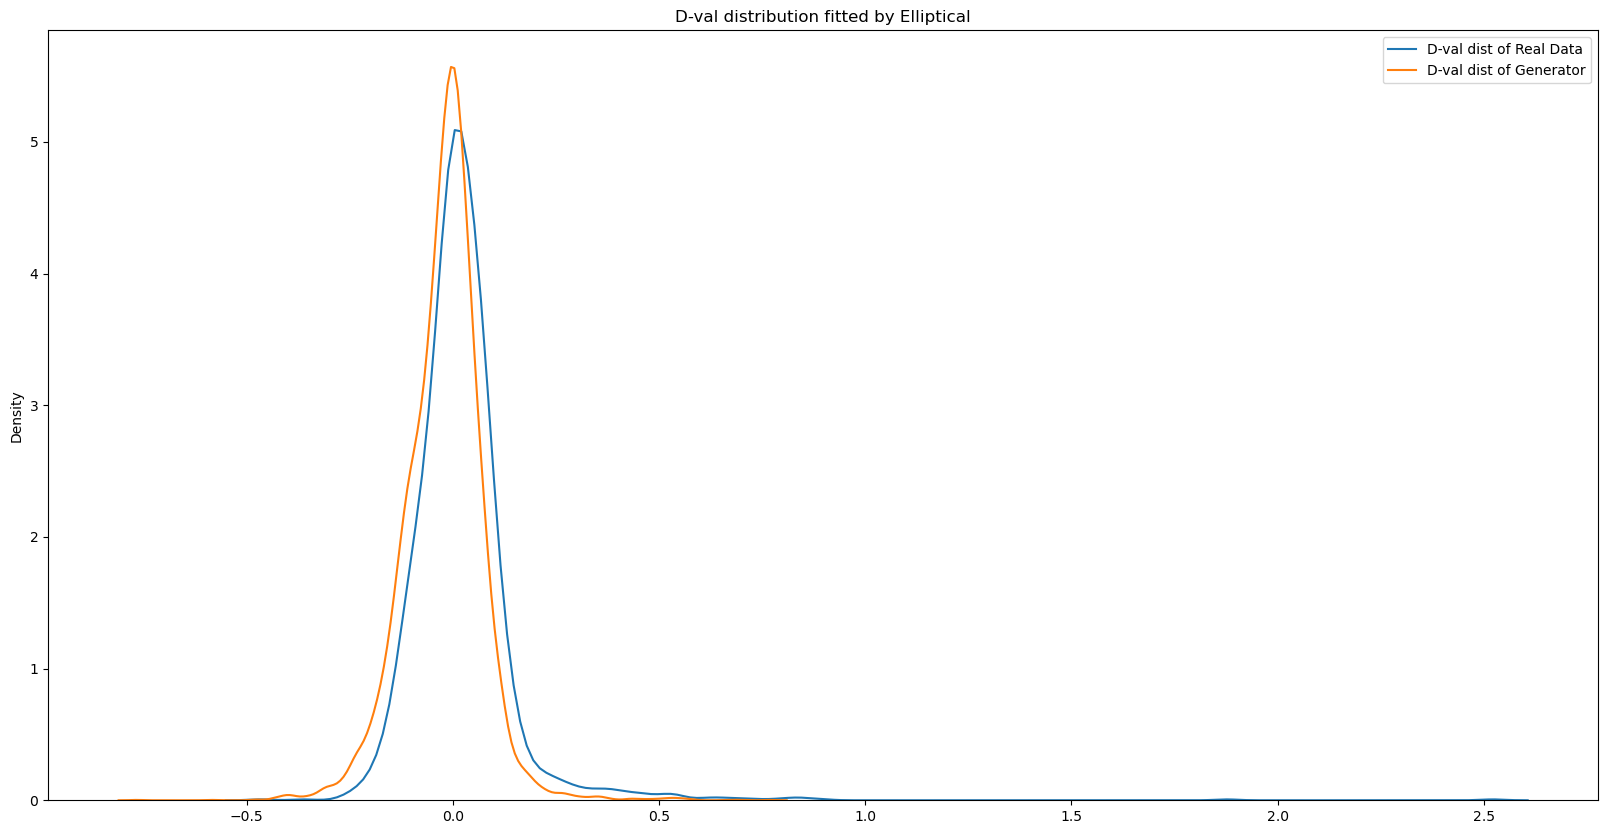

51 outliers are detected by Elliptical fit


In [319]:
outlierIndex = {}
model = ['Gaussian', 'T2', "Elliptical"]

for i in range(3):
    f = eval("f"+str(i+1))
    fig, ax = plt.subplots(figsize=(20,10))

    real_D = f.netD(f.Xtr.to(device))[1].detach().cpu().numpy()
    ## generating sample score
    if not f.elliptical:
        if f.true_type == 'Student':
            temp_z = torch.randn(10000, f.p).to(device) # [N, p]
            temp_z.div_(torch.sqrt(f.t_chi2_d.sample((10000, 1))/f.t_df).to(device) + f.epsilon)
            temp_g = f.netG(temp_z)
        elif f.true_type == 'Gaussian':
            temp_g = f.netG(torch.randn(10000, f.p).to(device))

    else:
        temp_u = torch.randn(10000, f.p).to(device)
        temp_u.data.div_(temp_u.norm(2, dim=1).view(-1, 1) + f.epsilon)
        if f.inverse_gaussian:
            temp_xi1 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2.data = 1/(torch.abs(temp_xi2.data) + f.epsilon)
            temp_xi = f.netGXi(torch.cat([temp_xi1, temp_xi2], dim=1)).view(10000, -1)
        else:
            temp_xi = f.netGXi(torch.randn(10000, f.input_dim_G).to(device)).view(10000, -1)
        temp_g = f.netG(temp_u, temp_xi)

    gene_D = f.netD(temp_g)[1].detach().cpu().numpy()

    sns.distplot(f.real_D, hist=False, label='D-val dist of Real Data')
    sns.distplot(f.gene_D, hist=False, label='D-val dist of Generator')
    plt.legend()
    plt.title('D-val distribution fitted by ' + model[i])
    plt.show()
    
    # outlier is defined as data with discriminator value larger(smaller) than
    # 99.75(1) percentile estimated from learned generator.
    outlierIndex[i] = (real_D > 0.3) | (real_D < -1)
    print( "{} outliers are detected by {} fit".format( outlierIndex[i].sum(), model[i]) )
    #print(np.std(gene_D))



In [309]:
## Import S&P 500 Index and see what happens at outlier date.
import pandas_datareader.data as web
import datetime

SPX = web.DataReader(['sp500'], 'fred', START, END)
SPX = SPX.loc[df_ret.index]

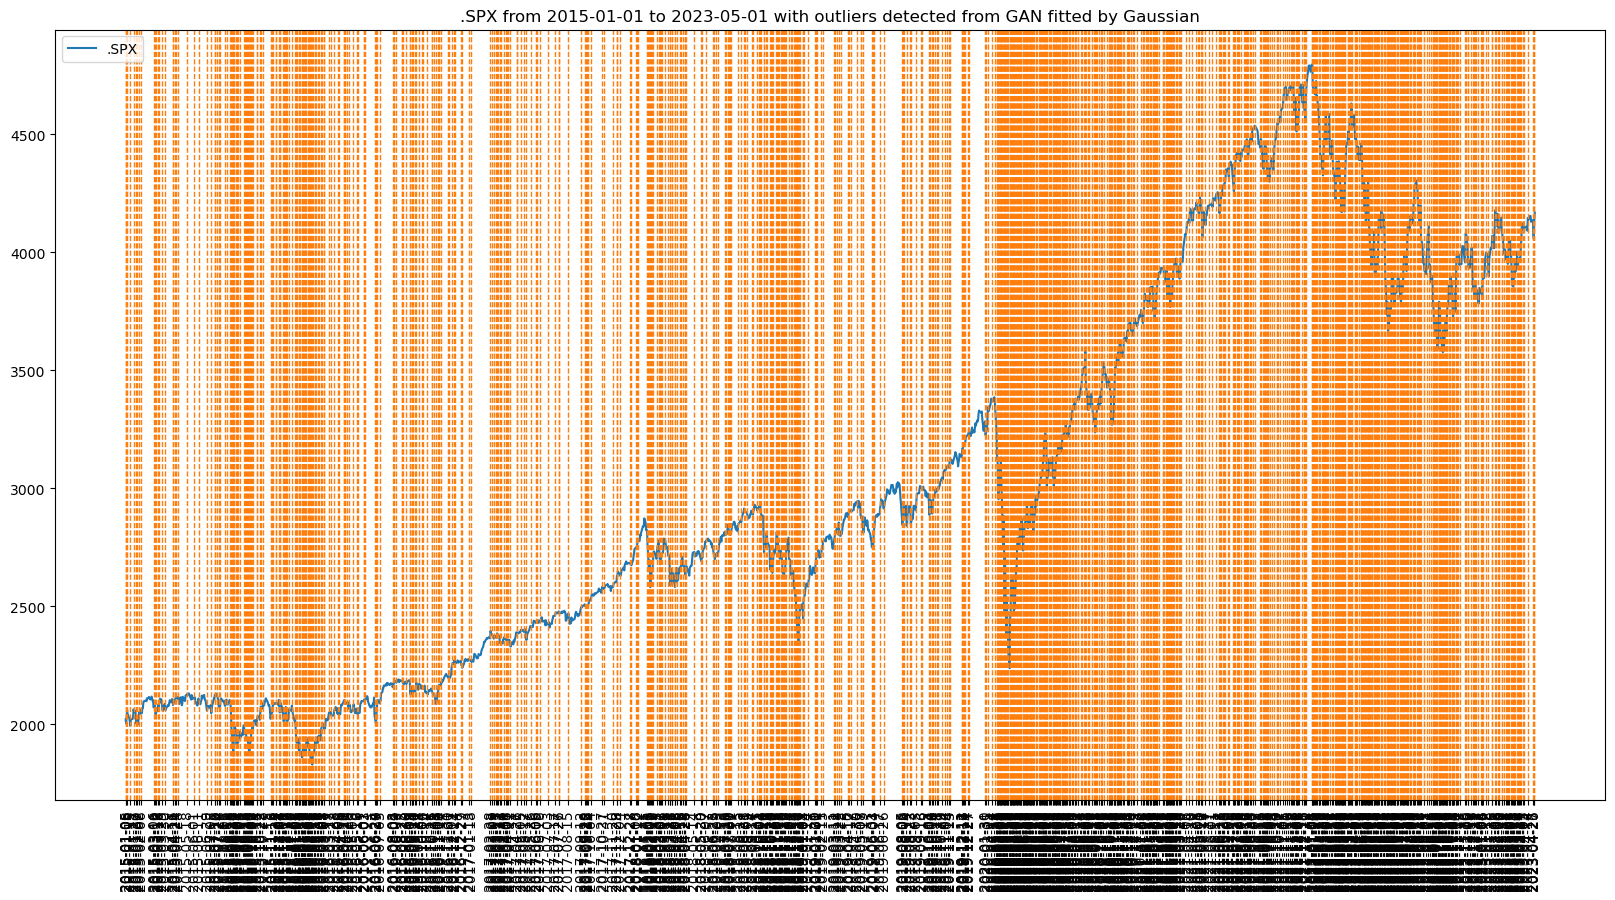

In [320]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[0]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected from GAN fitted by Gaussian".format(START, END) )
plt.show()

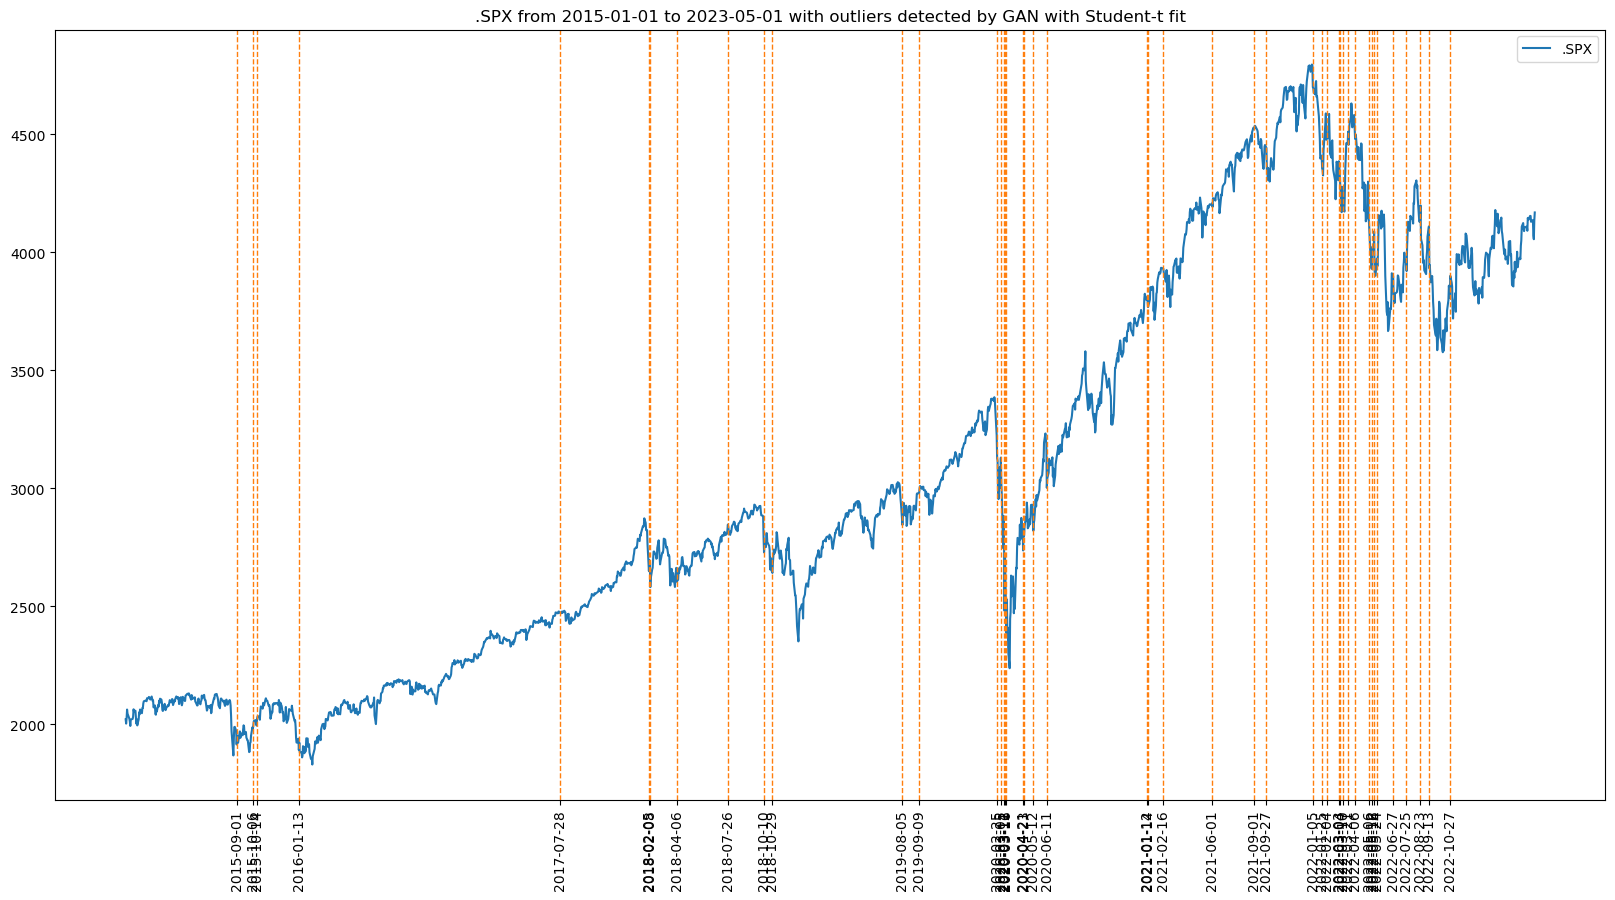

In [322]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[1]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected by GAN with Student-t fit".format(START, END) )
plt.show()

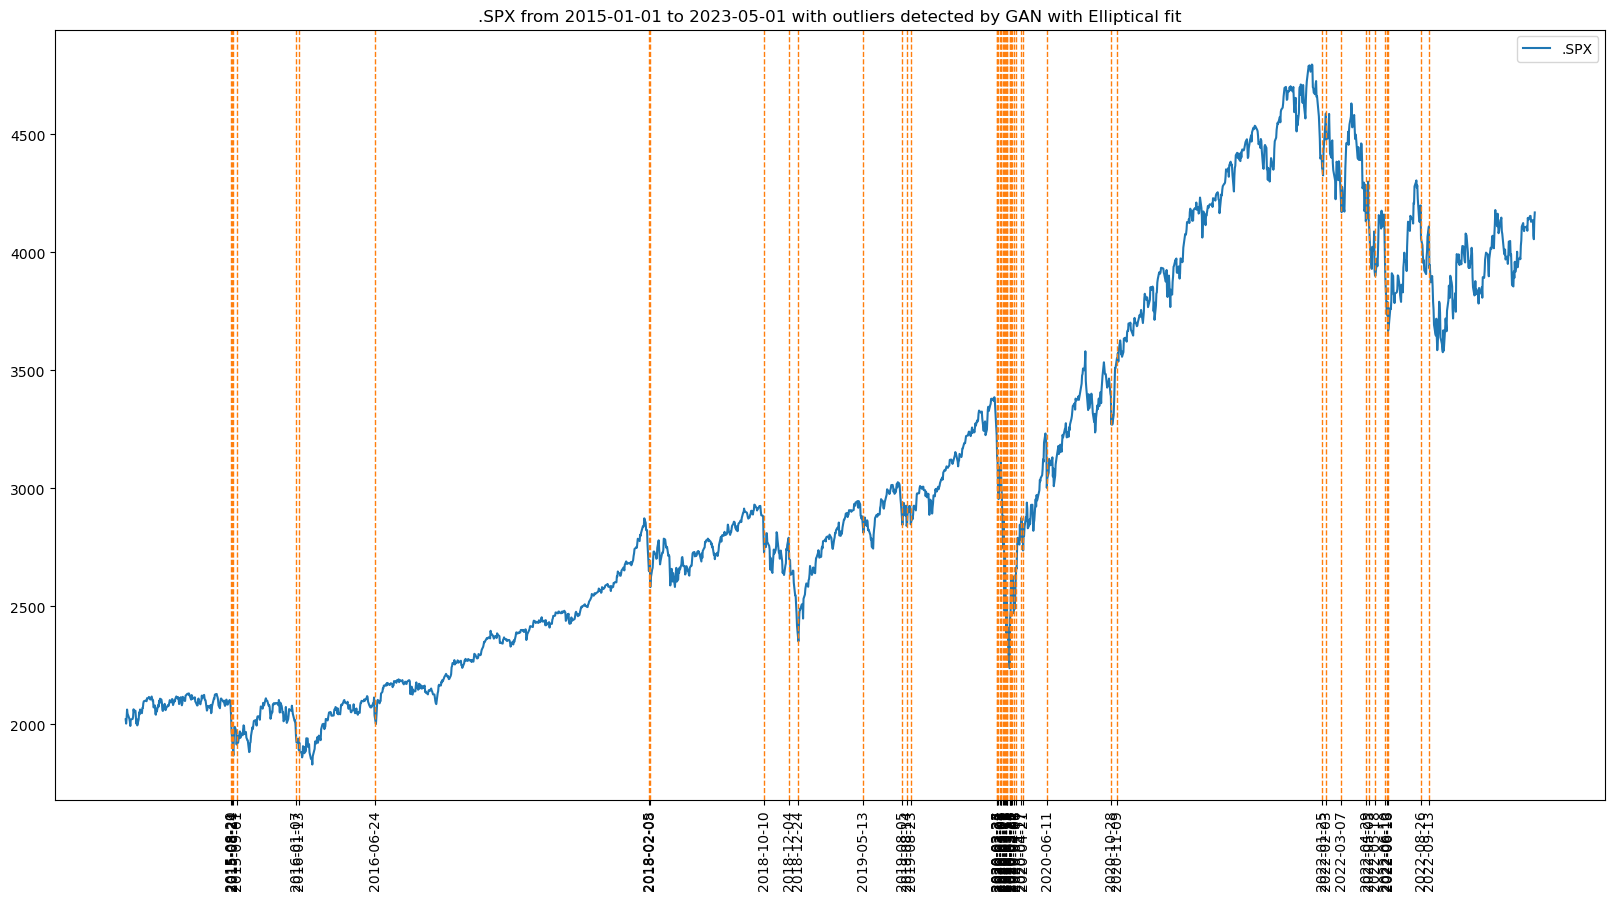

In [323]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[2]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected by GAN with Elliptical fit".format(START, END) )
plt.show()

These figures show that we need to trade off robustness and accuracy. A more general family of distributions can give a promotion of accuracy while lose some robustness. But a too narrow family like Gaussian may be too conservative to make a good guess.